# Проект: Промышленность. Предсказание температуры сплава.

## О проекте

__Заказчик__: металлургический комбинат «Стальная птица».

__Задача бизнеса__: оптимизировать производственные расходы путем уменьшения потребления электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

__Цель проекта__: разработать модель для предсказания температуры сплава. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

__Описание процесса обработки__:

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
Сначала происходит ___десульфурация___ — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь ___легируют___ — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

> Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на __доводку металла__ или поступает __в машину непрерывной разливки__. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

__Описание данных__:

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:
- steel.data_arc — данные об электродах;
- steel.data_bulk — данные об объёме сыпучих материалов;
- steel.data_bulk_time — данные о времени подачи сыпучих материалов;
- steel.data_gas — данные о продувке сплава газом;
- steel.data_temp — данные об измерениях температуры;
- steel.data_wire — данные об объёме проволочных материалов;
- steel.data_wire_time — данные о времени подачи проволочных материалов.

__Требования к решению:__

Необходимо задать константу RANDOM_STATE. Её значение будет равно дате начала  работы над проектом.

__Метрика__: MAE должно быть менее 6.8. Дополнительно оценить R².

__ВАЖНАЯ ИНФОРМАЦИЯ ОТ ЗАКАЗЧИКА__

- подача материала не измеряется сутками
- значения температуры ниже 1500 градусов — аномальные
- во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался
-  иногда наблюдается асинхронность в заданном времени разных датчиков. Если выстраивать хронологию процессов для разных партий, то можно столкнуться с тем, что полученная хронология не соответствует хронологии в описании. Не стоит воспринимать это как ошибку.

## Подготовка к проекту

### Установка библиотек

In [1]:
#!pip install -q phik

In [2]:
#!pip install -q catboost

In [ ]:
#!pip install -q shap

### Импортирование библиотек и функций

In [ ]:
import os
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sqlalchemy import create_engine
import shap
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

import torch
import torch.nn as nn

# константы
RANDOM_STATE = 120525

LABEL_SIZE = 12
TITLE_SIZE = 14

## Загрузка данных

Загрузим файл базы данных SQLite `final.db` с сервера Яндекс.Облака.

In [ ]:
!wget https://code.s3.yandex.net/ds/final.db

Выполним подключение к базе данных.

In [ ]:
path_to_db = 'final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

Получим список таблиц, имеющихся в базе.

In [8]:
query = '''
SELECT name
FROM sqlite_master
WHERE type='table'
'''

pd.read_sql(query, engine)

,name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_wire_time
4,contract
5,personal
6,phone
7,internet
8,data_gas
9,data_temp


Все необходимые нам таблицы присутствуют в списке. База содержит также другие таблицы, не указанные в описании. Загрузим нужные данные из базы в удобные для дальнейшей работы датафреймы.

In [9]:
data_arc = pd.read_sql('data_arc', engine)
data_bulk = pd.read_sql('data_bulk', engine)
data_bulk_time = pd.read_sql('data_bulk_time', engine)
data_gas = pd.read_sql('data_gas', engine)
data_temp = pd.read_sql('data_temp', engine)
data_wire = pd.read_sql('data_wire', engine)
data_wire_time = pd.read_sql('data_wire_time', engine)

__Промежуточный вывод__:
- загрузили все таблицы, указанные в описании.

## Исследовательский анализ и предобработка данных

In [10]:
def show_general_info(df):
    """
    Выводит основную информацию о датафрейме:
    - общую информацию
    - первые пять строк
    - количество дубликатов
    - количество пропусков

    Параметры:
    ----------
    df : DataFrame
        Датафрейм
    """
    print("\n=== Основная информация о датафрейме ===")
    df.info()

    print("\n=== Первые 5 строк ===")
    display(df.head())

    print("\n=== Количество дубликатов ===")
    print(f"Полных дубликатов строк: {df.duplicated().sum()}")

    print("\n=== Пропущенные значения ===")
    missing_data = pd.DataFrame({
        'Количество пропусков': df.isna().sum(),
        '% пропусков': (df.isna().mean() * 100).round(2)
    })

    # Выводим только столбцы с пропусками
    missing_data = missing_data[missing_data['Количество пропусков'] > 0]

    if len(missing_data) > 0:
        display(missing_data)
    else:
        print("Пропущенных значений нет!")

In [11]:
def analyze_numerical_data(data, column, title, bins_number=100,
                           show_stats=True, show_plots=True):
    """
    Функция помогает при проведении статистического анализа количественных
     признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода
    графика. Может принимать bins для построения графика,
    флаги для вывода статистики и графиков.

    Выводит для колонки:
    - статистику
    - гистограмму с отмеченным средним значением и медианой
    - диаграмму размаха

    Параметры:
    ----------
    data : DataFrame
        Исходные данные
    column : str
        Название колонки для анализа
    title : str
        Заголовок для визуализаций
    bins_number : int, optional
        Количество бинов для гистограммы (по умолчанию 100)
    show_stats : bool, optional
        Показывать статистику (по умолчанию True)
    show_plots : bool, optional
        Показывать графики (по умолчанию True)
    """

    median = data[column].median()
    mean = data[column].mean()

    if show_stats:
        print(f"\nСтатистика для '{title}':")
        print(data[column].describe())

    if show_plots:
        # Создание графиков
        _, ax = plt.subplots(2, 1, figsize=(17, 10))

        # Гистограмма
        ax[0].hist(data[column], bins=bins_number, color='skyblue')
        ax[0].set_title(f'Гистограмма для признака "{title}"', fontsize=TITLE_SIZE)
        ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
        ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
        ax[0].grid(True)

        ax[0].axvline(median, color='green', linestyle='dashed', linewidth=1.5,
                      label=f'Медиана: {median:.2f}')
        ax[0].axvline(mean, color='red', linestyle='dashed', linewidth=1.5,
                      label=f'Среднее: {mean:.2f}')
        ax[0].legend()

        # Диаграмма размаха
        ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
        ax[1].set_title(f'Диаграмма размаха для признака "{title}"',
                    fontsize=TITLE_SIZE)

        plt.tight_layout()
        plt.subplots_adjust(hspace=0.3)
        plt.show()

In [12]:
def analyze_discrete_data(data, column, title):
    """
    Функция помогает при проведении статистического анализа
     дискретных численных признаков.

    Принимает датасет, столбец для анализа и значение заголовка
     для вывода графика.

    Выводит для колонки:
    - описание данных
    - график частот
    - диаграмму размаха

    Параметры:
    ----------
    data : DataFrame
        Исходные данные
    column : str
        Название колонки для анализа
    title : str
        Заголовок для визуализаций
    """

    # описание данных
    print('\033[1m' + title + '\033[0m')
    display(data[column].describe())

    fig, ax = plt.subplots(2, 1, figsize=(17, 12))

    # График частот
    sns.countplot(data=data, x=column, hue=column, palette='Blues',
                 legend=False, ax=ax[0])
    ax[0].set_title(title, fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(False)
    # Добавление значений на столбцах
    for p in ax[0].patches:
        ax[0].annotate(f'{p.get_height():.0f}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       fontsize=12, color='black',
                       xytext=(0, 5), textcoords='offset points')

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"',
                    fontsize=TITLE_SIZE)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [13]:
def show_column_stats(column):
    """
    Выводит базовую статистику о столбце.

    Параметры:
    ----------
    column : pd.Series
        Анализируемый столбец данных
    """
    print(f"Уникальных значений: {column.nunique()}")
    print(f"Минимальное значение: {column.min()}")
    print(f"Максимальное значение: {column.max()}")

In [14]:
def analyze_time_columns(df, time_columns):
    """
    Анализирует временные столбцы в DataFrame
    и определяет минимальное и максимальное время.

    Параметры:
    ----------
    df : pd.DataFrame
        Входной DataFrame с временными данными
    time_columns : List[str]
        Список столбцов для анализа
    """

    min_time = pd.Timestamp.max
    max_time = pd.Timestamp.min

    for col in time_columns:

        col_min = df[col].min()
        col_max = df[col].max()
        unique_count = df[col].nunique()
        unique_values = df[col].unique()

        # Обновление общих min/max
        if col_min < min_time:
            min_time = col_min
        if col_max > max_time:
            max_time = col_max

        # Вывод анализа
        print(f"=== Анализ столбца {col} ===\n")
        print(f"Минимальное время: {col_min}")
        print(f"Максимальное время: {col_max}")
        print(f"Количество уникальных значений: {unique_count}")
        print(f"Уникальные значения: {unique_values}")
        print("\n")

    # Вывод общих min/max
    print(f"=== Общий анализ ===\n")
    print(f"Минимальное время: {min_time}")
    print(f"Максимальное время: {max_time}")
    print("\n")

In [15]:
# множество для хранения номеров партий, записи о которых нужно удалить
# из-за аномалий
keys_to_delete = set()

# множество для хранения номеров партий, для которых нет полной информации
# о прохождении всех этапов обработки
missed_keys = set()

### Общий анализ исходных таблиц

Проверим, все ли таблицы содержат данные.

In [16]:
for df in [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]:
    if df.shape[0] == 0:
        print('Обнаружен пустой датафрейм!')

Мы загрузили все таблицы, упоминавшиеся в описании, среди них пустых таблиц нет.

### steel.data_arc - данные об электродах

In [17]:
show_general_info(data_arc)


=== Основная информация о датафрейме ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

=== Первые 5 строк ===


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



=== Количество дубликатов ===
Полных дубликатов строк: 0

=== Пропущенные значения ===
Пропущенных значений нет!


Датасет `data_arc` содержит 14876 записей, полных дубликатов нет, пропусков нет. Столбцы необходимо переименовать, используя латиницу, и привести названия к змеиному регистру. Типы данных определены не верно. Отметим, что номер партии `key` представлен числом.

In [18]:
data_arc = data_arc.rename(
    columns={'Начало нагрева дугой': 'begin_heat',
             'Конец нагрева дугой': 'end_heat',
             'Активная мощность': 'active_power',
             'Реактивная мощность':'reactive_power'})
data_arc.columns

Index(['key', 'begin_heat', 'end_heat', 'active_power', 'reactive_power'], dtype='object')

In [19]:
# получим 10 примеров, чтобы точно определить формат даты
data_arc.sample(10)

,key,begin_heat,end_heat,active_power,reactive_power
5408,1177,2019-06-17 03:00:49,2019-06-17 03:07:24,0.784388,0.606108
3503,759,2019-06-02 04:54:13,2019-06-02 05:00:13,0.362600,0.272670
7336,1593,2019-07-02 05:58:58,2019-07-02 06:01:17,0.443071,0.302122
14326,3117,2019-09-02 07:16:47,2019-09-02 07:18:28,0.974120,0.739287
9359,2029,2019-07-24 13:16:51,2019-07-24 13:19:07,1.332860,1.112883
1452,314,2019-05-15 13:56:18,2019-05-15 13:59:23,0.605294,0.501376
6165,1343,2019-06-23 00:57:50,2019-06-23 01:00:01,0.618304,0.412900
665,144,2019-05-09 02:58:07,2019-05-09 03:04:12,0.688376,0.472484
7542,1641,2019-07-03 17:39:29,2019-07-03 17:41:31,0.838585,0.627793
7222,1570,2019-07-01 12:34:59,2019-07-01 12:39:01,0.370576,0.234898


In [20]:
for col in ['begin_heat', 'end_heat']:
    data_arc[col] = pd.to_datetime(data_arc[col], errors='coerce', format='%Y-%m-%d %H:%M:%S')

data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   begin_heat      14876 non-null  datetime64[ns]
 2   end_heat        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Колонки переименованы, типы изменены. Рассмотрим каждый из признаков подробнее.

In [21]:
show_column_stats(data_arc['begin_heat'])

Уникальных значений: 14876
Минимальное значение: 2019-05-03 11:02:14
Максимальное значение: 2019-09-06 17:24:54


In [22]:
show_column_stats(data_arc['end_heat'])

Уникальных значений: 14876
Минимальное значение: 2019-05-03 11:06:02
Максимальное значение: 2019-09-06 17:26:15


In [23]:
(data_arc['begin_heat'] >= data_arc['end_heat']).sum()

np.int64(0)

Датасет содержит данные за период с 03.05.2019 по 06.09.2019. Для всех записей дата начала нагрева меньше даты окончания нагрева. Логических ошибок нет.

In [24]:
show_column_stats(data_arc['key'])

Уникальных значений: 3214
Минимальное значение: 1
Максимальное значение: 3241


In [25]:
# пропущенные партии (data_arc)
missed_keys_data_arc = sorted(set(range(1, 3242)) - set(data_arc['key']))
print(missed_keys_data_arc)

[41, 42, 195, 279, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]


In [26]:
len(missed_keys_data_arc)

27

Номер партии находится в диапазоне от 1 до 3241. При этом число уникальных значений меньше, значит в датасете отсутствуют сведения по 27 партиям (либо записи пропущены, либо эти партии вообще не проходили обработку). Т.к. процесс обработки начинается с нагрева и этот этап является обязательным (по информации заказчика), будет правильным удалить данные о пропущенных партиях из остальных датасетов. Добавим номера пропущенных партий в общее множество, далее при анализе будем учитывать значения номеров партий в других таблицах.

In [27]:
# добавим значение в общее множество
missed_keys.update(missed_keys_data_arc)
len(missed_keys)

27


Статистика для 'Активная мощность':
count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: active_power, dtype: float64


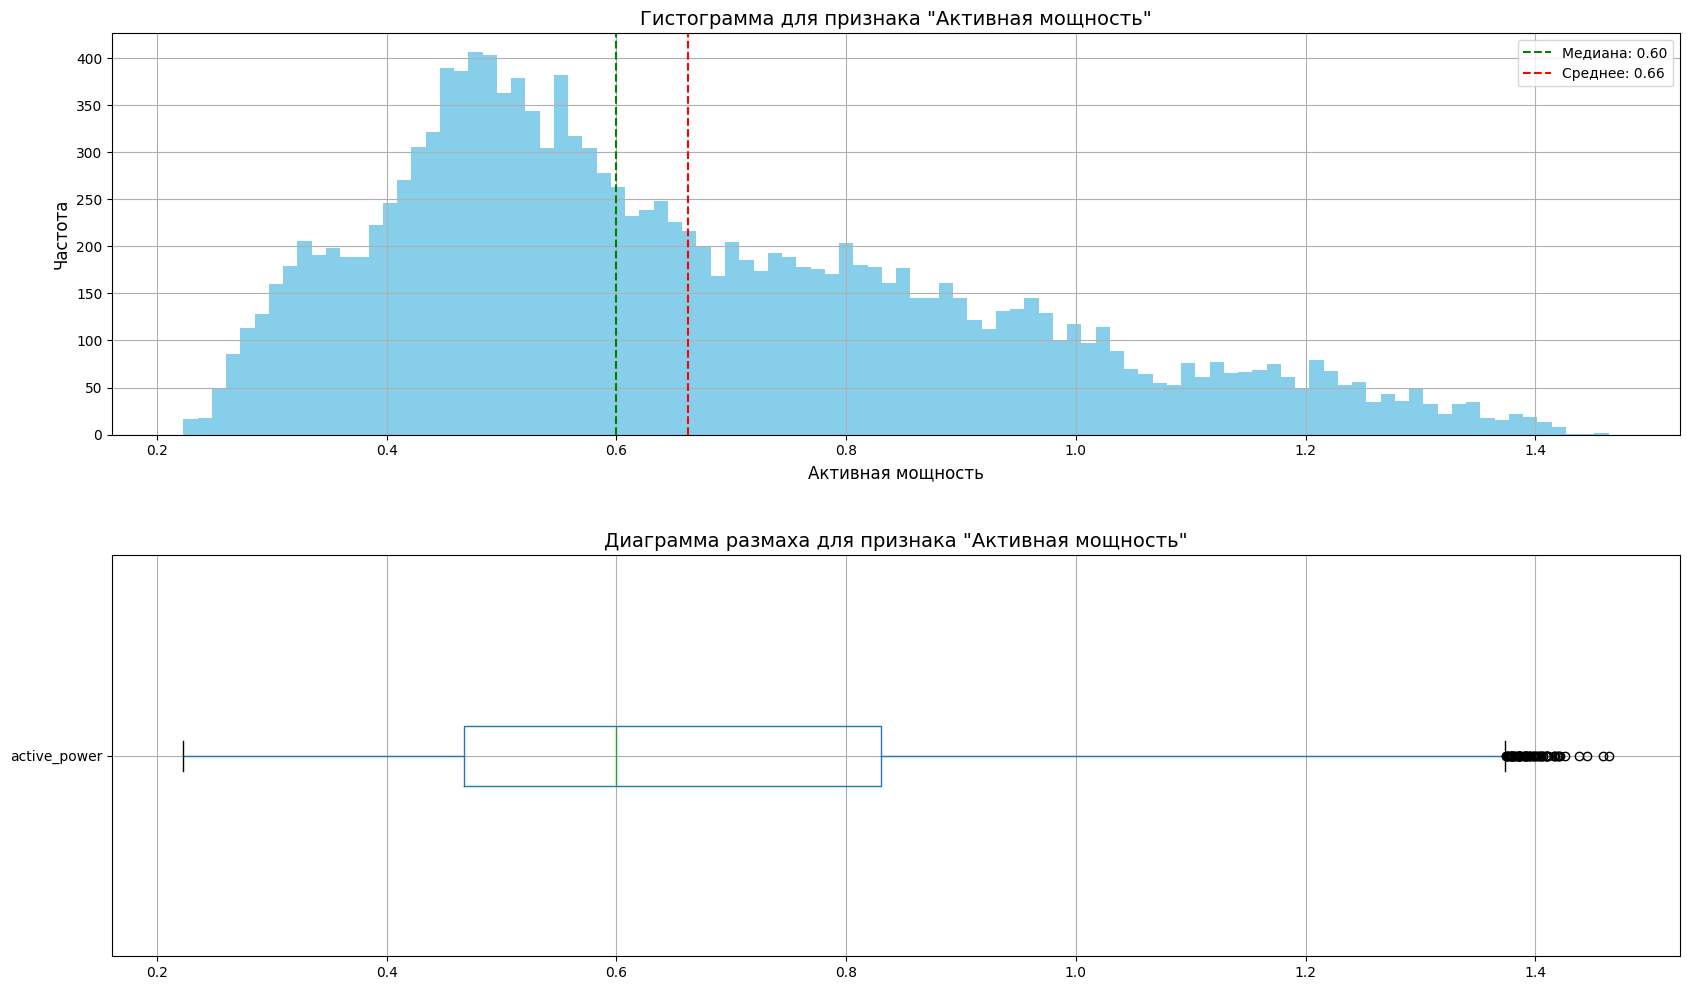

In [28]:
analyze_numerical_data(data_arc, 'active_power', 'Активная мощность')

Все значения активной мощности находятся в физически  допустимом диапазоне. Присутствуют нетипично большие значения, однако они не являются аномальными.


Статистика для 'Реактивная мощность':
count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64


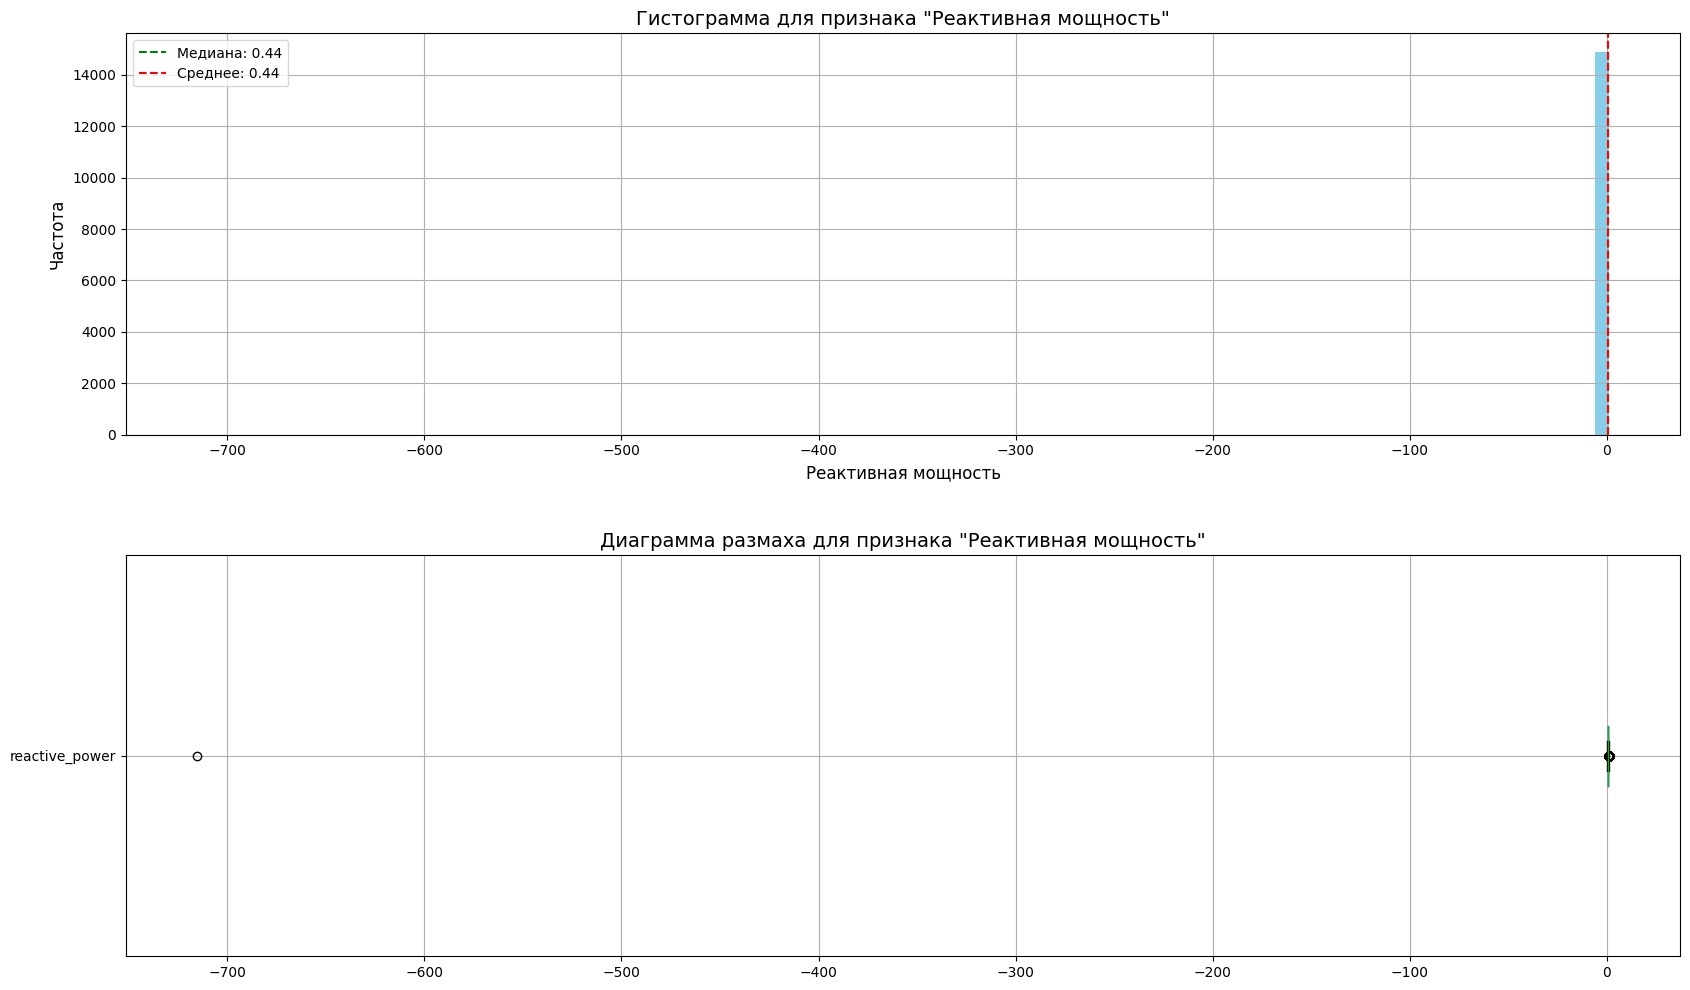

In [29]:
analyze_numerical_data(data_arc, 'reactive_power', 'Реактивная мощность')

Отрицательное значение для реактивной мощности возможно, но для нашего процесса является аномалией. Определим номер партии, для которой записано аномальное значение, для удаления из остальных датасетов. Удалим отрицательное значение и посмотрим на обновленную информацию.

In [30]:
keys_with_negative_power = data_arc[data_arc['reactive_power'] < 0]['key'].unique()
keys_with_negative_power

array([2116])

In [31]:
# добавим в общее множество партий с аномалиями
keys_to_delete.update(keys_with_negative_power)
len(keys_to_delete)

1

In [32]:
# количество записей на удаление
data_arc['key'].isin(keys_with_negative_power).sum()

np.int64(4)

In [33]:
data_arc = data_arc[~data_arc['key'].isin(keys_with_negative_power)]
data_arc.shape

(14872, 5)


Статистика для 'Реактивная мощность (очищенные данные)':
count    14872.000000
mean         0.487112
std          0.197623
min          0.153777
25%          0.337175
50%          0.441667
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64


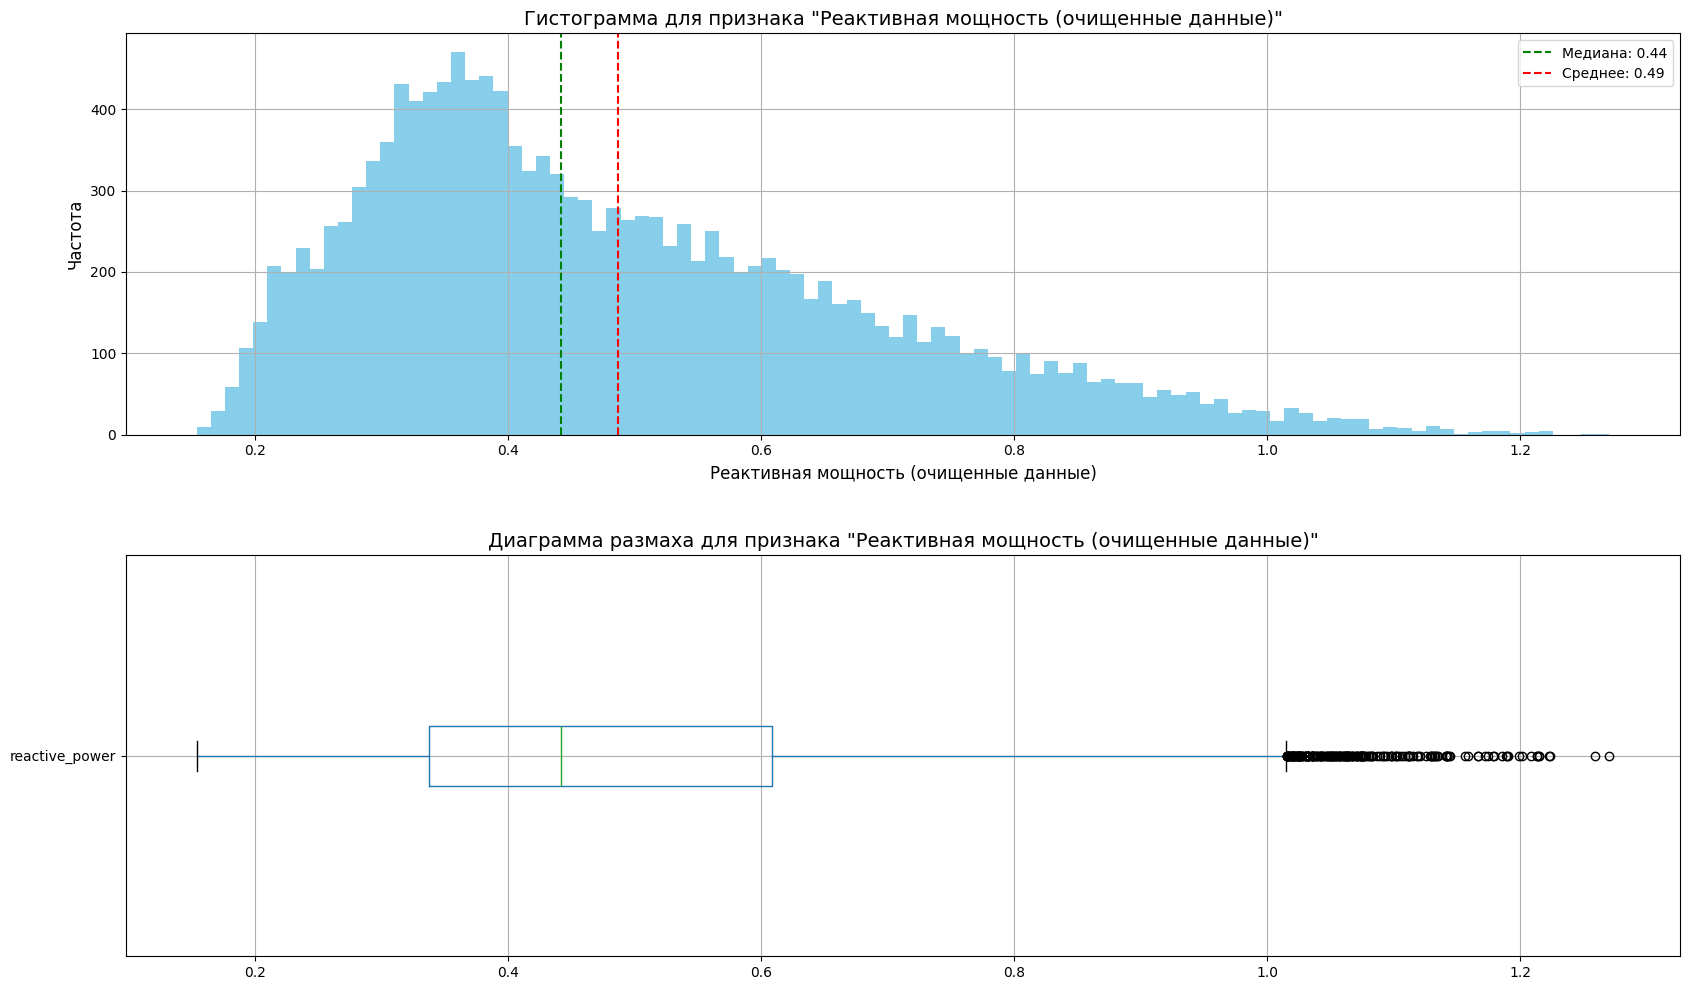

In [34]:
analyze_numerical_data(data_arc, 'reactive_power', 'Реактивная мощность (очищенные данные)')

Сгенерируем новые признаки.

In [35]:
# длительность нагрева
data_arc['duration_of_heating'] = (data_arc['end_heat'] - data_arc['begin_heat']).dt.total_seconds().astype(int)
# общая мощность
data_arc['apparent_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)
# соотношение активной мощности к реактивной
data_arc['active_to_reactive_ratio'] = data_arc['active_power'] / data_arc['reactive_power']
# активная энергия (идет на нагрев)
data_arc['active_energy'] = data_arc['apparent_power'] * data_arc['duration_of_heating']


Статистика для 'Длительность нагрева':
count    14872.000000
mean       171.688004
std         98.193604
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: duration_of_heating, dtype: float64


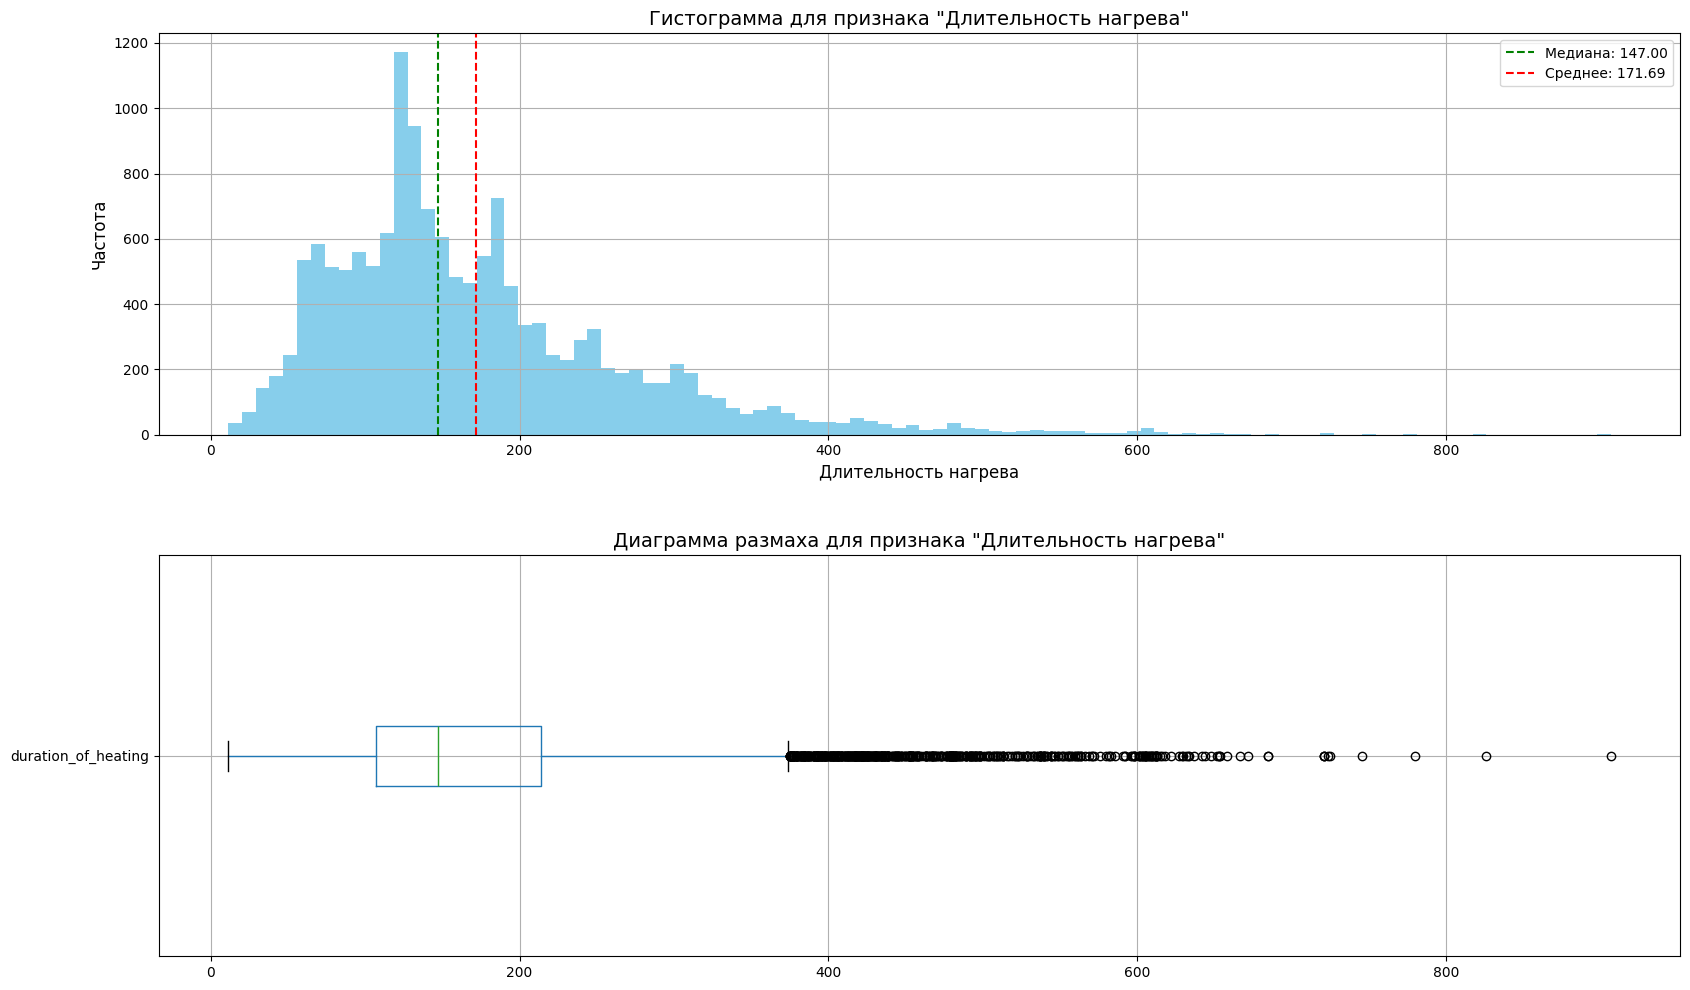

In [36]:
# поищем аномалии в длительности нагрева
analyze_numerical_data(data_arc, 'duration_of_heating', 'Длительность нагрева')

Длительность нагрева в пределах нормы - в диапазоне от 11 до 907 секунд.

Агрегируем наблюдения по ключу.

In [37]:
data_arc_aggregated = data_arc.groupby('key').agg(
    duration_of_heating=('duration_of_heating', 'sum'),
    active_power_median=('active_power', 'median'),
    active_power_sum=('active_power', 'sum'),
    reactive_power_median=('reactive_power', 'median'),
    reactive_power_sum=('reactive_power', 'sum'),
    apparent_power_median=('apparent_power', 'median'),
    active_to_reactive_ratio_median=('active_to_reactive_ratio', 'median'),
    count_of_heating=('key', 'count'),
    full_active_energy=('active_energy', 'sum')
).reset_index()
data_arc_aggregated.head()

,key,duration_of_heating,active_power_median,active_power_sum,reactive_power_median,reactive_power_sum,apparent_power_median,active_to_reactive_ratio_median,count_of_heating,full_active_energy
0,1,1098,0.580313,3.036730,0.430460,2.142821,0.722536,1.364539,5,770.282114
1,2,811,0.545710,2.139408,0.352656,1.453357,0.650151,1.457020,4,481.760005
2,3,655,0.774632,4.063641,0.505690,2.937457,0.925082,1.415997,5,722.837668
3,4,741,0.753970,2.706489,0.580275,2.056992,0.954624,1.303153,4,683.455597
4,5,869,0.517715,2.252950,0.374041,1.687991,0.639021,1.328578,4,512.169934


### steel.data_bulk - данные об объёме сыпучих материалов

In [38]:
show_general_info(data_bulk)


=== Основная информация о датафрейме ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB

=== Первые 5 строк ===


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0



=== Количество дубликатов ===
Полных дубликатов строк: 0

=== Пропущенные значения ===


,Количество пропусков,% пропусков
Bulk 1,2877,91.95
Bulk 2,3107,99.30
Bulk 3,1831,58.52
Bulk 4,2115,67.59
Bulk 5,3052,97.54
Bulk 6,2553,81.59
Bulk 7,3104,99.20
Bulk 8,3128,99.97
Bulk 9,3110,99.39
Bulk 10,2953,94.38


In [39]:
data_bulk.duplicated(subset='key').sum()

np.int64(0)

Датасет `data_bulk` содержит 3129 записей, полных дубликатов нет. Столбцы необходимо переименовать, используя латиницу, и привести названия к змеиному регистру. Типы данных определены не верно. Номер партии `key` представлен числом, нет повторяющихся значений.

Пропуск означает, что материал не добавляли в партию. Заменим пропуски на нули.

In [40]:
new_columns = [col.lower().replace(' ', '_') for col in data_bulk.columns]
data_bulk.columns = new_columns
data_bulk = data_bulk.fillna(0)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   object 
 6   bulk_6   3129 non-null   object 
 7   bulk_7   3129 non-null   object 
 8   bulk_8   3129 non-null   object 
 9   bulk_9   3129 non-null   object 
 10  bulk_10  3129 non-null   object 
 11  bulk_11  3129 non-null   object 
 12  bulk_12  3129 non-null   object 
 13  bulk_13  3129 non-null   object 
 14  bulk_14  3129 non-null   object 
 15  bulk_15  3129 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB


In [41]:
for col in new_columns:
    if data_bulk[col].dtype == 'object':
        # приведем к числовому формату, чтобы проверить дробную часть
        data_bulk[col] = pd.to_numeric(data_bulk[col], errors='coerce')
    if data_bulk[col].dtype == 'float64':
        if data_bulk[data_bulk[col] % 1 != 0].shape[0] > 0:
            print(f"В столбце {col} есть дробные числа.")
        else:
            data_bulk[col] = data_bulk[col].astype(int)

data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int64
 1   bulk_1   3129 non-null   int64
 2   bulk_2   3129 non-null   int64
 3   bulk_3   3129 non-null   int64
 4   bulk_4   3129 non-null   int64
 5   bulk_5   3129 non-null   int64
 6   bulk_6   3129 non-null   int64
 7   bulk_7   3129 non-null   int64
 8   bulk_8   3129 non-null   int64
 9   bulk_9   3129 non-null   int64
 10  bulk_10  3129 non-null   int64
 11  bulk_11  3129 non-null   int64
 12  bulk_12  3129 non-null   int64
 13  bulk_13  3129 non-null   int64
 14  bulk_14  3129 non-null   int64
 15  bulk_15  3129 non-null   int64
dtypes: int64(16)
memory usage: 391.3 KB


In [42]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Все материалы подавались хотя бы раз. Медианные значения объема подаваемого материала для сыпучих материалов 12, 14, 15 большие (материалы часто использовались), для остальных материалов - нули. Далее по частоте использования - материалы 3 и 4 (ненулевое значение 75ого процентиля). Для остальных материалов распределения сильно скошены, присутствуют экстремальные выбросы.

Т.к. нетипичные значения связаны с тем, что могут подаваться только некоторые из материалов (это реальные данные процесса), оставим их в датасете.

In [43]:
num_columns = [col for col in data_bulk.columns if col != 'key']

# поищем строки, где для всех материалов объем равен нулю
zero_rows = data_bulk[(data_bulk[num_columns] == 0).all(axis=1)]
print("Найдено строк с общим нулевым объемом сыпучих материалов:",
      len(zero_rows))

Найдено строк с общим нулевым объемом сыпучих материалов: 0


In [44]:
# записи о партиях с аномалиями
data_bulk[data_bulk['key'].isin(keys_to_delete)]

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
2044,2116,0,0,0,0,0,137,0,0,0,0,0,0,0,198,0


In [45]:
show_column_stats(data_bulk['key'])

Уникальных значений: 3129
Минимальное значение: 1
Максимальное значение: 3241


In [46]:
# число записей о пропущенных партиях (из общего списка)
data_bulk['key'].isin(missed_keys).sum()

np.int64(1)

In [47]:
# пропущенные партии (data_bulk)
missed_keys_data_bulk = sorted(set(range(1, 3242)) - set(data_bulk['key']))
print(missed_keys_data_bulk)

[41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216]


In [48]:
missed_keys.update(missed_keys_data_bulk)
len(missed_keys)

113

Число уникальных значений совпадает с количеством записей - перед нами агрегированные данные (либо для всех партий подача осуществлялась только раз).

Встречаются записи о партиях, для которых нет информации о нагреве.

Диапазон значений номеров партий совпадает с data_arc, однако также есть партии, о которых нет записей. Номера таких партий добавили в общее множество.

### steel.data_bulk_time - данные о времени подачи сыпучих материалов

In [49]:
show_general_info(data_bulk_time)


=== Основная информация о датафрейме ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB

=== Первые 5 строк ===


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47



=== Количество дубликатов ===
Полных дубликатов строк: 0

=== Пропущенные значения ===


,Количество пропусков,% пропусков
Bulk 1,2877,91.95
Bulk 2,3107,99.30
Bulk 3,1831,58.52
Bulk 4,2115,67.59
Bulk 5,3052,97.54
Bulk 6,2553,81.59
Bulk 7,3104,99.20
Bulk 8,3128,99.97
Bulk 9,3110,99.39
Bulk 10,2953,94.38


In [50]:
data_bulk_time.duplicated(subset='key').sum()

np.int64(0)

Датасет `data_bulk_time` содержит 3129 записей, полных дубликатов нет. Столбцы необходимо переименовать, используя латиницу, и привести названия к змеиному регистру. Типы данных определены не верно. Номер партии `key` представлен числом, повторяющихся значений нет. Аналогично предыдущему датасету можно предположить, что пропуск означает, что материал не добавляли в партию.

На данный момент кажется, что эта информация не понадобится для нашей модели.

In [51]:
new_columns = [col.lower().replace(' ', '_') for col in data_bulk.columns]
data_bulk_time.columns = new_columns

In [52]:
bulk_columns = [col for col in data_bulk_time.columns if col != 'key']
for col in bulk_columns:
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col])

In [53]:
analyze_time_columns(data_bulk_time, bulk_columns)

=== Анализ столбца bulk_1 ===

Минимальное время: 2019-05-03 17:42:46
Максимальное время: 2019-09-05 09:11:32
Количество уникальных значений: 252
Уникальные значения: <DatetimeArray>
[                'NaT', '2019-05-03 17:42:46', '2019-05-05 16:26:52',
 '2019-05-05 17:18:36', '2019-05-05 18:32:50', '2019-05-05 19:34:07',
 '2019-05-05 20:36:08', '2019-05-05 21:41:07', '2019-05-05 22:07:40',
 '2019-05-06 03:19:35',
 ...
 '2019-09-03 09:24:41', '2019-09-04 04:48:19', '2019-09-04 16:01:08',
 '2019-09-04 19:33:27', '2019-09-04 20:39:01', '2019-09-04 20:51:19',
 '2019-09-05 01:56:45', '2019-09-05 02:37:08', '2019-09-05 06:10:59',
 '2019-09-05 09:11:32']
Length: 253, dtype: datetime64[ns]


=== Анализ столбца bulk_2 ===

Минимальное время: 2019-05-07 15:39:35
Максимальное время: 2019-08-13 11:47:39
Количество уникальных значений: 22
Уникальные значения: <DatetimeArray>
[                'NaT', '2019-05-07 15:39:35', '2019-05-07 16:16:34',
 '2019-05-07 19:13:07', '2019-05-07 22:50:29', '2019-05

Максимальное и минимальное время находятся в похожем диапазоне, что и время нагрева электродов, что подтверждает соответствие данных.

In [54]:
show_column_stats(data_bulk_time['key'])

Уникальных значений: 3129
Минимальное значение: 1
Максимальное значение: 3241


In [55]:
# пропущенные партии (data_bulk_time)
missed_keys_data_bulk_time = sorted(set(range(1, 3242)) - set(data_bulk_time['key']))
print(missed_keys_data_bulk_time)

[41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216]


In [56]:
# совпадают ли номера пропущенных партий с номерам из data_bulk
set(missed_keys_data_bulk_time) == set(missed_keys_data_bulk)

True

Отсутствуют данные о тех же записях, что и в `data_bulk`.

### steel.data_gas - данные о продувке сплава газом

In [57]:
show_general_info(data_gas)


=== Основная информация о датафрейме ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

=== Первые 5 строк ===


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



=== Количество дубликатов ===
Полных дубликатов строк: 0

=== Пропущенные значения ===
Пропущенных значений нет!


In [58]:
data_gas.duplicated(subset='key').sum()

np.int64(0)

Датасет `data_gas` содержит 3239 записей, полных дубликатов нет. Столбец `Газ 1` необходимо переименовать, используя латиницу, и привести название к змеиному регистру. Типы данных определены верно. Пропусков нет. Значения номеров партий уникальны.

In [59]:
data_gas = data_gas.rename(columns={'Газ 1': 'gas_1'})
data_gas.columns

Index(['key', 'gas_1'], dtype='object')


Статистика для 'gas_1':
count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas_1, dtype: float64


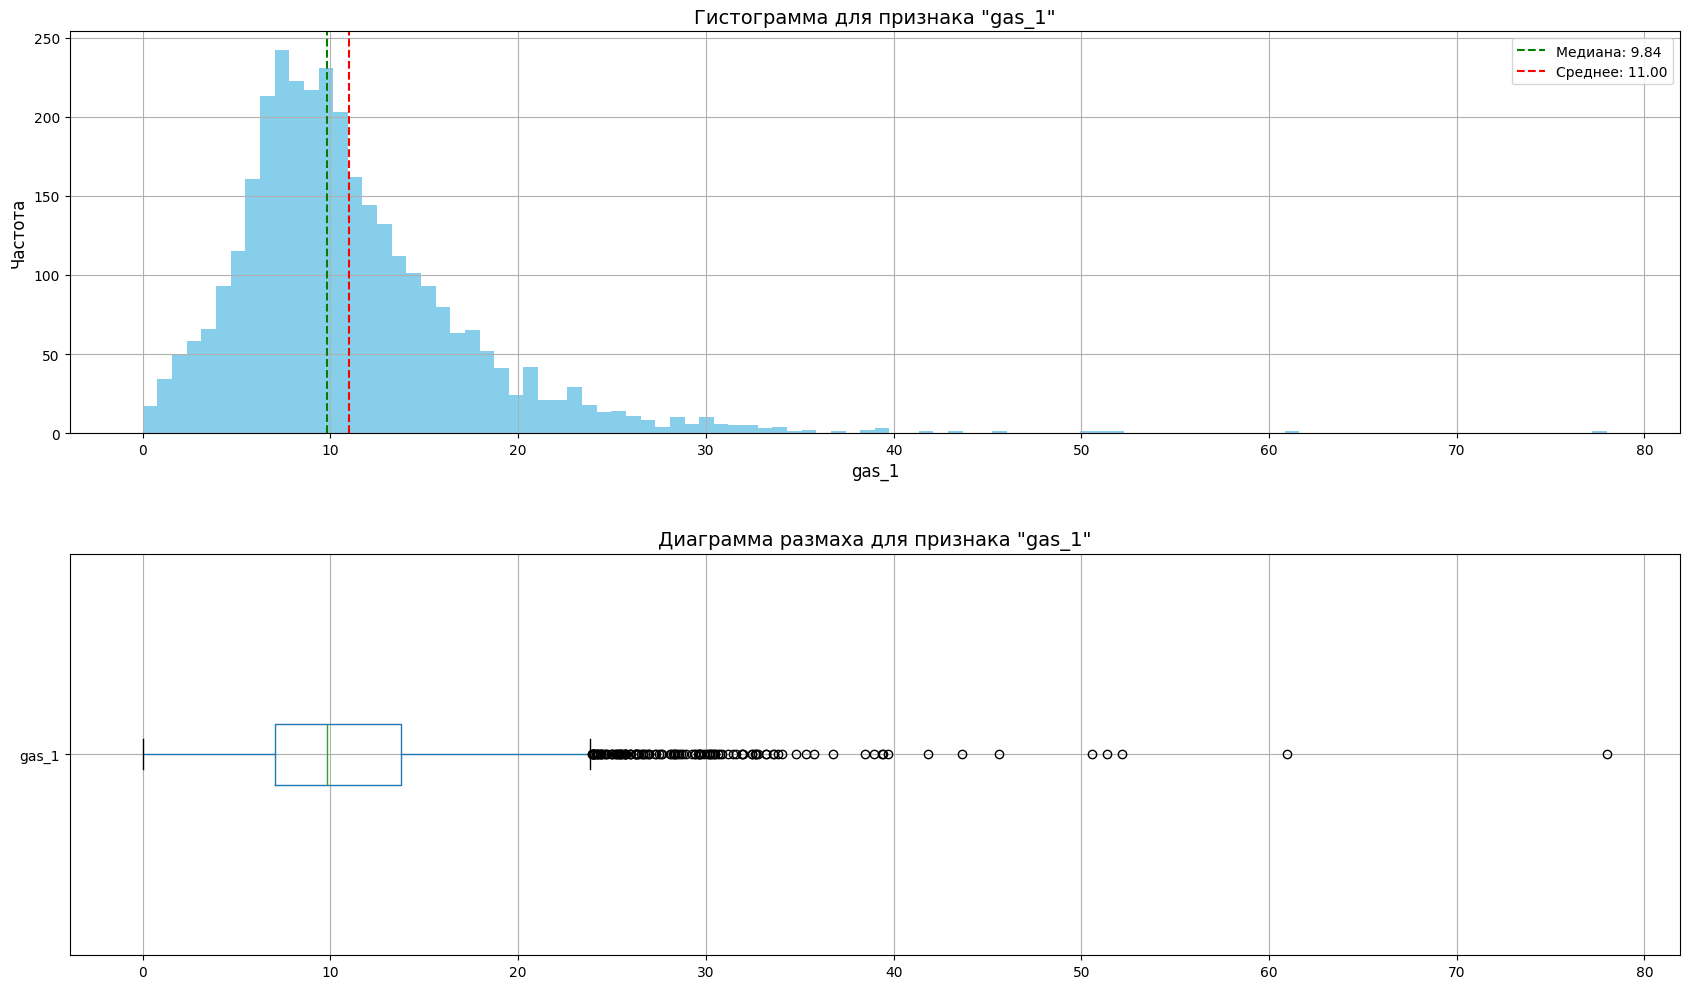

In [60]:
analyze_numerical_data(data_gas, 'gas_1', 'gas_1')

In [61]:
show_column_stats(data_gas['key'])

Уникальных значений: 3239
Минимальное значение: 1
Максимальное значение: 3241


Распределение имеет длинный правосторонний хвост, присутствуют аномально большие значения.

Диапазон значений номера партии так же от 1 до 3241. Данные уже агрегированы, аномальное значение объема газа может быть связано с тем, что данный этап для некоторых партий повторялся большее число раз.

Посмотрим на 5 самых больших значений.

In [62]:
keys = data_gas.sort_values(by=['gas_1'], ascending=False).head(5)['key'].unique()
data_arc_aggregated['count_of_heating'].describe()

,count_of_heating
count,3213.000000
mean,4.628696
std,1.608860
min,1.000000
25%,4.000000
50%,4.000000
75%,6.000000
max,16.000000


In [63]:
data_arc_aggregated[data_arc_aggregated['key'].isin(keys)]

,key,duration_of_heating,active_power_median,active_power_sum,reactive_power_median,reactive_power_sum,apparent_power_median,active_to_reactive_ratio_median,count_of_heating,full_active_energy
114,117,804,0.653095,4.191196,0.466575,2.908158,0.802723,1.419632,6,619.135781
275,280,1807,0.432047,4.248512,0.332089,2.967820,0.539869,1.339485,9,1040.907729
317,322,2658,0.623596,8.914806,0.461261,6.564143,0.775650,1.344527,13,2026.007227
2091,2110,547,0.385210,1.945132,0.298242,1.446366,0.466150,1.367191,5,266.771323
2544,2570,1104,0.542183,5.330177,0.395750,3.890786,0.655734,1.354488,9,788.885544


Действительно, данные партии нагревались большее, чем медианное значение(4), число раз. Сохраняем все значения для gas_1.

In [64]:
# записи под удаление
data_gas[data_gas['key'].isin(keys_to_delete)]

,key,gas_1
2113,2116,11.582547


In [65]:
# пропущенные партии (из общего списка)
data_gas['key'].isin(missed_keys).sum()

np.int64(113)

In [66]:
# пропущенные партии (data_gas)
missed_keys_data_gas = sorted(set(range(1, 3242)) - set(data_gas['key']))
print(missed_keys_data_gas)

[193, 259]


In [67]:
missed_keys.update(missed_keys_data_gas)
len(missed_keys)

115

### steel.data_temp - данные об измерениях температуры

In [68]:
show_general_info(data_temp)


=== Основная информация о датафрейме ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB

=== Первые 5 строк ===


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



=== Количество дубликатов ===
Полных дубликатов строк: 0

=== Пропущенные значения ===


,Количество пропусков,% пропусков
Температура,3427,18.94


In [69]:
data_temp.duplicated(subset='key').sum()

np.int64(14876)

Датасет `data_temp` содержит 18092 записей, полных дубликатов нет. Столбцы необходимо переименовать, используя латиницу, и привести названия к змеиному регистру. Типы данных определены не верно. Есть пропуски в данных о температуре.

Целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные. Поэтому для нас важно, чтобы не было пропусков в первой и последней партиях. Вернемся к этому при агрегировании данных.

In [70]:
data_temp = data_temp.rename(columns={'Время замера': 'time_temp','Температура': 'temp'})
data_temp['time_temp'] = pd.to_datetime(data_temp['time_temp'])
data_temp['temp'] = pd.to_numeric(data_temp['temp'], errors='coerce')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        18092 non-null  int64         
 1   time_temp  18092 non-null  datetime64[ns]
 2   temp       14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [71]:
show_column_stats(data_temp['time_temp'])

Уникальных значений: 18092
Минимальное значение: 2019-05-03 11:02:04
Максимальное значение: 2019-09-06 17:30:05



Статистика для 'temp':
count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temp, dtype: float64


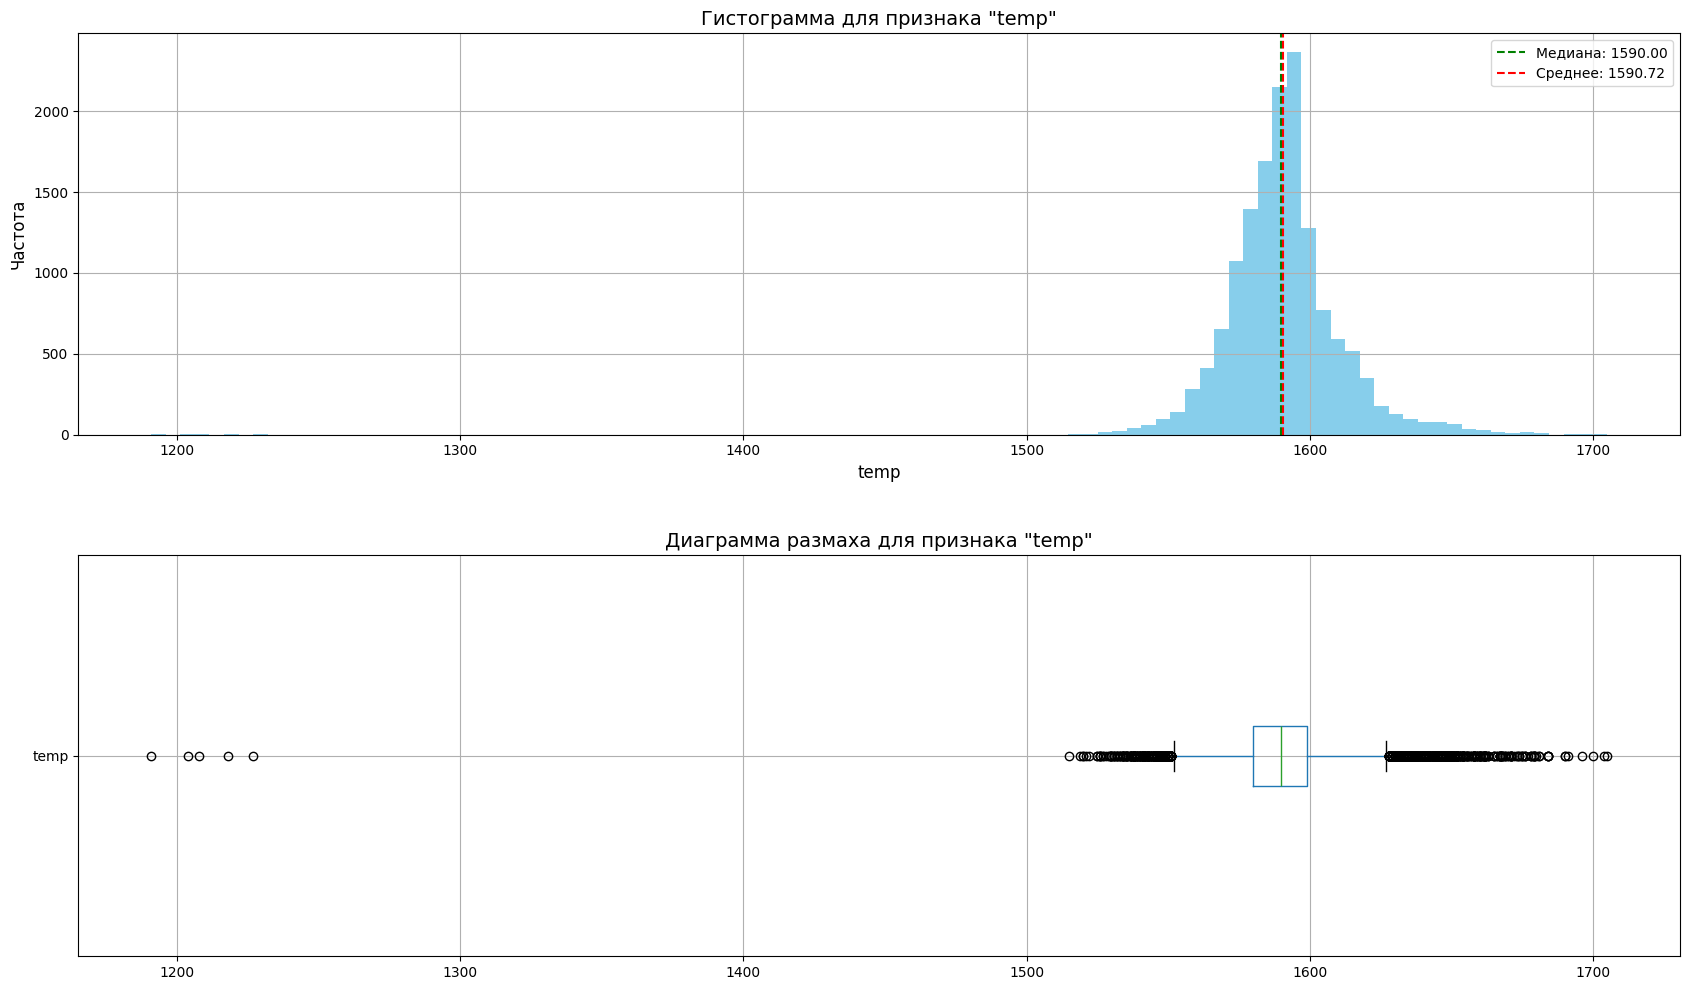

In [72]:
analyze_numerical_data(data_temp, 'temp', 'temp')

Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные (нарушают физические условия плавления и делает невозможным металлургические процессы). Для нас это означает, что дальнейшая работа с данной партией не будет проходить по стандартному сценарию, поэтому все записи о таких партиях будем удалять.

In [73]:
keys_with_low_temp = data_temp[data_temp['temp'] < 1500]['key'].unique()
keys_with_low_temp

array([ 867, 1214, 1619, 2052, 2561])

In [74]:
# количество записей на удаление
data_temp['key'].isin(keys_with_low_temp).sum()

np.int64(27)

In [75]:
keys_to_delete.update(keys_with_low_temp)
len(keys_to_delete)

6

In [76]:
data_temp = data_temp[~data_temp['key'].isin(keys_with_low_temp)]


Статистика для 'Температура':
count    14643.000000
mean      1590.865055
std         19.122102
min       1519.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temp, dtype: float64


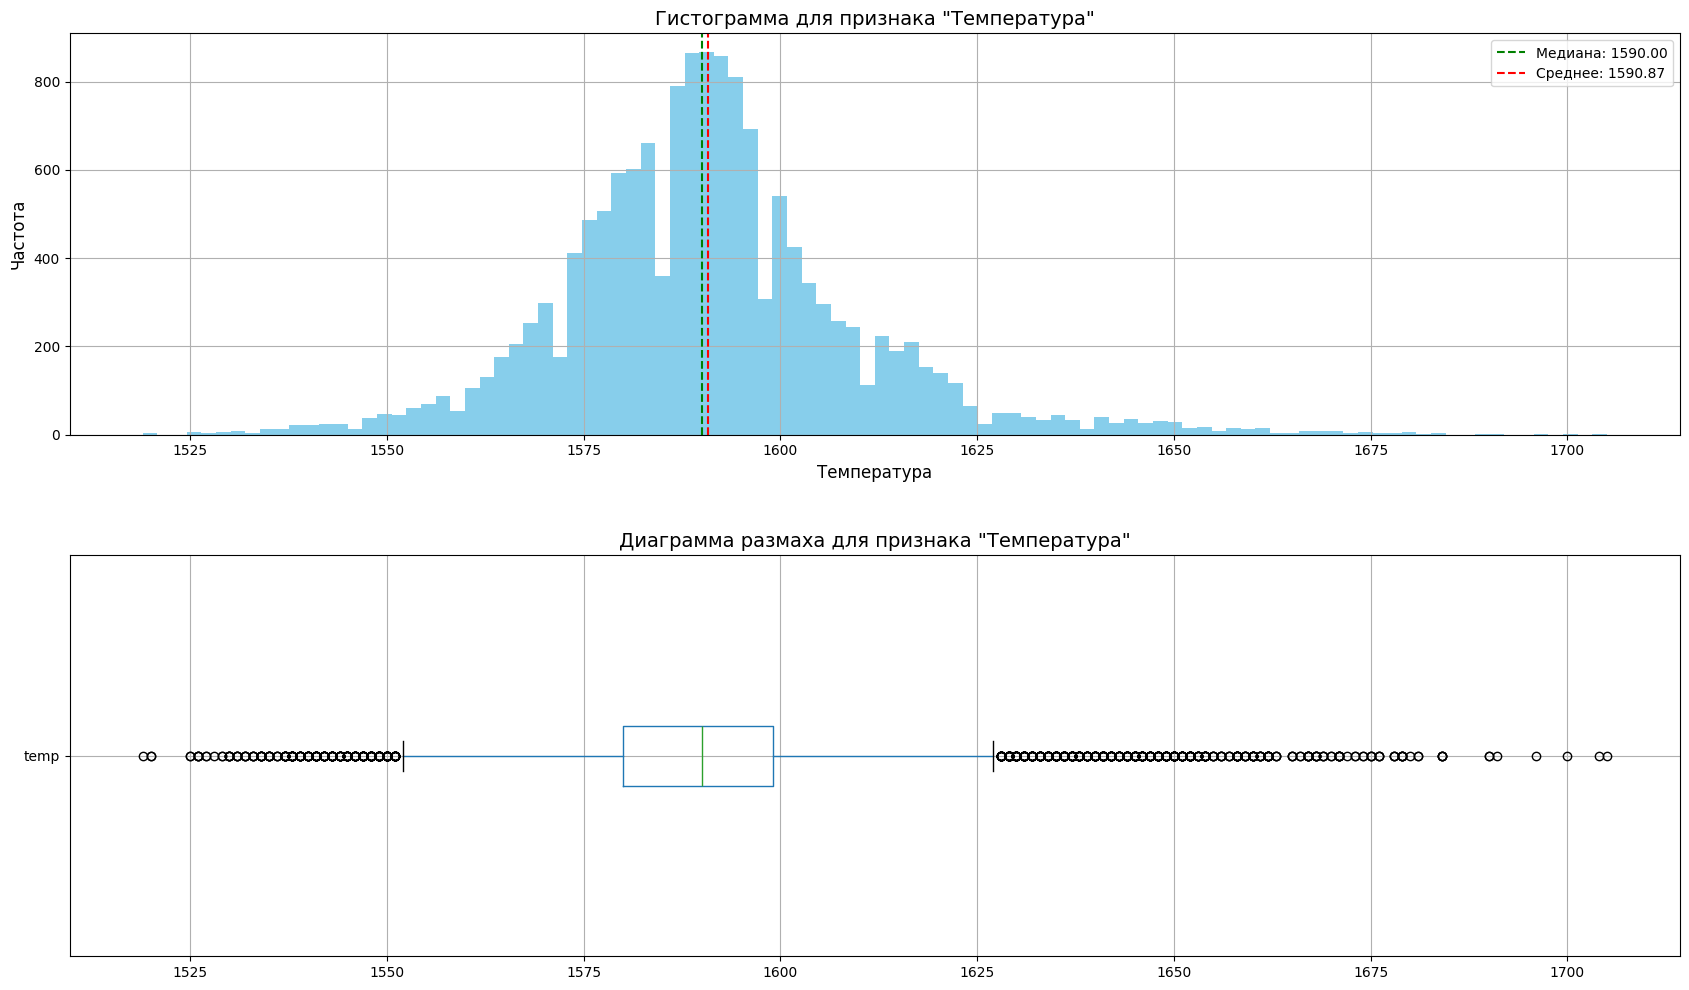

In [77]:
analyze_numerical_data(data_temp, 'temp', 'Температура')

In [78]:
show_column_stats(data_temp['key'])

Уникальных значений: 3211
Минимальное значение: 1
Максимальное значение: 3241


In [79]:
# записи под удаление (присутствуют аномалии)
data_temp[data_temp['key'].isin(keys_to_delete)]

,key,time_temp,temp
11877,2116,2019-07-28 02:07:02,1579.0
11878,2116,2019-07-28 02:13:00,1574.0
11879,2116,2019-07-28 02:21:58,1578.0
11880,2116,2019-07-28 02:29:01,1575.0
11881,2116,2019-07-28 02:35:36,1578.0


In [80]:
# число записей о пропущенных партиях (из общего списка)
data_temp['key'].isin(missed_keys).sum()

np.int64(375)

In [81]:
# пропущенные партии (data_temp)
missed_keys_data_temp = sorted(set(range(1, 3242)) - set(data_temp['key']))
print(missed_keys_data_temp)

[41, 42, 355, 382, 506, 529, 540, 607, 683, 710, 766, 867, 1133, 1214, 1300, 1437, 1619, 2031, 2052, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2561, 2683, 3200, 3207]


In [82]:
missed_keys.update(missed_keys_data_temp)
len(missed_keys)

120

In [83]:
show_column_stats(data_temp['time_temp'])

Уникальных значений: 18065
Минимальное значение: 2019-05-03 11:02:04
Максимальное значение: 2019-09-06 17:30:05


Диапазон значений времения измерений совпадает с временным диапазоном для других датасетов.

При агрегировании наблюдений используем только ключи, у которых как минимум два наблюдения: первый и последний замеры температуры. Для этого посчитаем количество измерений для каждой партии и в дальнейшем удалим лишние записи.


In [84]:
data_temp_aggregated = (
    data_temp
    .sort_values(['key', 'time_temp'])
    .groupby('key')
    .agg(
        count_of_measure=('temp', 'count'),
        temp_start=('temp', 'first'),
        temp_end=('temp', 'last'),
        date_start=('time_temp', 'first'),
        date_end=('time_temp', 'last')
        )
    .reset_index())
data_temp_aggregated.head()

,key,count_of_measure,temp_start,temp_end,date_start,date_end
0,1,6,1571.0,1613.0,2019-05-03 11:02:04,2019-05-03 11:30:38
1,2,5,1581.0,1602.0,2019-05-03 11:34:04,2019-05-03 11:55:09
2,3,6,1596.0,1599.0,2019-05-03 12:06:44,2019-05-03 12:35:57
3,4,5,1601.0,1625.0,2019-05-03 12:39:27,2019-05-03 12:59:47
4,5,5,1576.0,1602.0,2019-05-03 13:11:03,2019-05-03 13:36:39


In [85]:
# проверим, остались ли Nan в результате агрегации
data_temp_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3211 entries, 0 to 3210
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               3211 non-null   int64         
 1   count_of_measure  3211 non-null   int64         
 2   temp_start        3211 non-null   float64       
 3   temp_end          3211 non-null   float64       
 4   date_start        3211 non-null   datetime64[ns]
 5   date_end          3211 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 150.6 KB


In [86]:
# посмотрим на несколько партий, чтобы убедиться в правильности агрегации
data_temp[data_temp['key'] == 1]

,key,time_temp,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0


In [87]:
data_temp[data_temp['key'] == 3]

,key,time_temp,temp
11,3,2019-05-03 12:06:44,1596.0
12,3,2019-05-03 12:13:42,1597.0
13,3,2019-05-03 12:18:46,1598.0
14,3,2019-05-03 12:25:33,1599.0
15,3,2019-05-03 12:31:04,1600.0
16,3,2019-05-03 12:35:57,1599.0


In [88]:
data_temp[data_temp['key'] == 5]

,key,time_temp,temp
22,5,2019-05-03 13:11:03,1576.0
23,5,2019-05-03 13:18:11,1592.0
24,5,2019-05-03 13:23:22,1589.0
25,5,2019-05-03 13:32:34,1586.0
26,5,2019-05-03 13:36:39,1602.0


In [89]:
keys_one_measure = data_temp_aggregated[
    data_temp_aggregated['count_of_measure'] == 1]['key'].unique()
len(keys_one_measure)

740

In [90]:
keys_to_delete.update(keys_one_measure)
len(keys_to_delete)

746

In [91]:
data_temp_aggregated = data_temp_aggregated[~data_temp_aggregated['key'].isin(keys_one_measure)]
data_temp_aggregated.shape

(2471, 6)

In [92]:
data_temp_aggregated.loc[:, 'time_gap'] = (

    data_temp_aggregated['date_end'] - data_temp_aggregated['date_start'])\
    .dt.total_seconds().astype(int)

data_temp_aggregated['time_gap'].describe()

<ipython-input-92-a3e058df362b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_aggregated.loc[:, 'time_gap'] = (


,time_gap
count,2471.000000
mean,2281.317685
std,1374.343709
min,339.000000
25%,1544.500000
50%,2007.000000
75%,2739.500000
max,23674.000000


Временной промежуток между первым и последним измерением выглядит реалистично: от  5.7 минут до 6.6 часов. Данные адекватны. Удалим лишние признаки.

In [93]:
data_temp_aggregated = data_temp_aggregated.drop(columns=['time_gap', 'date_start', 'date_end'])

### steel.data_wire - данные об объёме проволочных материалов

In [94]:
show_general_info(data_wire)


=== Основная информация о датафрейме ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB

=== Первые 5 строк ===


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None



=== Количество дубликатов ===
Полных дубликатов строк: 0

=== Пропущенные значения ===


,Количество пропусков,% пропусков
Wire 1,26,0.84
Wire 2,2002,64.98
Wire 3,3018,97.96
Wire 4,3067,99.55
Wire 5,3080,99.97
Wire 6,3008,97.63
Wire 7,3070,99.64
Wire 8,3062,99.38
Wire 9,3052,99.06


In [95]:
data_wire.duplicated(subset='key').sum()

np.int64(0)

Датасет `data_wire` содержит 3081 запись, полных дубликатов нет. Столбцы необходимо переименовать и привести названия к змеиному регистру. Типы данных определены не верно. Номер партии `key` представлен числом, значения не повторяются. Присутствуют пропуски. Пропуск означает, что материал не добавляли в эту партию. Заполним пропуски нулями.

In [96]:
new_columns = [col.lower().replace(' ', '_') for col in data_wire.columns]
data_wire.columns = new_columns
data_wire = data_wire.fillna(0)

In [97]:
num_columns = [col for col in data_wire.columns if col != 'key']

for col in num_columns:
    data_wire[col] = pd.to_numeric(data_wire[col], errors='coerce')

data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [98]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Все проволочные материалы подавались хотя бы раз. В основном использовался первый материал (ненулевое значение медианы), реже - второй( ненулевое значение 75ого процентиля). Для остальных материалов распределения сильно скошены,большинство значений - 0, но есть редкие высокие значения.

Т.к. нетипичные значения связаны с тем, что могут подаваться только некоторые из материалов (это реальные данные процесса), оставим их в датасете.

In [99]:
# поищем строки, где для всех материалов объем равен нулю
zero_rows = data_wire[(data_wire[num_columns] == 0).all(axis=1)]
print("Найдено строк с общим нулевым объемом проволочных материалов:",
      len(zero_rows))

Найдено строк с общим нулевым объемом проволочных материалов: 0


In [100]:
# число записей о партиях с аномалиями
data_wire[data_wire['key'].isin(keys_to_delete)].shape[0]

714

In [101]:
show_column_stats(data_wire['key'])

Уникальных значений: 3081
Минимальное значение: 1
Максимальное значение: 3241


In [102]:
# число записей о пропущенных партиях (из общего списка)
data_wire['key'].isin(missed_keys).sum()

np.int64(64)

In [103]:
# пропущенные партии (data_bulk)
missed_keys_data_wire = sorted(set(range(1, 3242)) - set(data_wire['key']))
print(missed_keys_data_wire)

[41, 42, 51, 52, 53, 54, 55, 56, 81, 82, 83, 84, 85, 88, 109, 195, 197, 209, 210, 211, 212, 269, 330, 331, 332, 355, 375, 376, 377, 378, 382, 506, 529, 540, 607, 683, 710, 711, 712, 713, 714, 715, 744, 748, 754, 755, 766, 796, 797, 798, 799, 800, 841, 929, 930, 931, 932, 933, 934, 1102, 1103, 1104, 1105, 1106, 1107, 1133, 1184, 1300, 1379, 1380, 1437, 1525, 1526, 1527, 1528, 1564, 1565, 1566, 1646, 1743, 1744, 1745, 1746, 1747, 1748, 1758, 1817, 1818, 1836, 1946, 1977, 1978, 1979, 2010, 2031, 2043, 2103, 2195, 2196, 2197, 2198, 2214, 2215, 2216, 2217, 2218, 2219, 2236, 2238, 2278, 2356, 2360, 2367, 2368, 2369, 2370, 2373, 2388, 2389, 2390, 2391, 2392, 2393, 2446, 2469, 2491, 2624, 2625, 2626, 2627, 2628, 2629, 2683, 2788, 2789, 2790, 2791, 2792, 2814, 2815, 2846, 2847, 2848, 2849, 2850, 2863, 2871, 2872, 2873, 2874, 2875, 2876, 3035, 3036, 3037, 3038, 3039, 3040, 3200, 3207]


In [104]:
missed_keys.update(missed_keys_data_wire)
len(missed_keys)

224

Число уникальных значений совпадает с количеством записей - перед нами агрегированные данные (либо для всех партий подача осуществлялась только раз).

Диапазон значений номеров партий совпадает с другими датасетами, однако также есть партии, о которых нет записей. Номера таких партий добавили в общее множество.

### steel.data_wire_time - данные о времени подачи проволочных материалов

In [105]:
show_general_info(data_wire_time)


=== Основная информация о датафрейме ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

=== Первые 5 строк ===


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None



=== Количество дубликатов ===
Полных дубликатов строк: 0

=== Пропущенные значения ===


,Количество пропусков,% пропусков
Wire 1,26,0.84
Wire 2,2002,64.98
Wire 3,3018,97.96
Wire 4,3067,99.55
Wire 5,3080,99.97
Wire 6,3008,97.63
Wire 7,3070,99.64
Wire 8,3062,99.38
Wire 9,3052,99.06


In [106]:
data_wire_time.duplicated(subset='key').sum()

np.int64(0)

Датасет `data_wire_time` содержит 3081 запись, полных дубликатов нет. Столбцы необходимо переименовать, используя латиницу, и привести названия к змеиному регистру. Типы данных определены не верно. Номер партии `key` представлен числом, повторяющихся значений нет. Можно предположить, что пропуски означают, что материал не добавляли в партию.

На данный момент кажется, что информация о времени подачи проволочных материалов не понадобится для нашей модели.

In [107]:
new_columns = [col.lower().replace(' ', '_') for col in data_wire_time.columns]
data_wire_time.columns = new_columns

In [108]:
wire_columns = [col for col in data_wire_time.columns if col != 'key']
for col in wire_columns:
    data_wire_time[col] = pd.to_datetime(data_wire_time[col])

In [109]:
analyze_time_columns(data_wire_time, wire_columns)

=== Анализ столбца wire_1 ===

Минимальное время: 2019-05-03 11:06:19
Максимальное время: 2019-09-06 17:10:06
Количество уникальных значений: 3055
Уникальные значения: <DatetimeArray>
['2019-05-03 11:06:19', '2019-05-03 11:36:50', '2019-05-03 12:11:46',
 '2019-05-03 12:43:22', '2019-05-03 13:20:44', '2019-05-03 13:57:27',
 '2019-05-03 14:18:58', '2019-05-03 15:01:30', '2019-05-03 15:45:44',
 '2019-05-03 16:27:00',
 ...
 '2019-09-06 08:43:49', '2019-09-06 09:18:31', '2019-09-06 09:43:47',
 '2019-09-06 10:21:23', '2019-09-06 10:57:48', '2019-09-06 11:33:38',
 '2019-09-06 12:18:35', '2019-09-06 14:36:11', '2019-09-06 15:33:55',
 '2019-09-06 17:10:06']
Length: 3056, dtype: datetime64[ns]


=== Анализ столбца wire_2 ===

Минимальное время: 2019-05-03 13:15:34
Максимальное время: 2019-09-06 07:35:40
Количество уникальных значений: 1079
Уникальные значения: <DatetimeArray>
[                'NaT', '2019-05-03 13:15:34', '2019-05-03 13:48:52',
 '2019-05-03 15:39:37', '2019-05-03 16:22:36', '201

Диапазон времени подачи проволочных материалов близок к временным диапазонам других датасетов, что подтверждает соответствие данных.

In [110]:
show_column_stats(data_wire_time['key'])

Уникальных значений: 3081
Минимальное значение: 1
Максимальное значение: 3241


In [111]:
# пропущенные партии (data_wire_time)
missed_keys_data_wire_time = sorted(set(range(1, 3242)) - set(data_wire_time['key']))
print(missed_keys_data_wire_time)

[41, 42, 51, 52, 53, 54, 55, 56, 81, 82, 83, 84, 85, 88, 109, 195, 197, 209, 210, 211, 212, 269, 330, 331, 332, 355, 375, 376, 377, 378, 382, 506, 529, 540, 607, 683, 710, 711, 712, 713, 714, 715, 744, 748, 754, 755, 766, 796, 797, 798, 799, 800, 841, 929, 930, 931, 932, 933, 934, 1102, 1103, 1104, 1105, 1106, 1107, 1133, 1184, 1300, 1379, 1380, 1437, 1525, 1526, 1527, 1528, 1564, 1565, 1566, 1646, 1743, 1744, 1745, 1746, 1747, 1748, 1758, 1817, 1818, 1836, 1946, 1977, 1978, 1979, 2010, 2031, 2043, 2103, 2195, 2196, 2197, 2198, 2214, 2215, 2216, 2217, 2218, 2219, 2236, 2238, 2278, 2356, 2360, 2367, 2368, 2369, 2370, 2373, 2388, 2389, 2390, 2391, 2392, 2393, 2446, 2469, 2491, 2624, 2625, 2626, 2627, 2628, 2629, 2683, 2788, 2789, 2790, 2791, 2792, 2814, 2815, 2846, 2847, 2848, 2849, 2850, 2863, 2871, 2872, 2873, 2874, 2875, 2876, 3035, 3036, 3037, 3038, 3039, 3040, 3200, 3207]


In [112]:
# совпадают ли номера пропущенных партий с номерам из data_wire
set(missed_keys_data_wire_time) == set(missed_keys_data_wire)

True

Отсутствуют данные о тех же записях, что и в data_wire.

### Объединение таблиц

#### Очистка данных

Удалим партии с найденными аномалиями в данных из датасетов, которые будем использовать. Датасеты data_bulk_time и data_wire_time не понадобятся.

In [113]:
data_arc_aggregated = data_arc_aggregated[~data_arc_aggregated['key'].isin(keys_to_delete)]
data_bulk = data_bulk[~data_bulk['key'].isin(keys_to_delete)]
data_gas = data_gas[~data_gas['key'].isin(keys_to_delete)]
data_temp_aggregated = data_temp_aggregated[~data_temp_aggregated['key'].isin(keys_to_delete)]
data_wire = data_wire[~data_wire['key'].isin(keys_to_delete)]

In [114]:
merged_data = (
    data_arc_aggregated
    .merge(data_bulk, on='key', how='inner')
    .merge(data_gas, on='key', how='inner')
    .merge(data_temp_aggregated, on='key', how='inner')
    .merge(data_wire, on='key', how='inner')
)

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   key                              2324 non-null   int64  
 1   duration_of_heating              2324 non-null   int64  
 2   active_power_median              2324 non-null   float64
 3   active_power_sum                 2324 non-null   float64
 4   reactive_power_median            2324 non-null   float64
 5   reactive_power_sum               2324 non-null   float64
 6   apparent_power_median            2324 non-null   float64
 7   active_to_reactive_ratio_median  2324 non-null   float64
 8   count_of_heating                 2324 non-null   int64  
 9   full_active_energy               2324 non-null   float64
 10  bulk_1                           2324 non-null   int64  
 11  bulk_2                           2324 non-null   int64  
 12  bulk_3              

In [115]:
# убедимся, что пропущенный партии не попали в итоговый датасет
merged_data['key'].isin(missed_keys).sum() == 0

np.True_

In [116]:
# убедимся, что в итоговом датасете нет дубликатов по ключу
merged_data.duplicated(subset='key').sum() == 0

np.True_

#### Создание признаков

Для столбцов `bulk_` и `wire_` посчитаем суммарный объем сыпучих и суммарный объем проволочных материалов, оставим в датасете только самые используемые материалы. Также вычислим полную мощность для агрегированных данных

In [117]:
merged_data['bulk_sum'] = merged_data[bulk_columns].sum(axis=1)
merged_data['wire_sum'] = merged_data[wire_columns].sum(axis=1)

bulk_to_drop = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
                'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_13']
wire_to_drop = ['wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
                'wire_7', 'wire_8', 'wire_9']
merged_data = merged_data.drop(columns=bulk_to_drop + wire_to_drop)

merged_data['apparent_power'] = np.sqrt(
    merged_data['active_power_sum']**2 + merged_data['reactive_power_sum']**2)
merged_data.head()

,key,duration_of_heating,active_power_median,active_power_sum,reactive_power_median,reactive_power_sum,apparent_power_median,active_to_reactive_ratio_median,count_of_heating,full_active_energy,...,bulk_14,bulk_15,gas_1,count_of_measure,temp_start,temp_end,wire_1,bulk_sum,wire_sum,apparent_power
0,1,1098,0.580313,3.036730,0.430460,2.142821,0.722536,1.364539,5,770.282114,...,150,154,29.749986,6,1571.0,1613.0,60.059998,553,60.059998,3.716640
1,2,811,0.545710,2.139408,0.352656,1.453357,0.650151,1.457020,4,481.760005,...,149,154,12.555561,5,1581.0,1602.0,96.052315,582,96.052315,2.586371
2,3,655,0.774632,4.063641,0.505690,2.937457,0.925082,1.415997,5,722.837668,...,152,153,28.554793,6,1596.0,1599.0,91.160157,544,91.160157,5.014163
3,4,741,0.753970,2.706489,0.580275,2.056992,0.954624,1.303153,4,683.455597,...,153,154,18.841219,5,1601.0,1625.0,89.063515,595,89.063515,3.399456
4,5,869,0.517715,2.252950,0.374041,1.687991,0.639021,1.328578,4,512.169934,...,151,152,5.413692,5,1576.0,1602.0,89.238236,584,98.352796,2.815155


#### Исследовательский анализ данных объединённой таблицы

In [118]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   key                              2324 non-null   int64  
 1   duration_of_heating              2324 non-null   int64  
 2   active_power_median              2324 non-null   float64
 3   active_power_sum                 2324 non-null   float64
 4   reactive_power_median            2324 non-null   float64
 5   reactive_power_sum               2324 non-null   float64
 6   apparent_power_median            2324 non-null   float64
 7   active_to_reactive_ratio_median  2324 non-null   float64
 8   count_of_heating                 2324 non-null   int64  
 9   full_active_energy               2324 non-null   float64
 10  bulk_12                          2324 non-null   int64  
 11  bulk_14                          2324 non-null   int64  
 12  bulk_15             

В итоговый датасет вошли данные о 2324 партиях.

count_of_heating


,count_of_heating
count,2324.000000
mean,4.696644
std,1.606210
min,1.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,16.000000


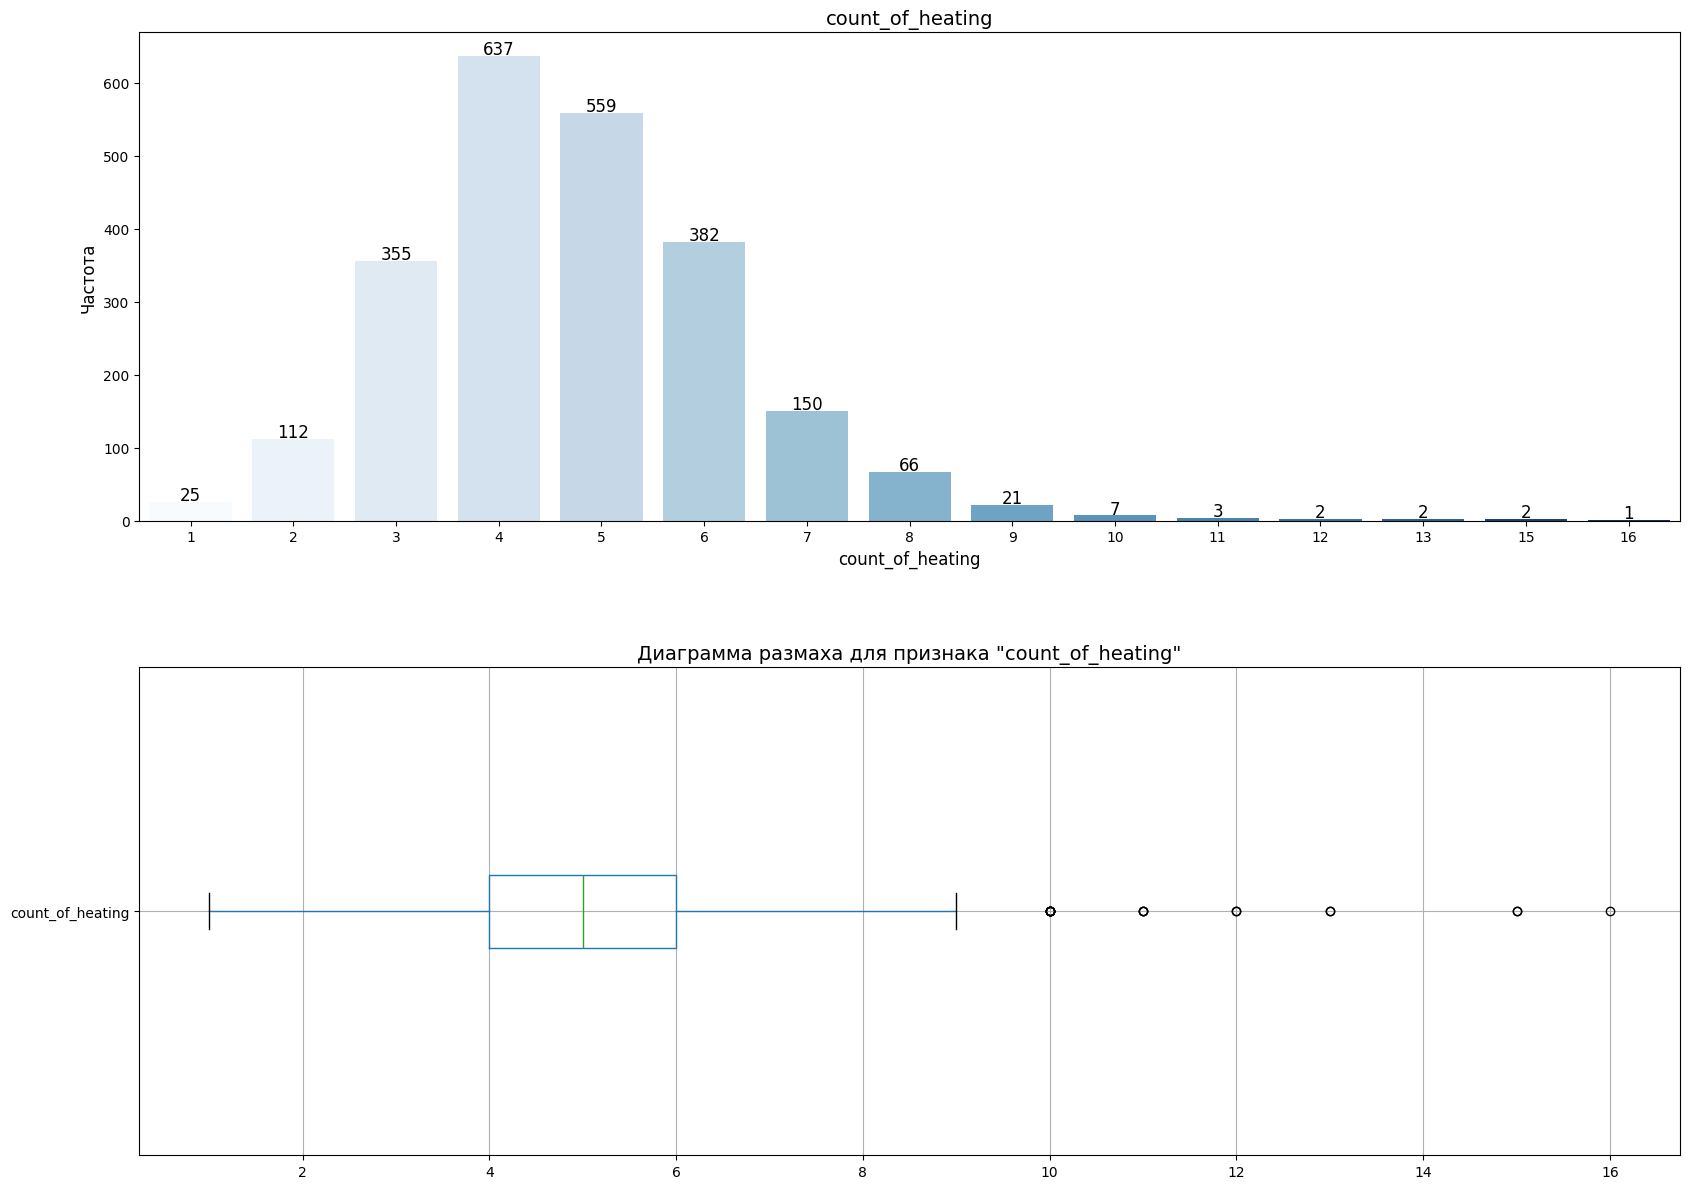

count_of_measure


,count_of_measure
count,2324.000000
mean,5.696644
std,1.606210
min,2.000000
25%,5.000000
50%,6.000000
75%,7.000000
max,17.000000


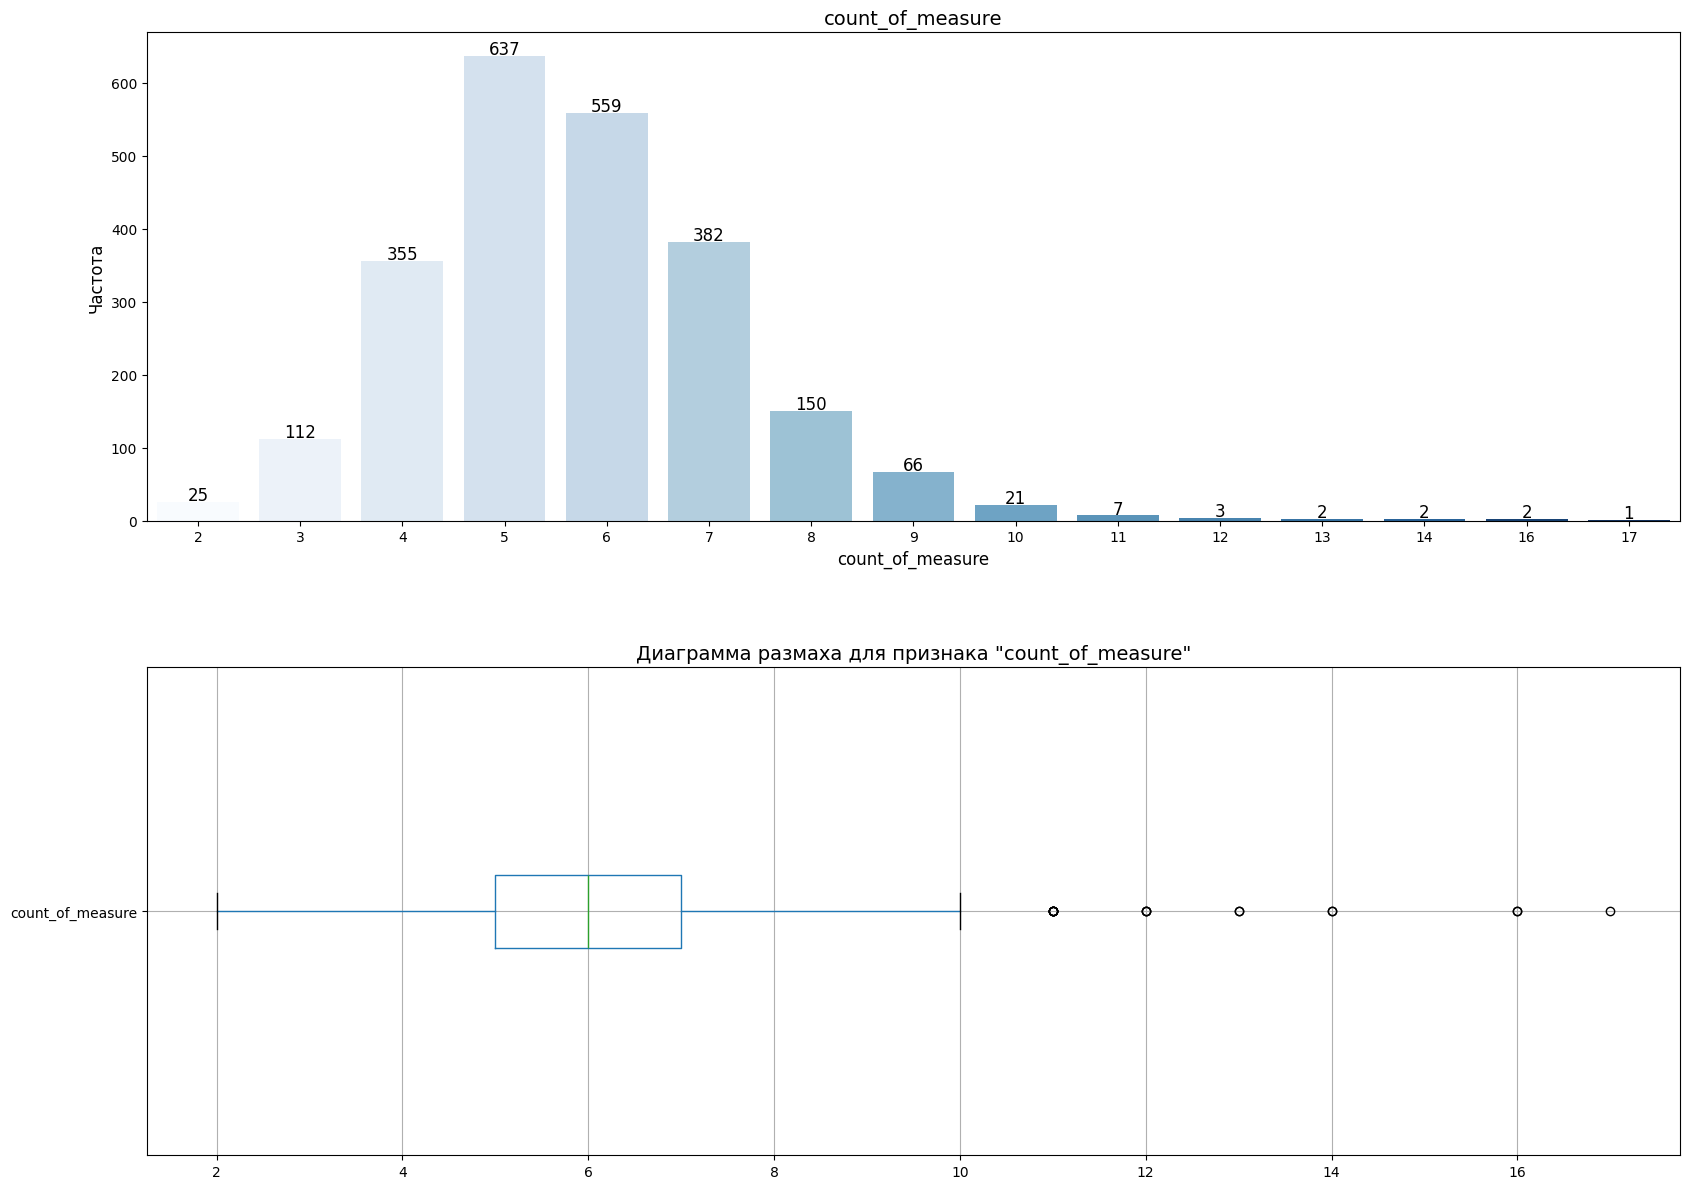

In [119]:
for col in ['count_of_heating', 'count_of_measure']:
    analyze_discrete_data(merged_data, col, col)


Статистика для 'duration_of_heating':
count    2324.000000
mean      808.196644
std       340.813828
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: duration_of_heating, dtype: float64


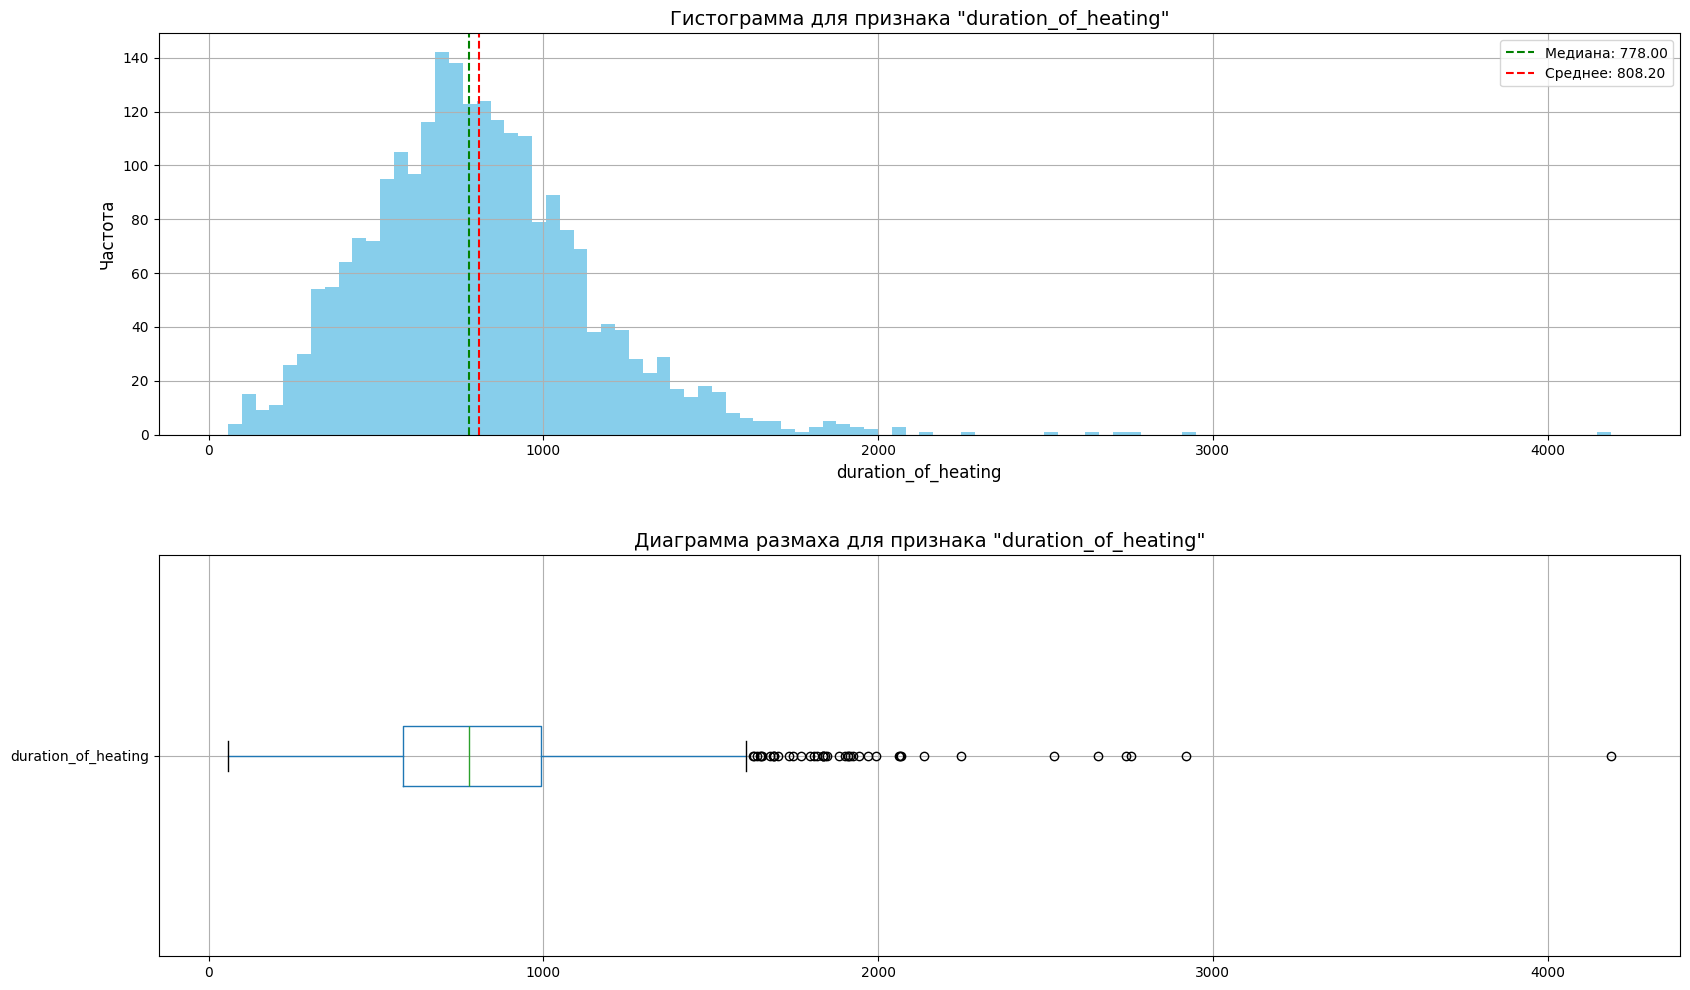


Статистика для 'active_power_median':
count    2324.000000
mean        0.635602
std         0.151666
min         0.235282
25%         0.521444
50%         0.614729
75%         0.725333
max         1.268378
Name: active_power_median, dtype: float64


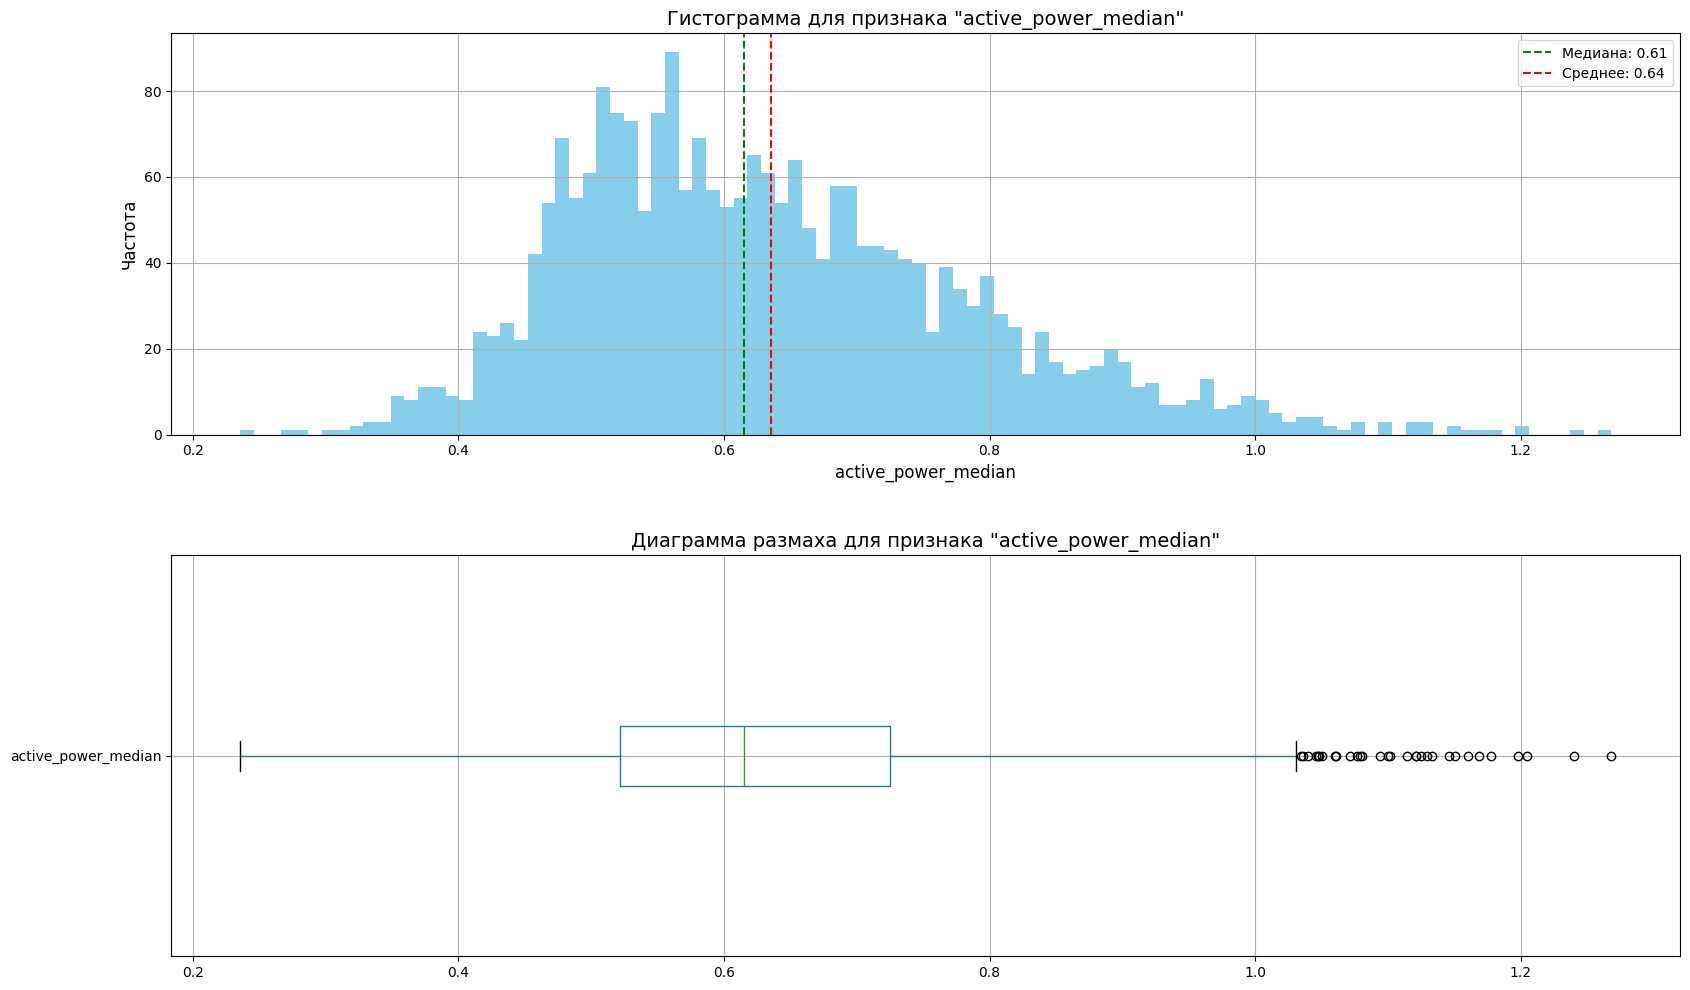


Статистика для 'active_power_sum':
count    2324.000000
mean        3.126327
std         1.220484
min         0.267676
25%         2.295960
50%         3.036517
75%         3.834302
max        12.375636
Name: active_power_sum, dtype: float64


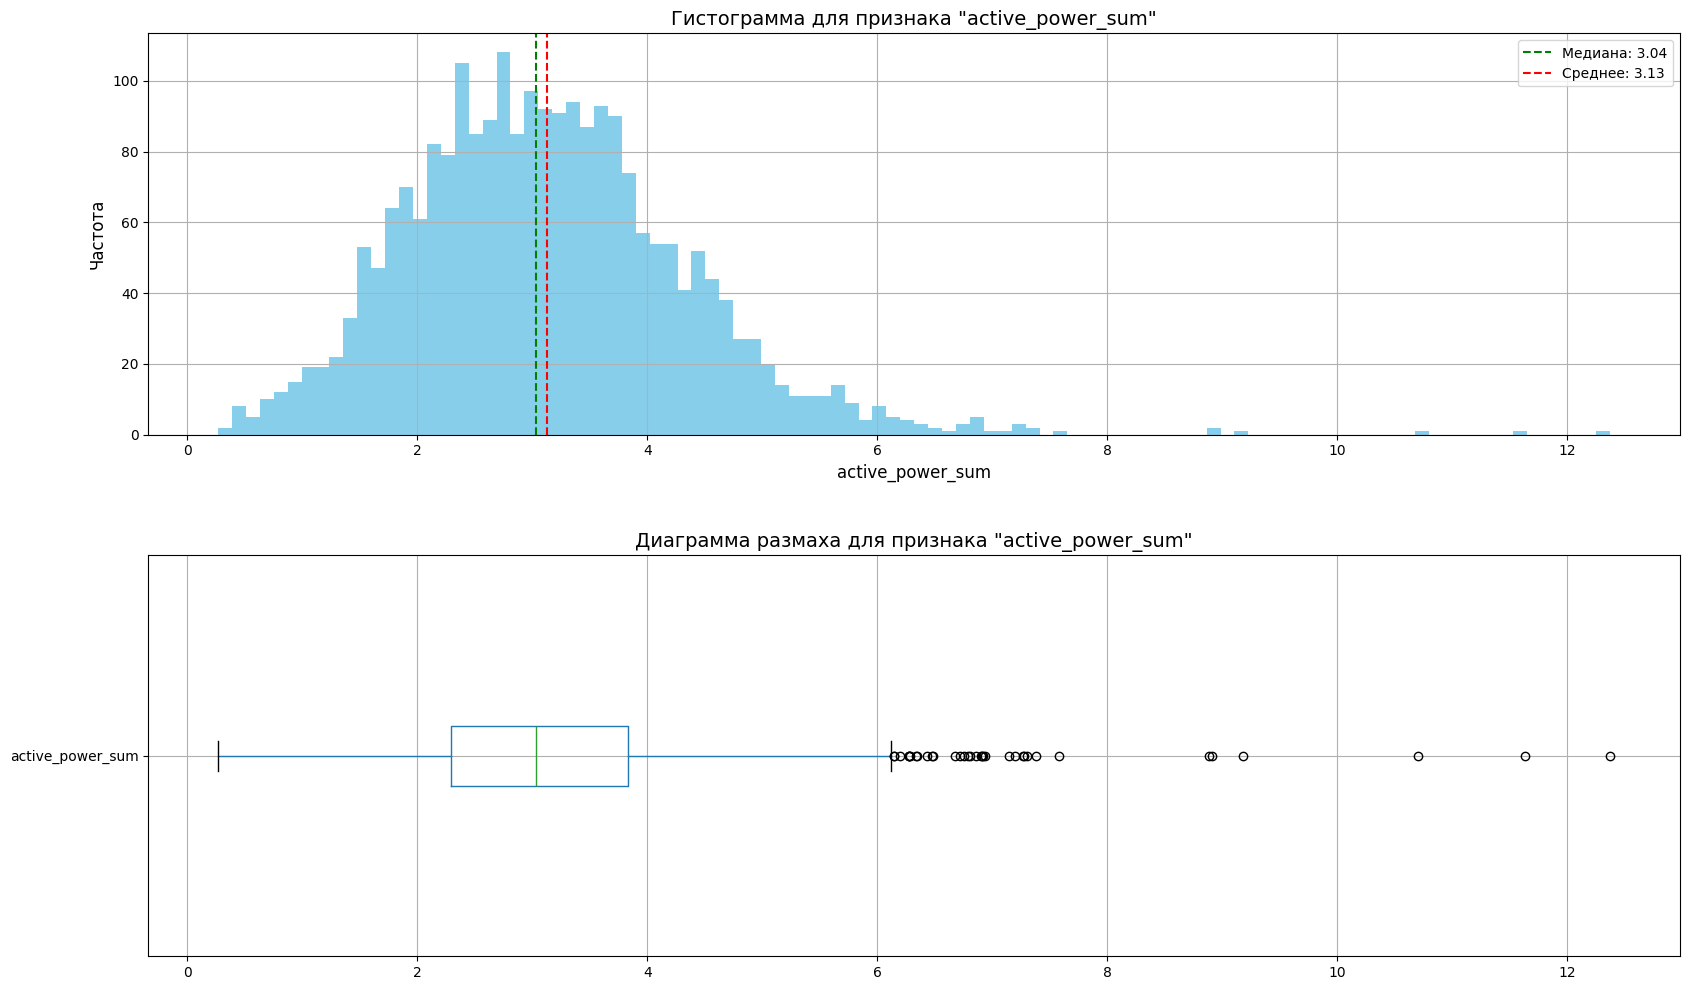


Статистика для 'reactive_power_median':
count    2324.000000
mean        0.466422
std         0.113346
min         0.167425
25%         0.382402
50%         0.452083
75%         0.535037
max         0.995877
Name: reactive_power_median, dtype: float64


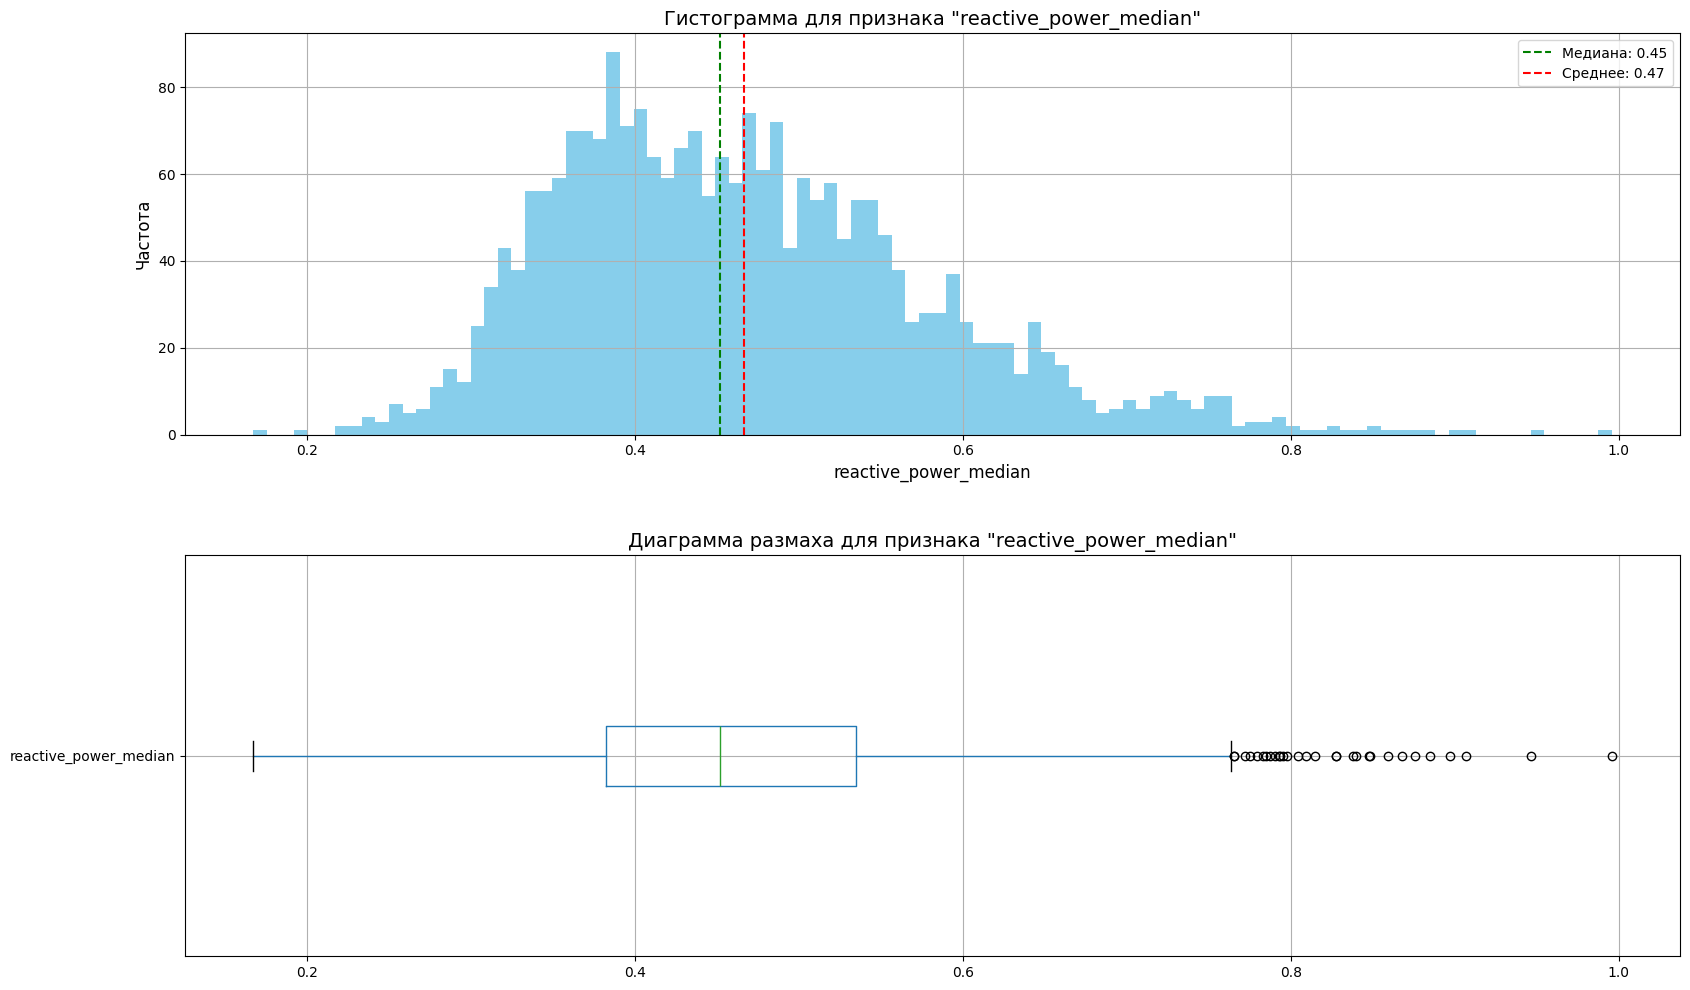


Статистика для 'reactive_power_sum':
count    2324.000000
mean        2.301280
std         0.903711
min         0.196228
25%         1.671099
50%         2.225900
75%         2.829179
max         8.949049
Name: reactive_power_sum, dtype: float64


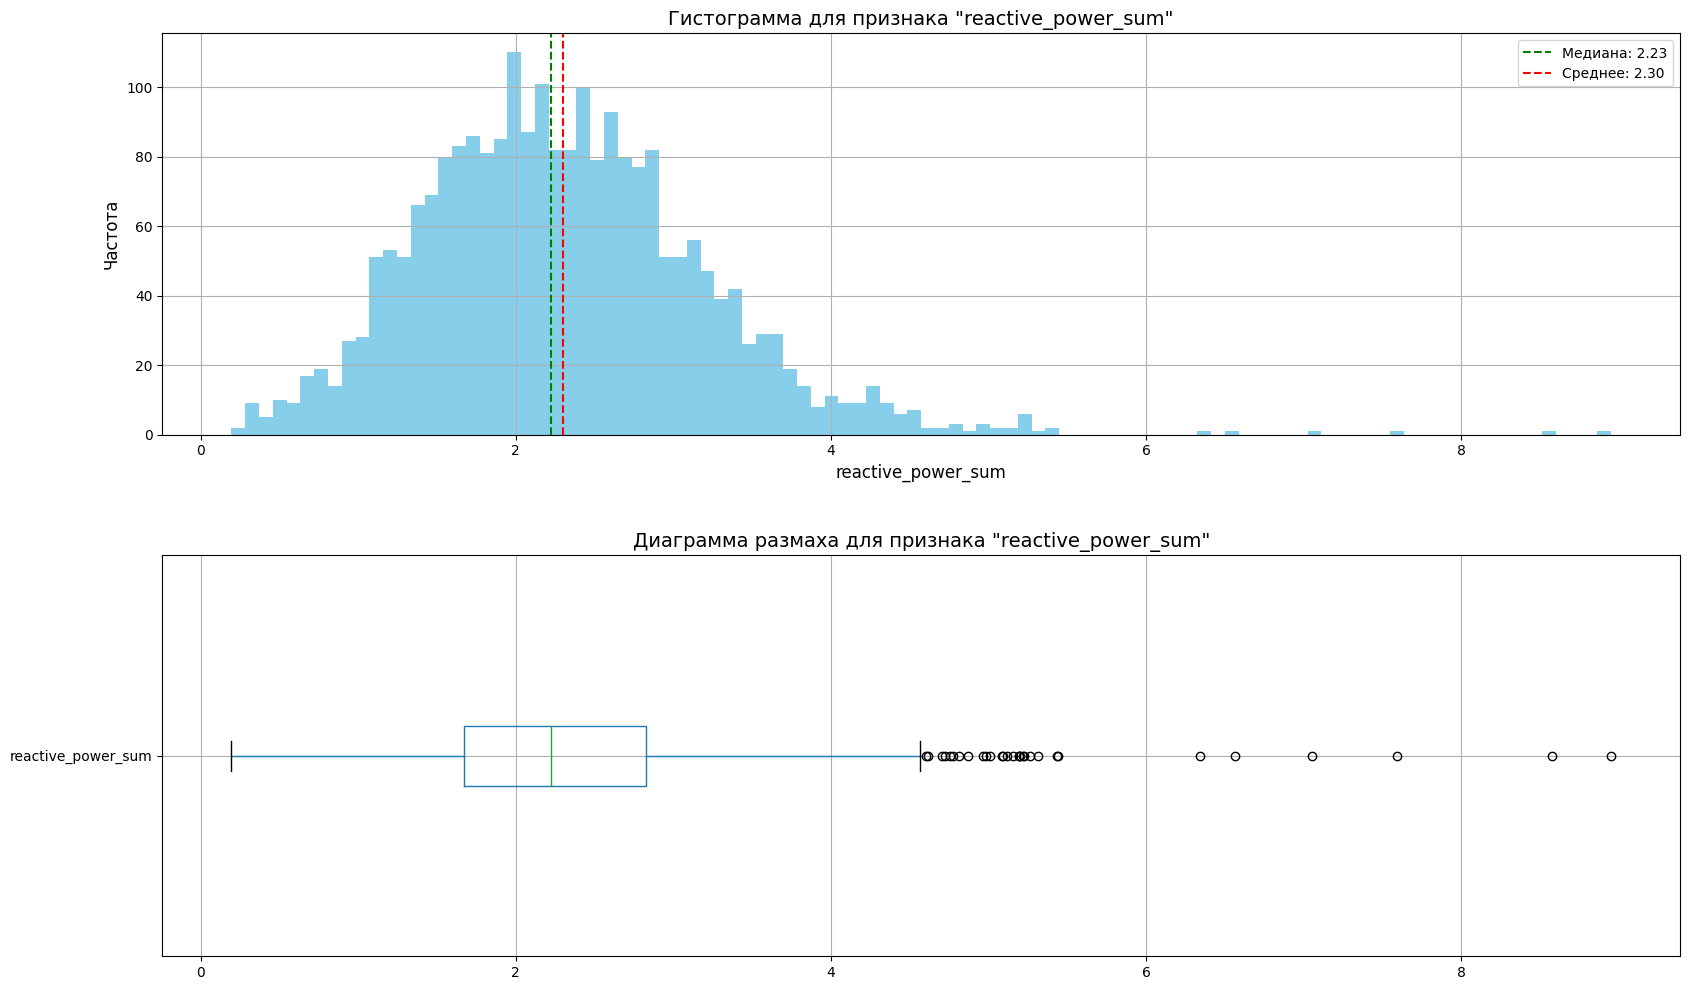


Статистика для 'apparent_power_median':
count    2324.000000
mean        0.789534
std         0.188725
min         0.288771
25%         0.647567
50%         0.764380
75%         0.901291
max         1.581864
Name: apparent_power_median, dtype: float64


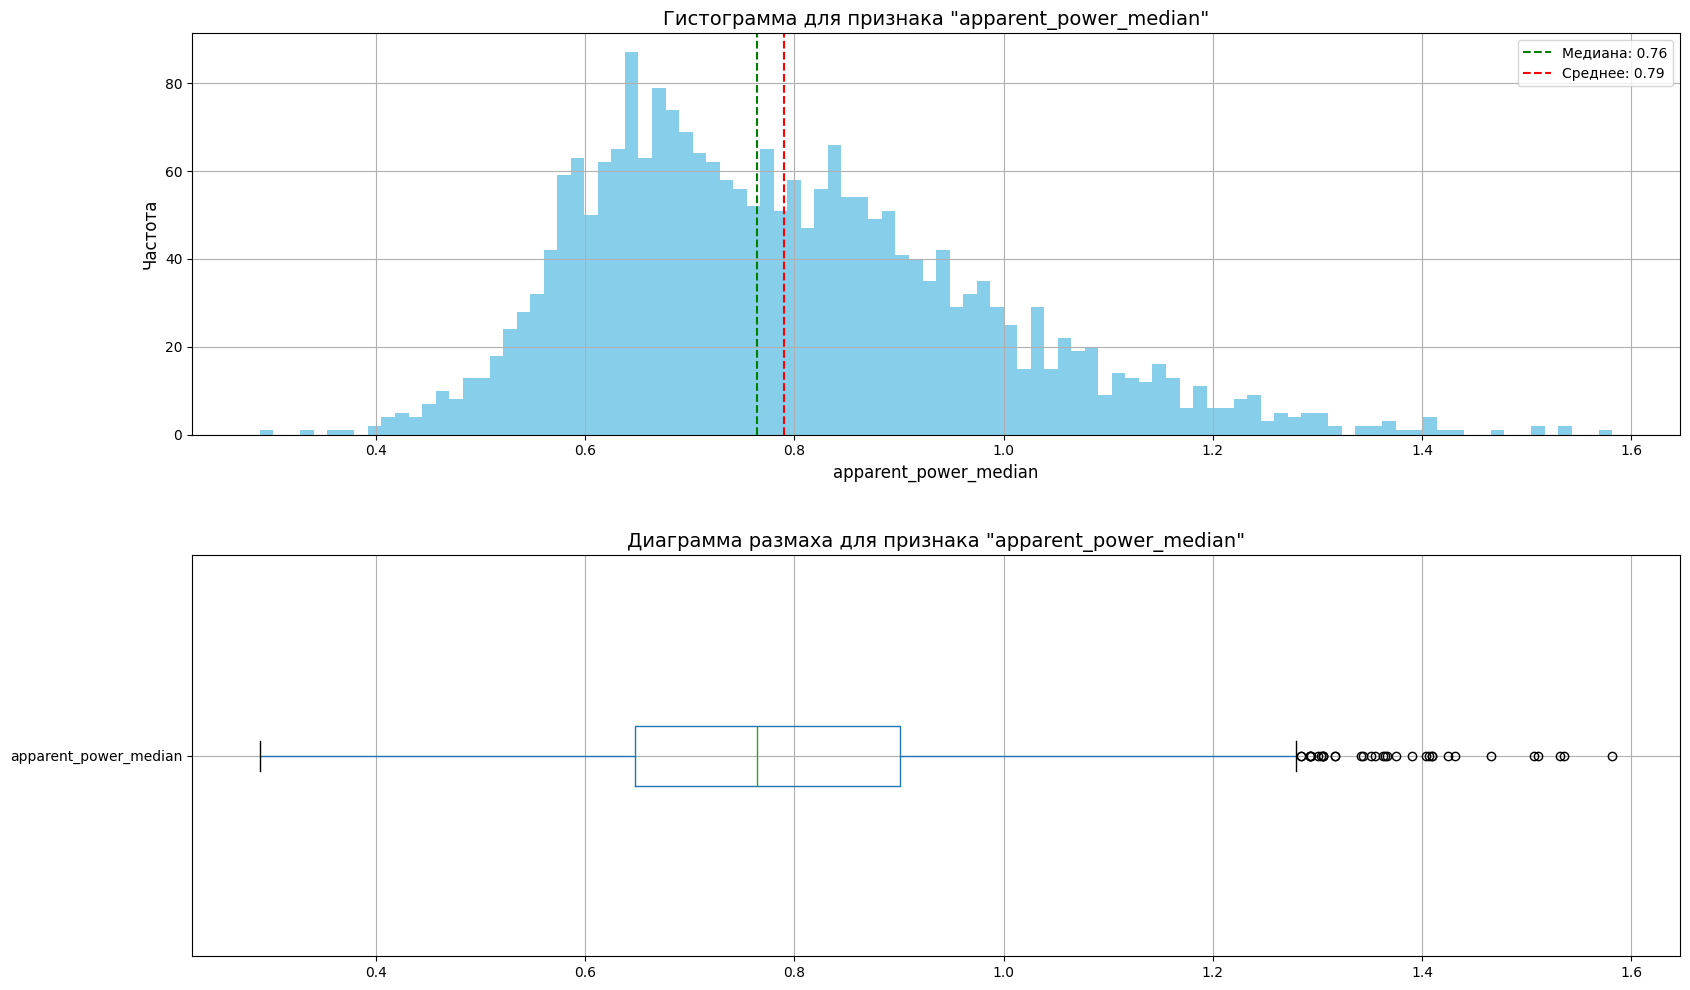


Статистика для 'active_to_reactive_ratio_median':
count    2324.000000
mean        1.374524
std         0.077356
min         1.099589
25%         1.325689
50%         1.376918
75%         1.425649
max         1.663366
Name: active_to_reactive_ratio_median, dtype: float64


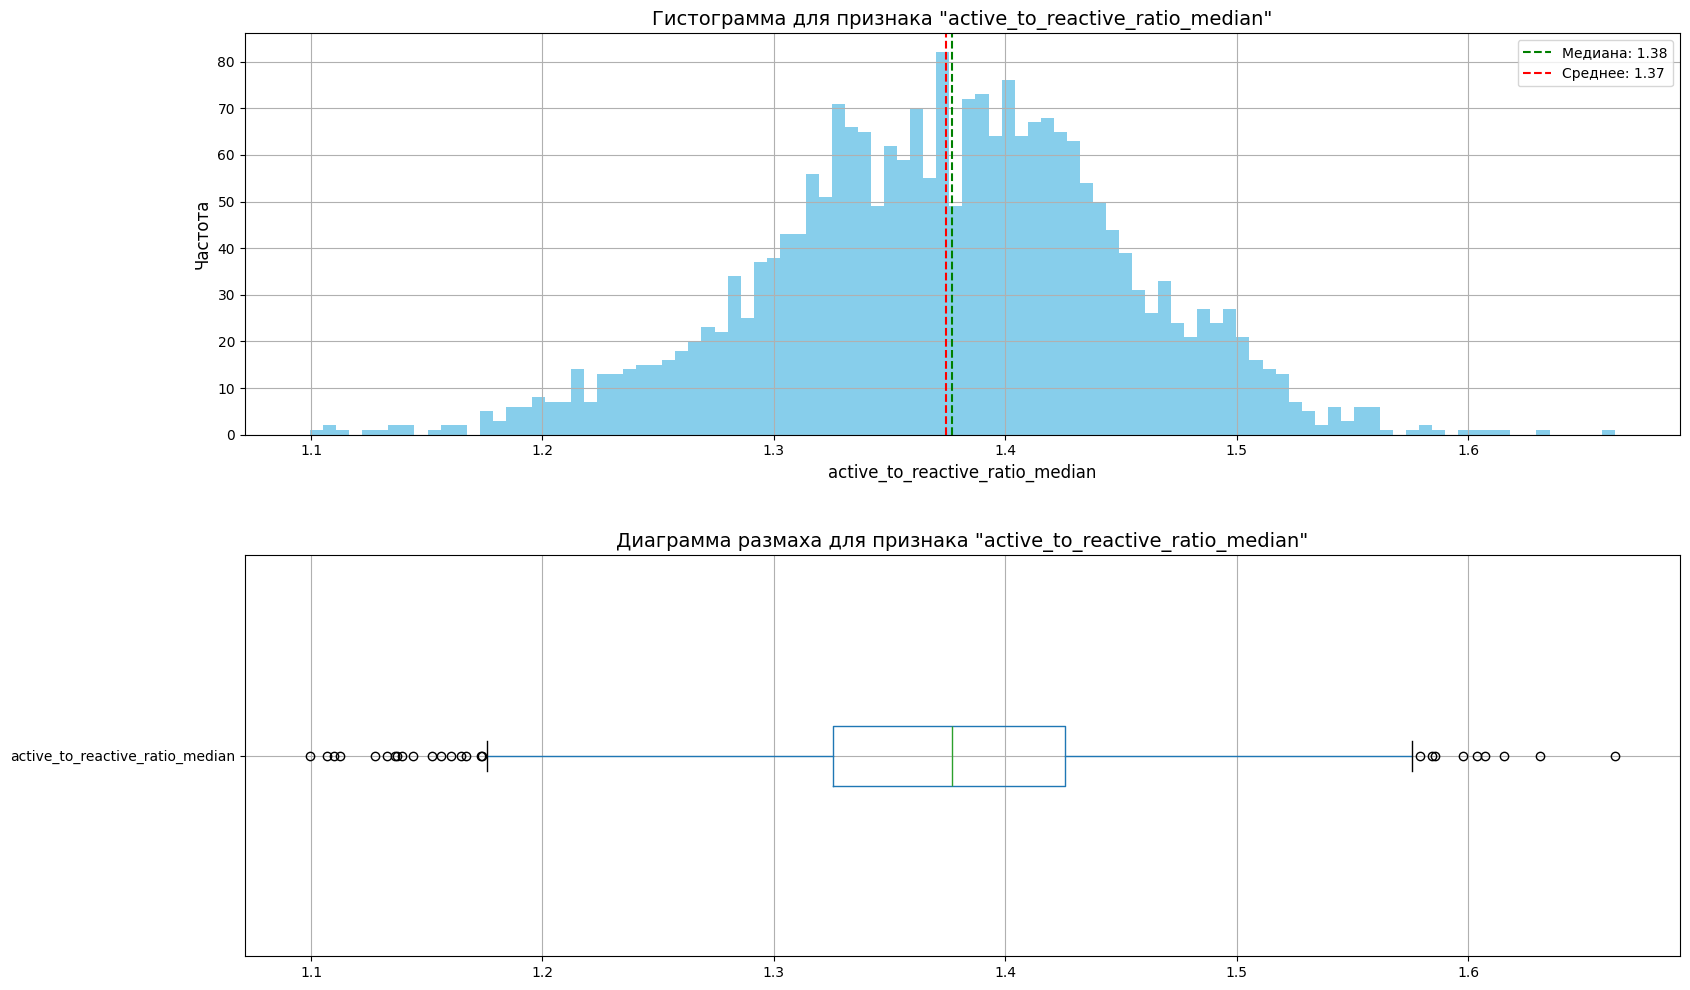


Статистика для 'full_active_energy':
count    2324.000000
mean      670.232396
std       319.526707
min        33.430208
25%       457.924990
50%       631.228863
75%       841.824214
max      4546.405812
Name: full_active_energy, dtype: float64


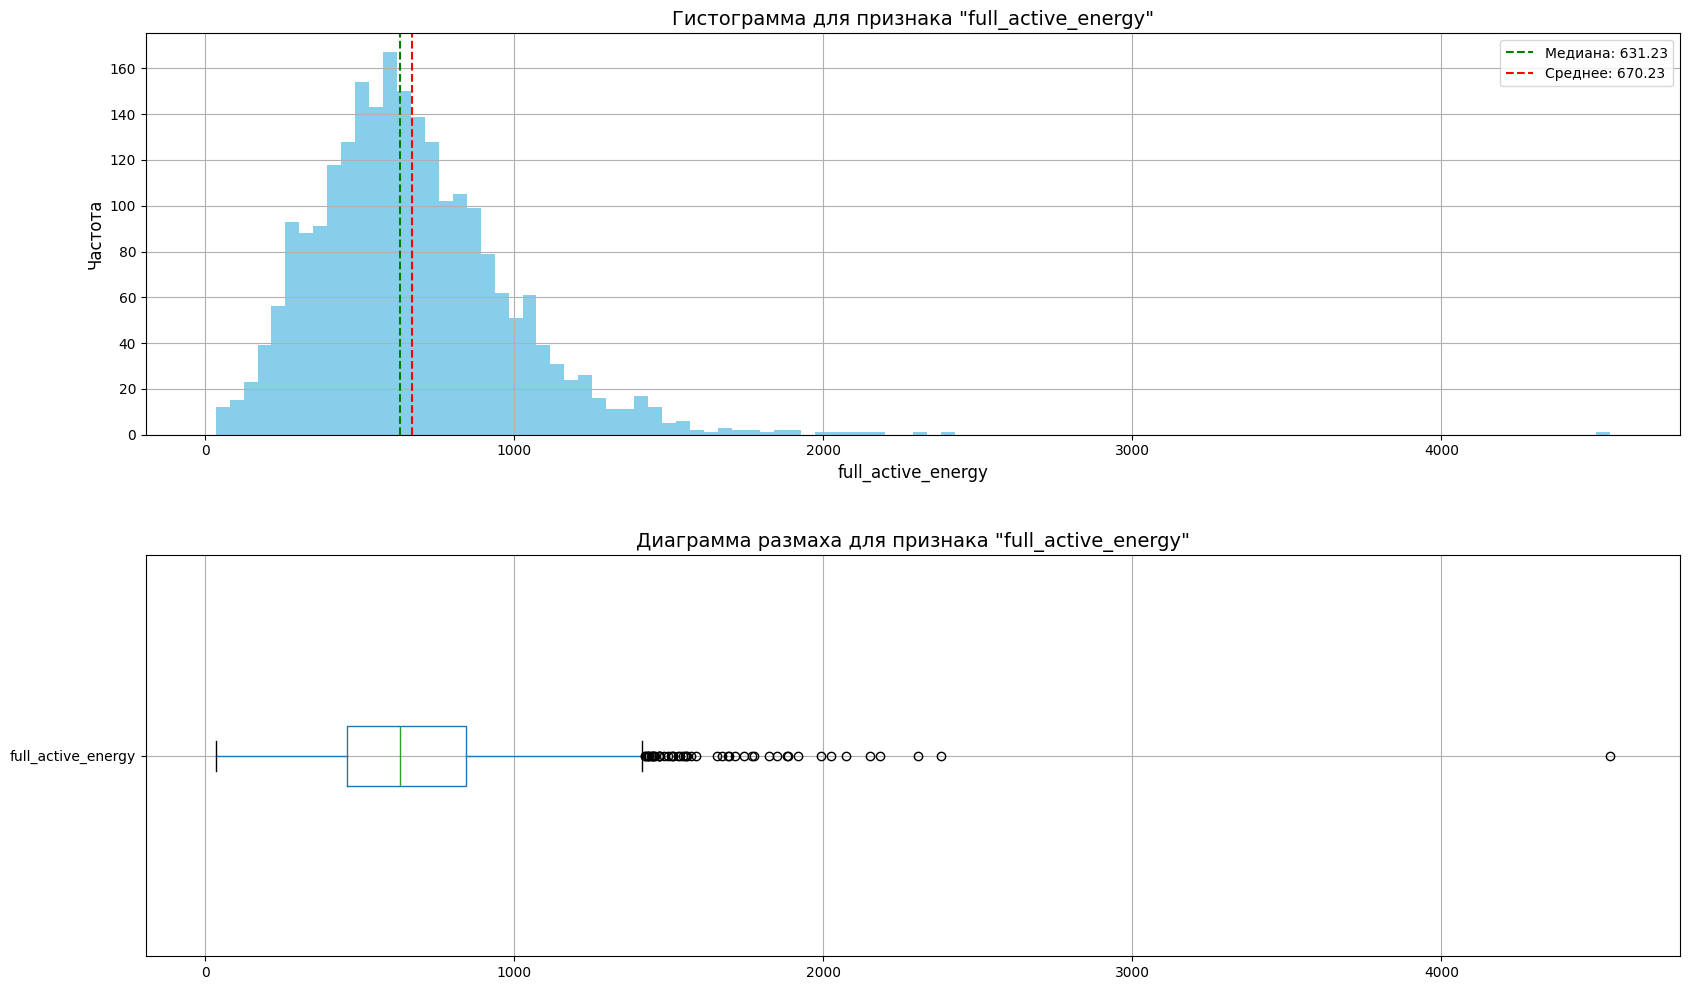


Статистика для 'bulk_12':
count    2324.000000
mean      208.597676
std       157.112117
min         0.000000
25%       105.000000
50%       206.000000
75%       283.000000
max      1849.000000
Name: bulk_12, dtype: float64


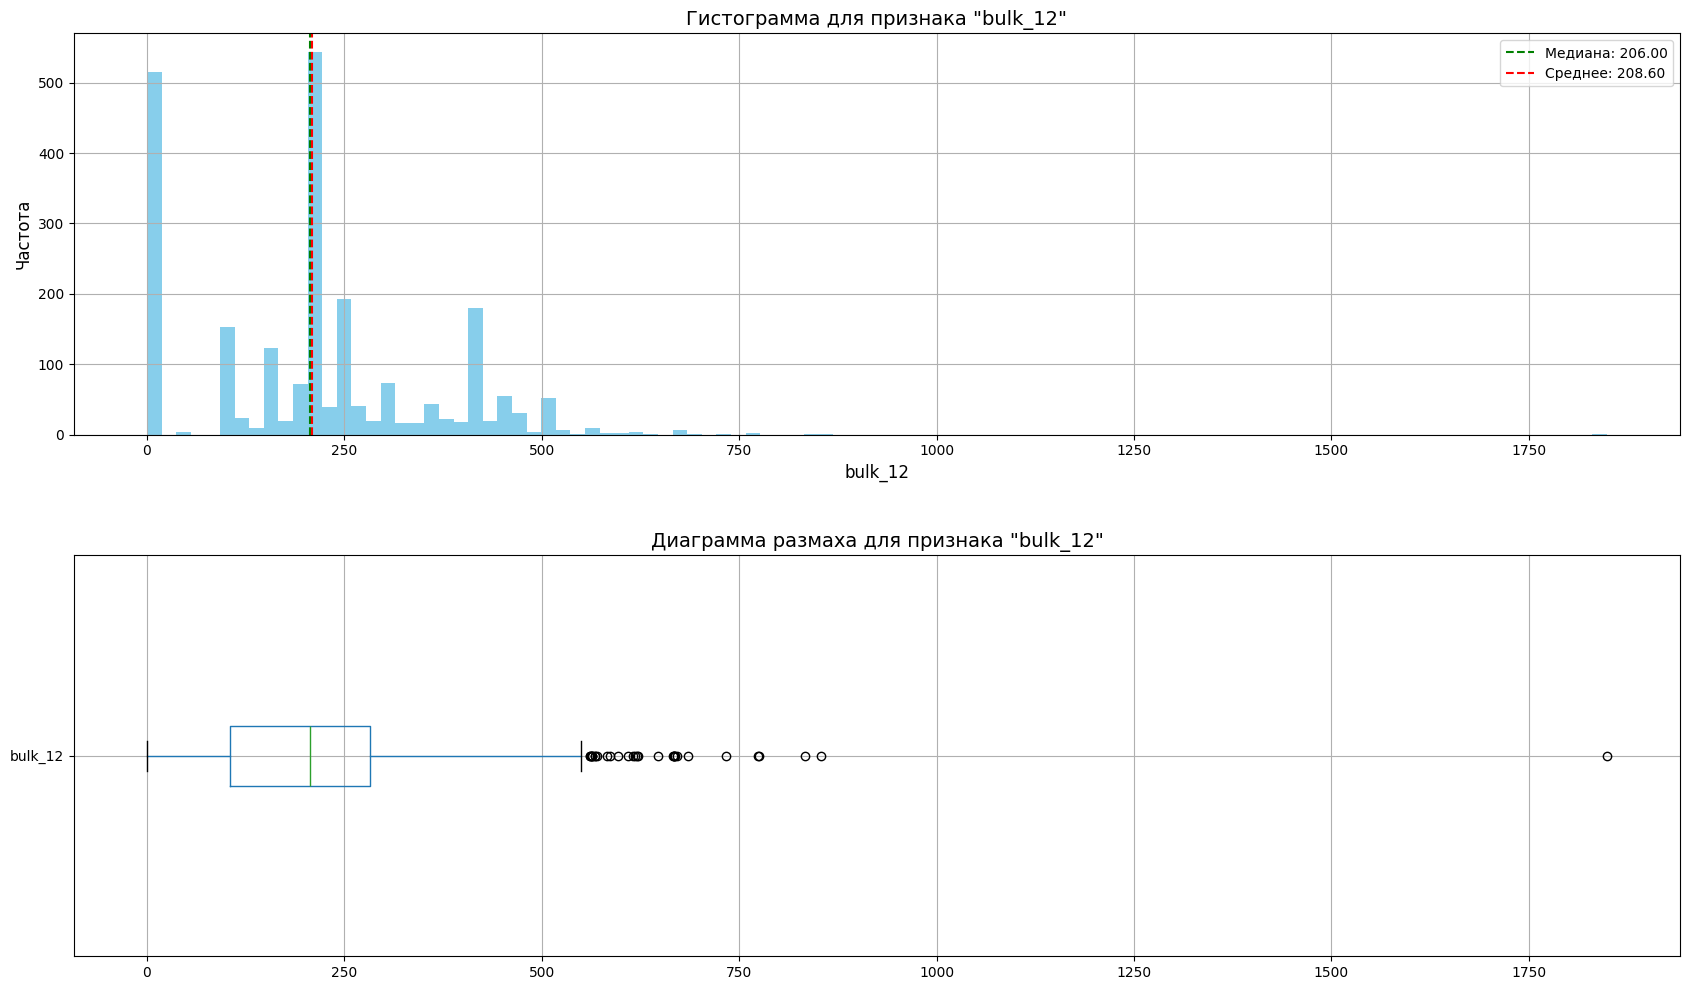


Статистика для 'bulk_14':
count    2324.000000
mean      153.952668
std        81.410544
min         0.000000
25%       105.000000
50%       149.000000
75%       204.000000
max       636.000000
Name: bulk_14, dtype: float64


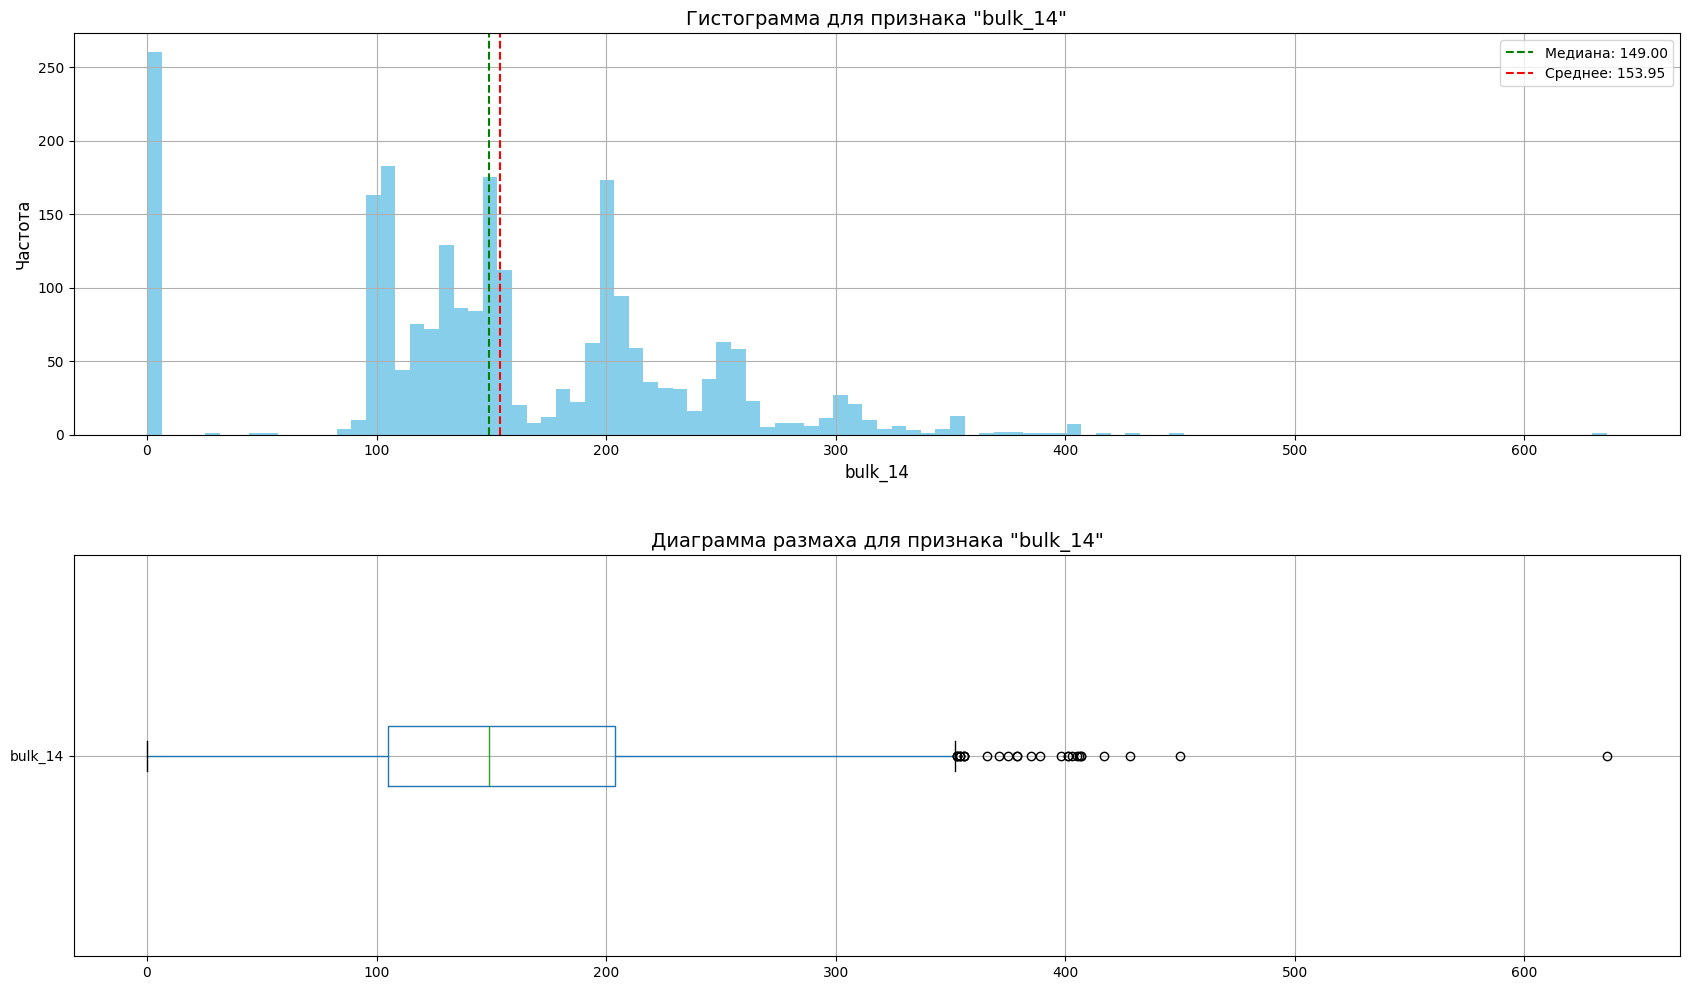


Статистика для 'bulk_15':
count    2324.000000
mean      120.078313
std        84.655967
min         0.000000
25%         0.000000
50%       107.000000
75%       204.000000
max       405.000000
Name: bulk_15, dtype: float64


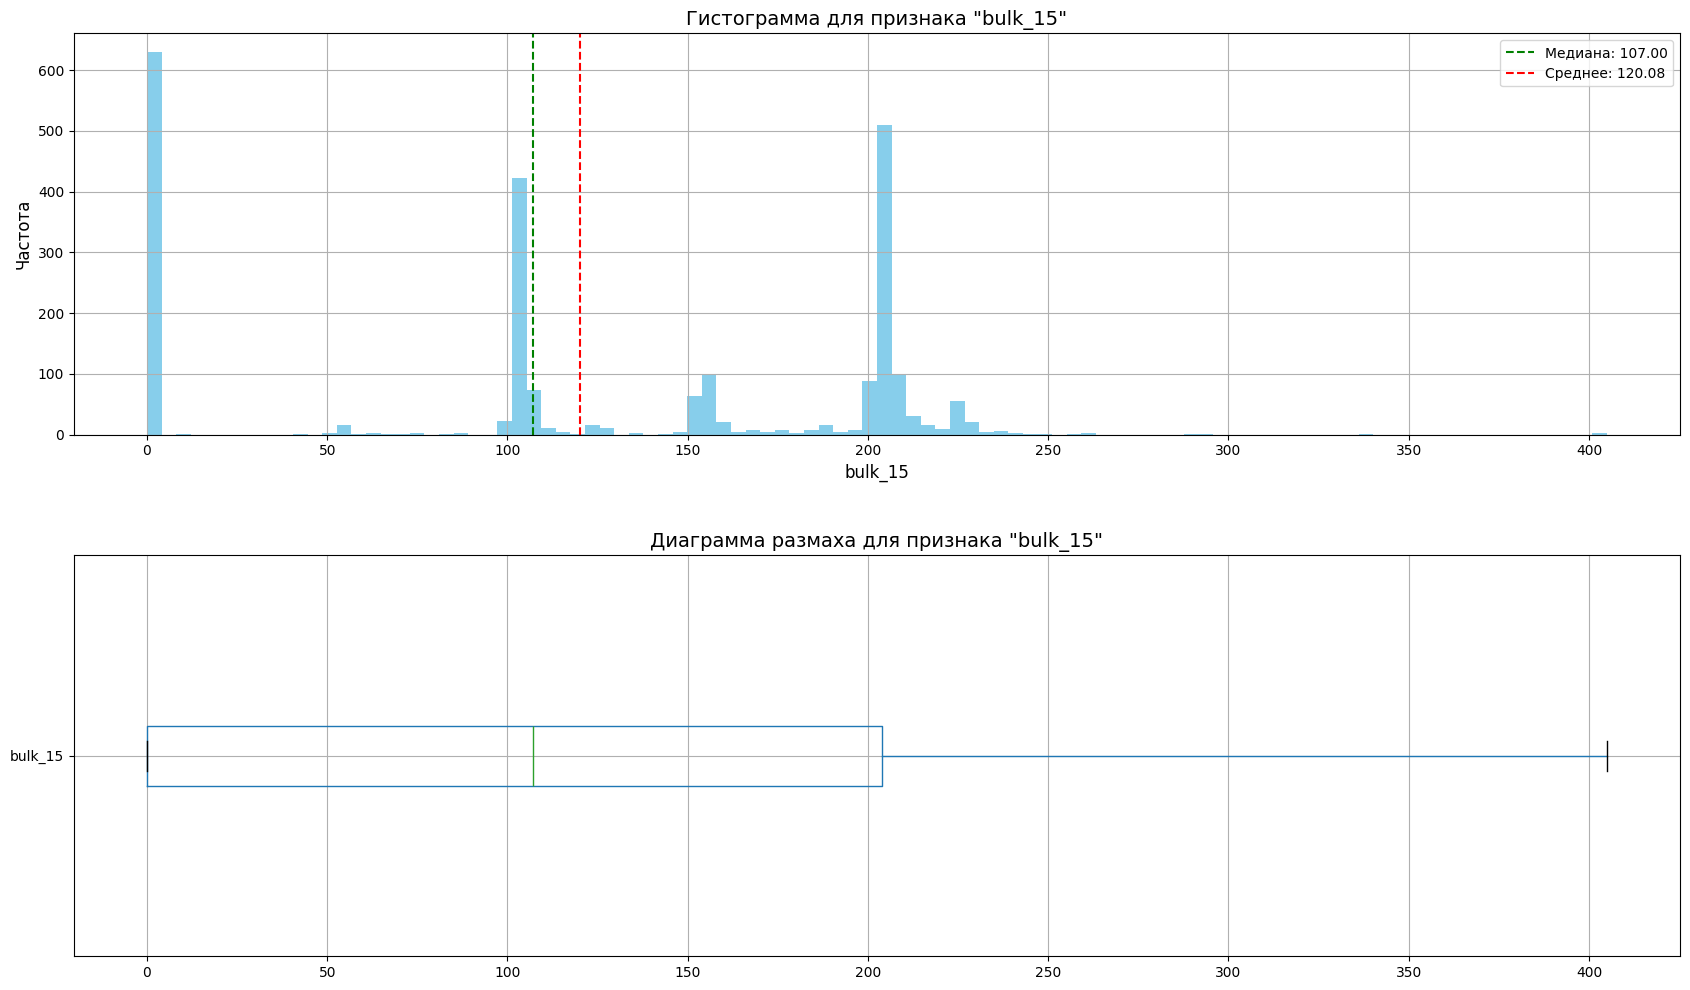


Статистика для 'gas_1':
count    2324.000000
mean       11.378854
std         6.397008
min         0.008399
25%         7.282534
50%        10.100687
75%        14.218487
max        77.995040
Name: gas_1, dtype: float64


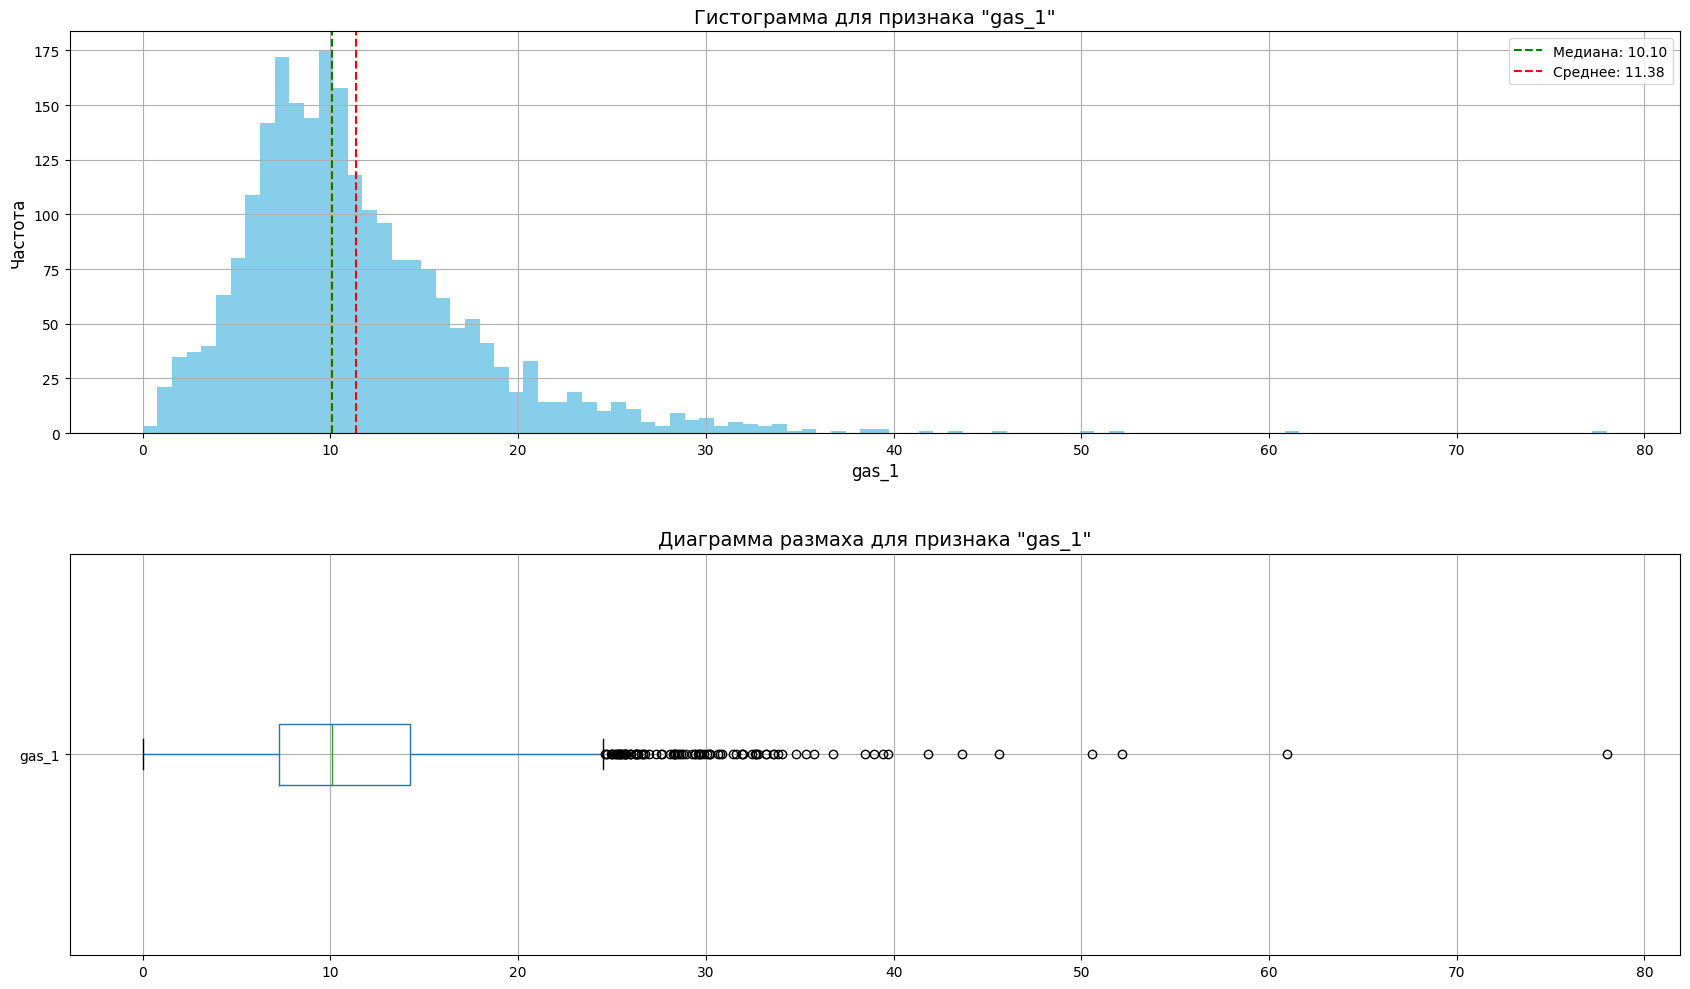


Статистика для 'temp_start':
count    2324.000000
mean     1587.368761
std        23.627590
min      1519.000000
25%      1571.000000
50%      1587.000000
75%      1603.000000
max      1660.000000
Name: temp_start, dtype: float64


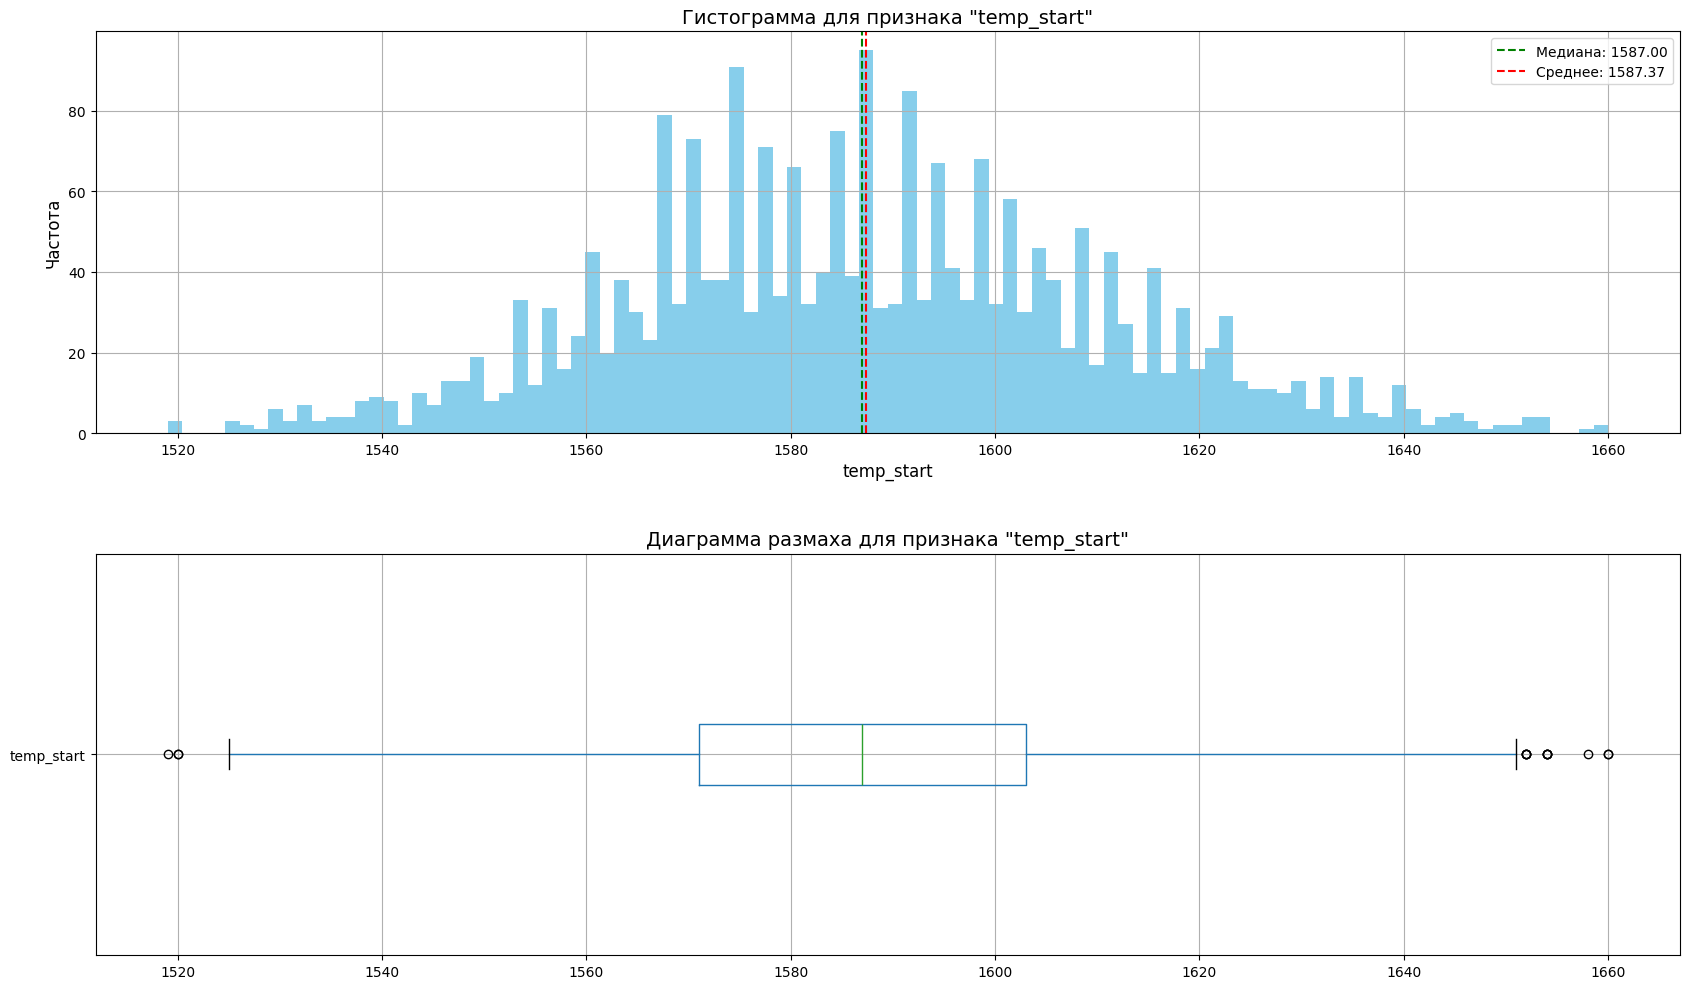


Статистика для 'temp_end':
count    2324.000000
mean     1593.372633
std        11.207457
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: temp_end, dtype: float64


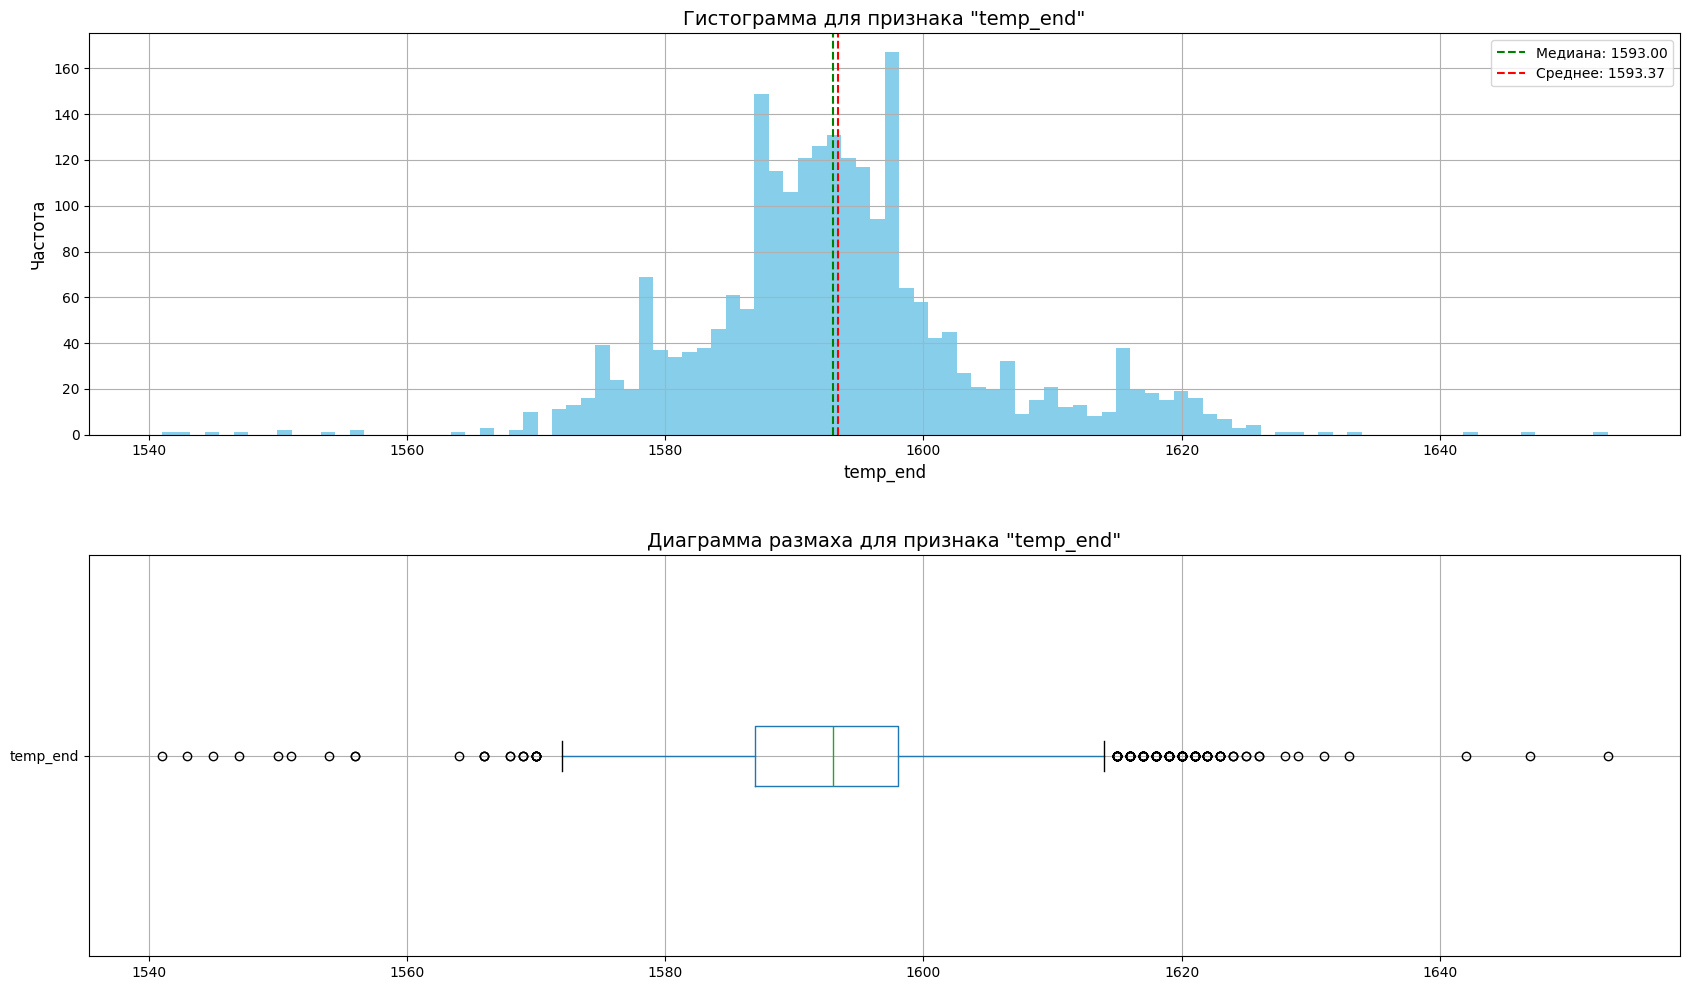


Статистика для 'wire_1':
count    2324.000000
mean      102.423900
std        43.540975
min         0.000000
25%        73.204559
50%       101.103600
75%       128.075222
max       330.314424
Name: wire_1, dtype: float64


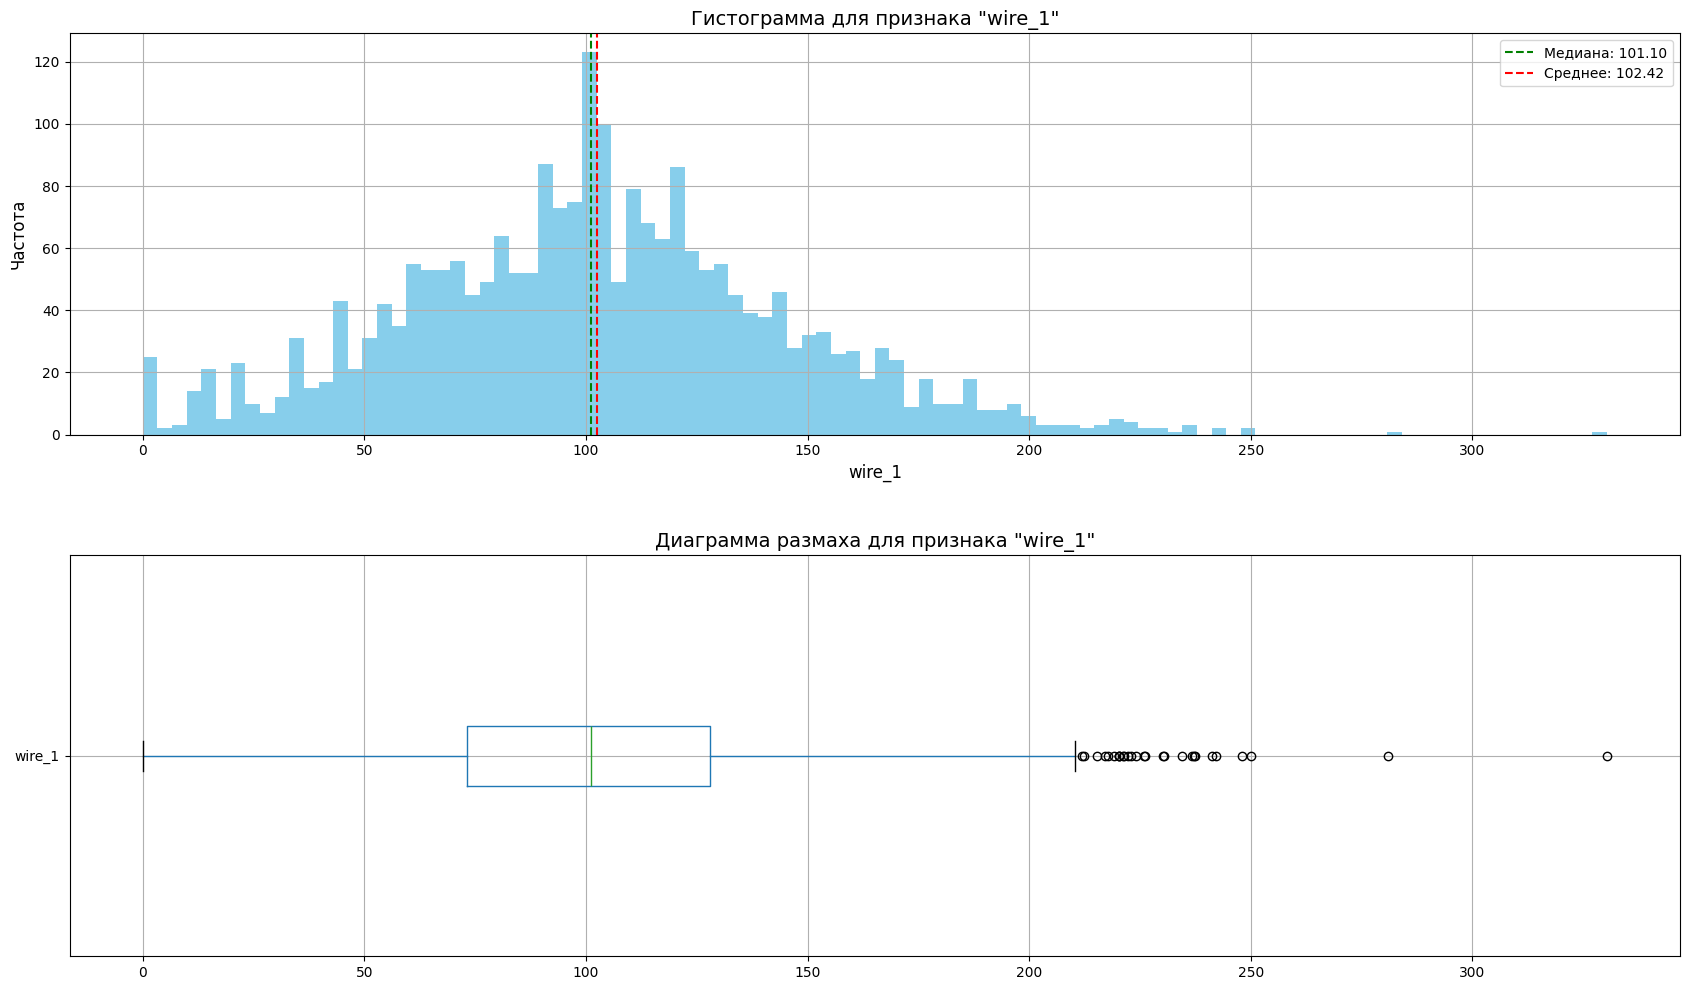


Статистика для 'bulk_sum':
count    2324.000000
mean      610.083046
std       287.574952
min        19.000000
25%       440.000000
50%       609.000000
75%       796.000000
max      3235.000000
Name: bulk_sum, dtype: float64


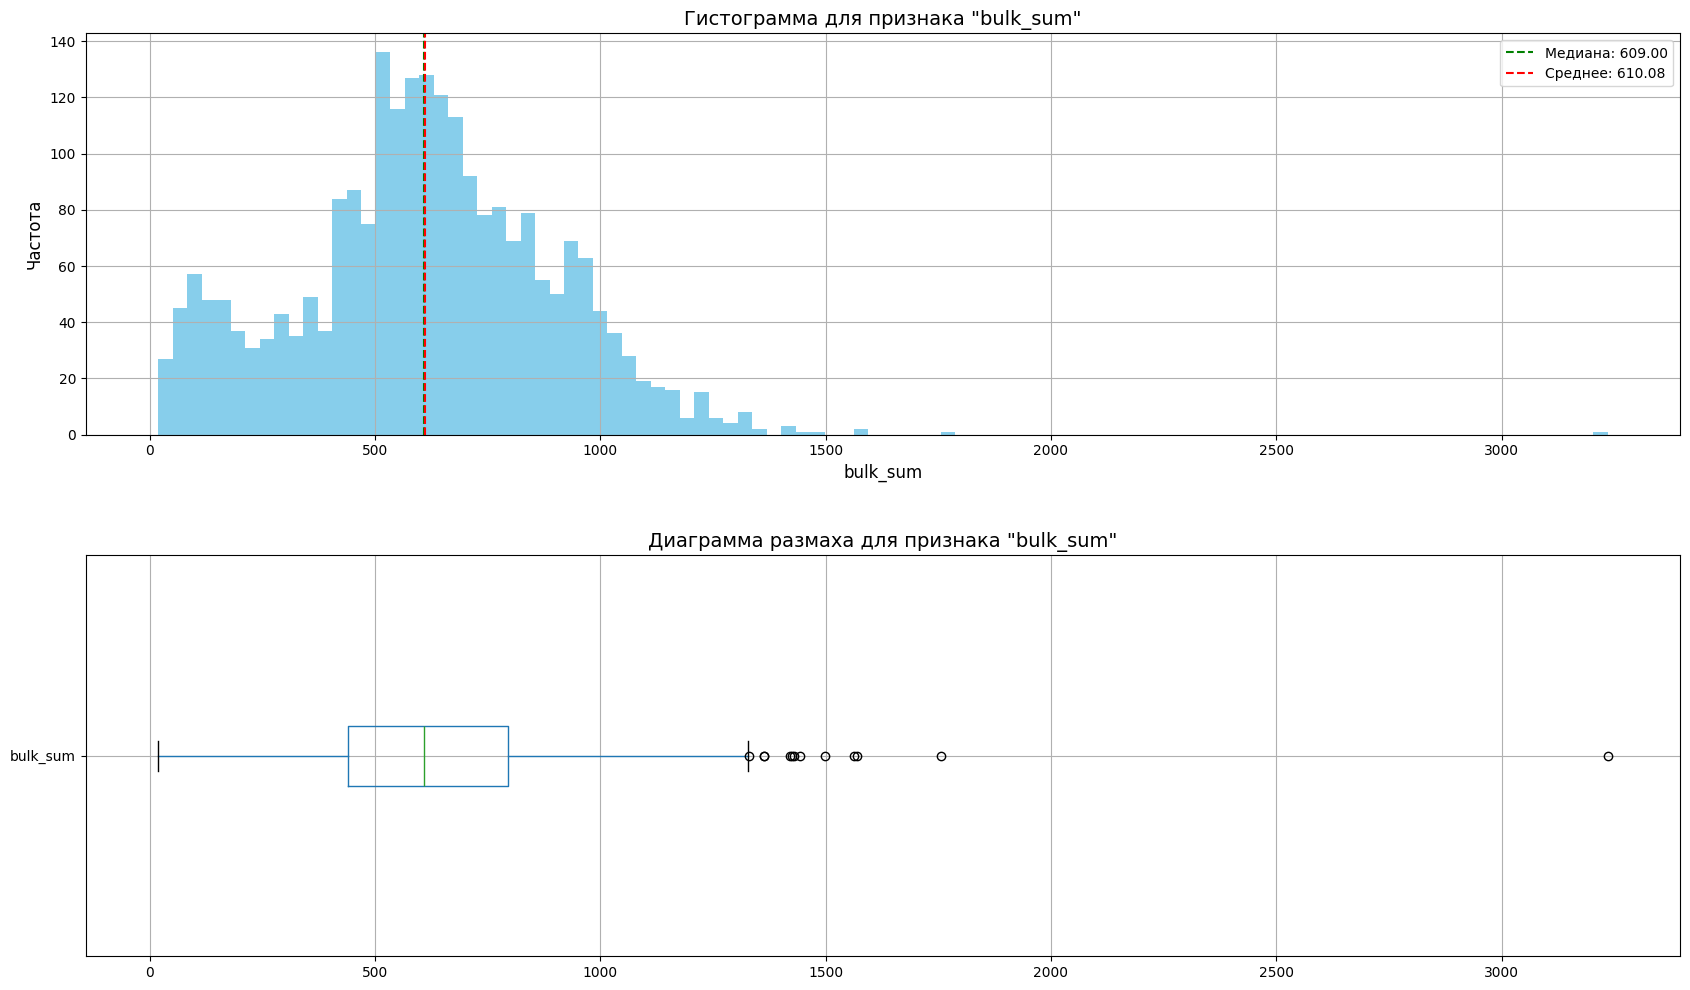


Статистика для 'wire_sum':
count    2324.000000
mean      125.203274
std        63.690752
min         1.918800
25%        89.048700
50%       116.106121
75%       151.555294
max       568.777664
Name: wire_sum, dtype: float64


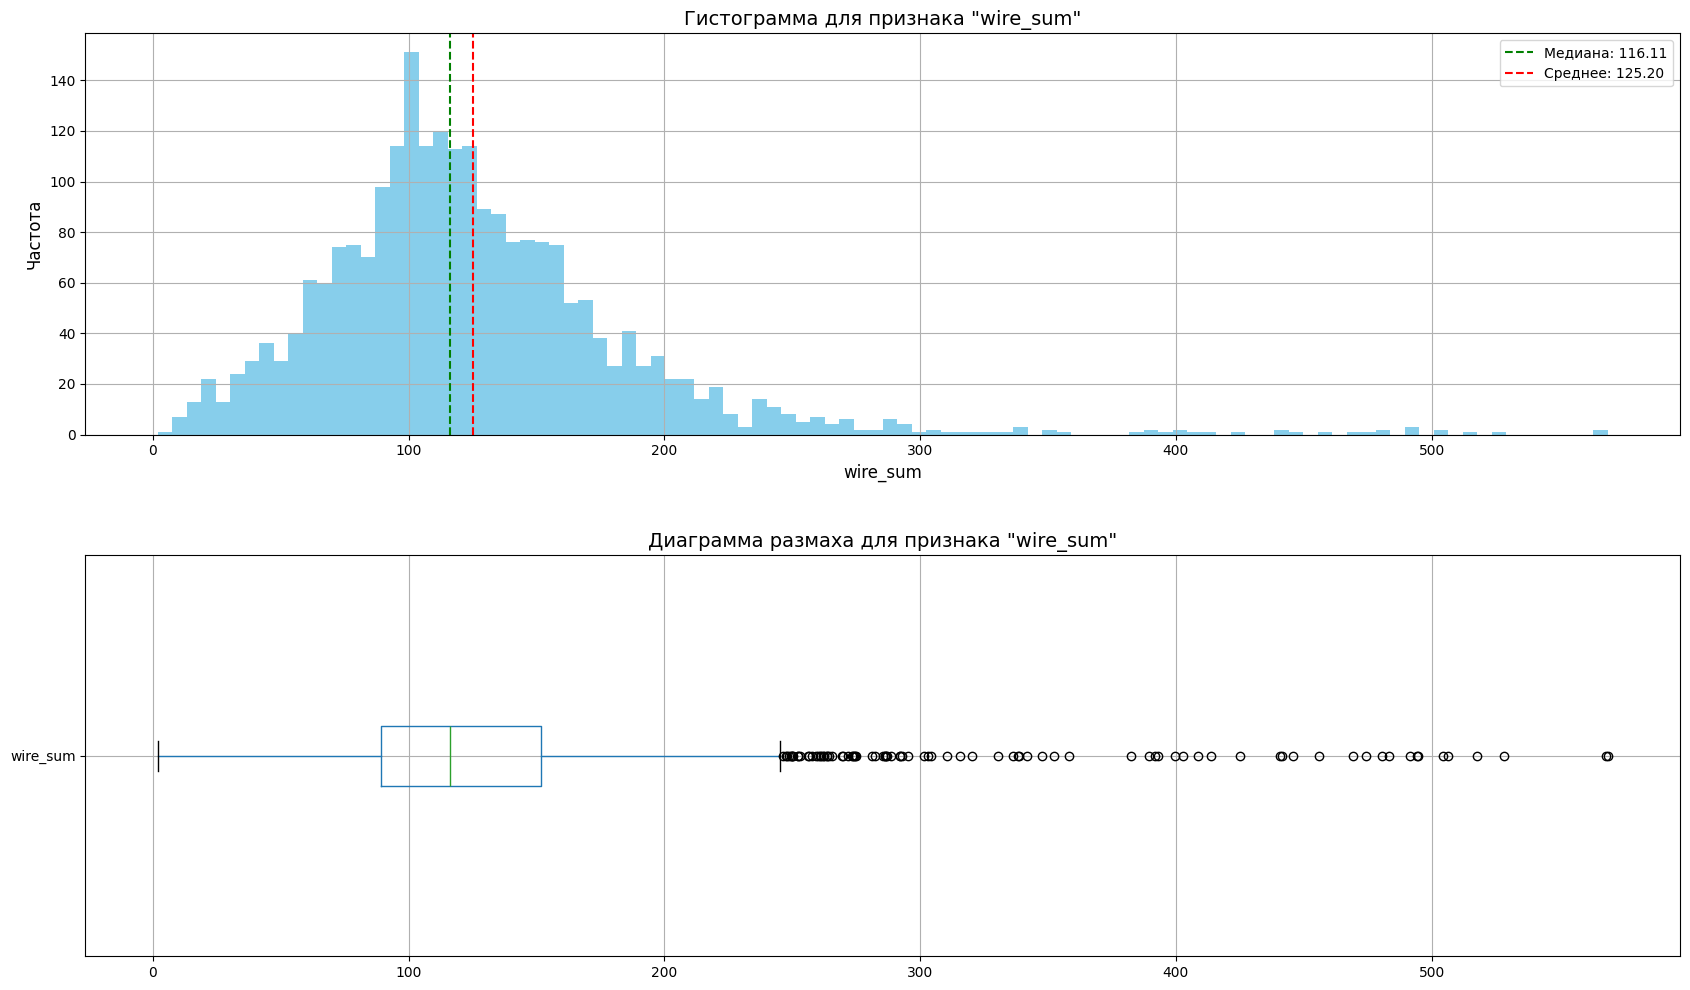


Статистика для 'apparent_power':
count    2324.000000
mean        3.882991
std         1.516067
min         0.331897
25%         2.842446
50%         3.767364
75%         4.767398
max        15.272257
Name: apparent_power, dtype: float64


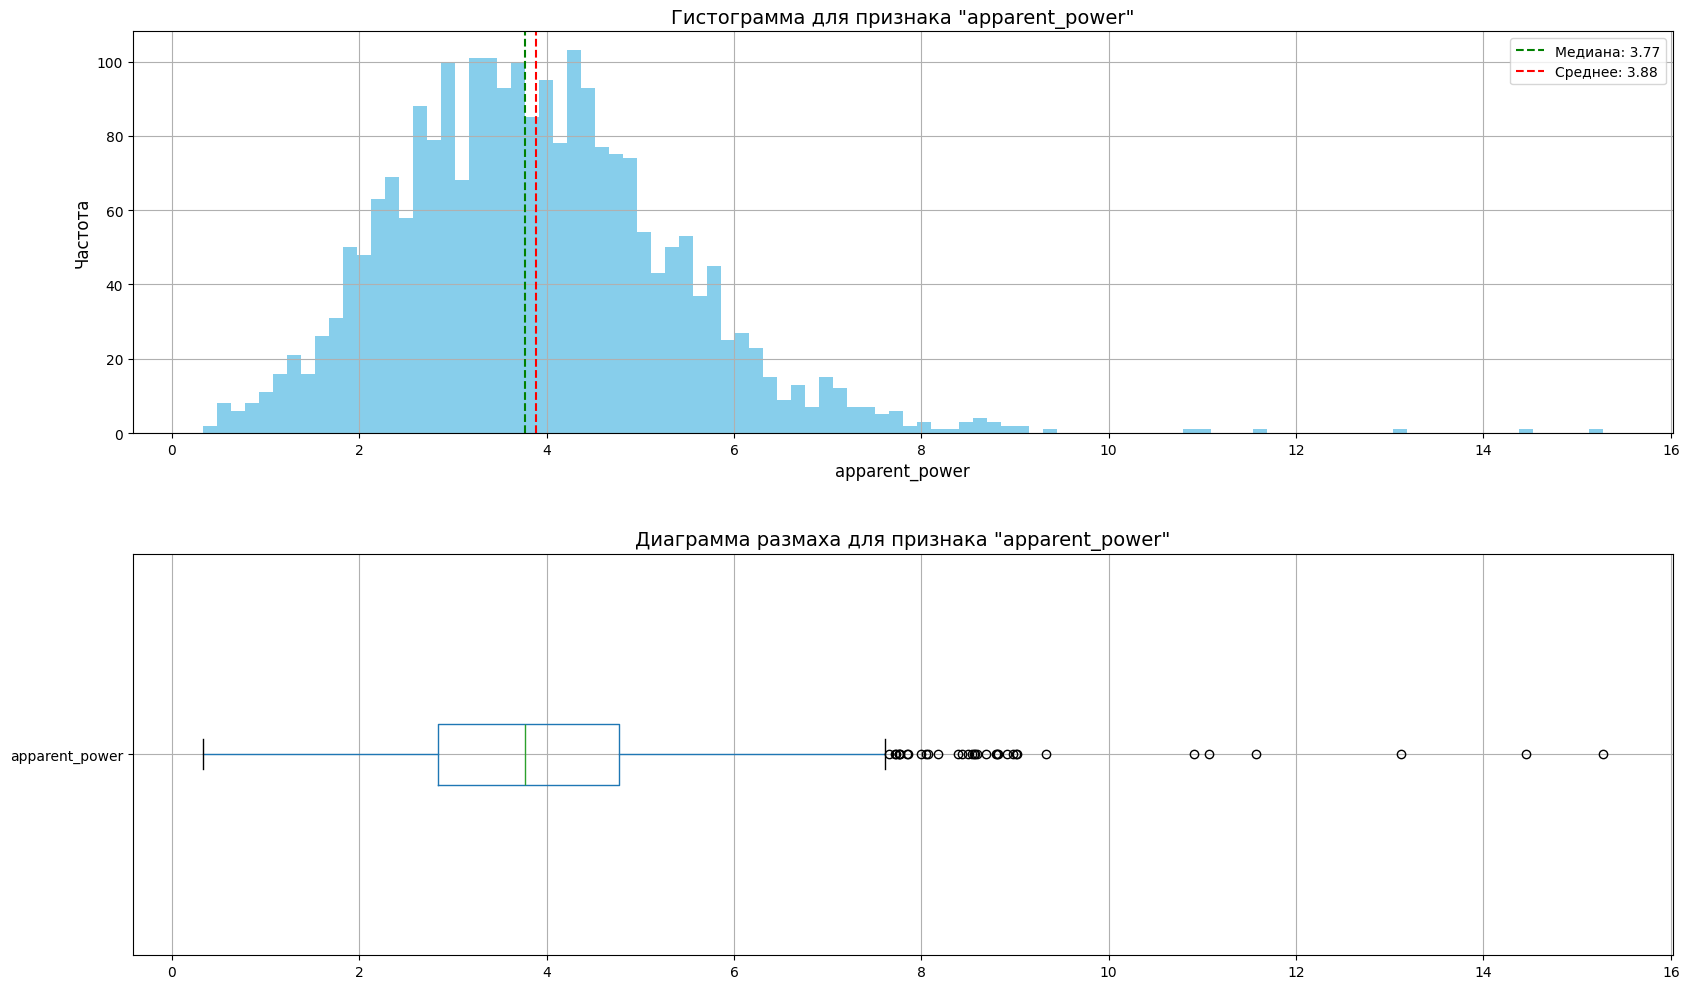

In [120]:
num_columns = [col for col in merged_data.columns if col not in ['key', 'count_of_heating', 'count_of_measure']]
for col in num_columns:
    analyze_numerical_data(merged_data, col, col)

Анализ признаков:

- 'count_of_heaing'
  - среднее: 4.7, медиана: 5, мода: 4, межквартильный интервал: 4-6

- 'count_of_measure
  - среднее: 5.7, медиана: 6, мода: 5, межквартильный интервал: 5-7

- 'duration_of_heating'

  - сильная вариативность данных, распределение длительности нагрева имеет правосторонний хвост с выбросами
  - средняя длительность: 808.2, медиана: 778, стандартное отклонение: 340.8
  - межквартильный интервал: 581-993

- 'active_power_median'
  - хвост распределения тянется вправо к более высоким значениям, присутствуют нетипично большие значения
  - среднее: 0.64, медиана: 0.62, межквартильный интервал: 0.52-0.73, стандартное отклонение: 0.15

- 'active_power_sum'
  - среднее: 3.13, медиана: 3.04, стандартное отклонение: 1.22, межквартильный интервал: 2.30-3.83
  - правосторонний разброс, присутствуют нетипично большие значения

- 'reactive_power_median'
  - среднее: 0.47, стандартное отклонение: 0.11, медиана: 0.45
  - межквартильный размах: 0.38-0.54
  - правосторонняя асимметрия

- 'reactive_power_sum'
  - среднее: 2.30, стандартное отклонение: 0.90, медиана: 2.23  
  - межквартильный интервал: 1.67-2.83
  - правосторонний хвост

- 'apparent_power_median'
  - среднее: 0.79, стандартное отклонение: 0.19, медиана: 0.76
  - межквартильный размах: 0.65-0.9
  - правосторонняя асимметрия

- 'active_to_reactive_ratio_median'
  - среднее: 1.38, стандартное отклонение: 0.08, медиана: 1.38
  - по форме распределение напоминает нормальное
  - межквартильный размах: 1.33-1.43

- 'full_active_energy'
  - длинный правосторонний хвост
  - среднее: 670.23, стандартное отклонение: 319.53, медиана: 631.23
  - межквартильный размах: 457.92-841.82
  
- 'bulk_12'
  - длинный правосторонний хвост
  - среднее: 208.6, стандартное отклонение: 157.11, медиана: 206
  - межквартильный размах: 105-283

- 'bulk_14'
  - правосторонний хвост
  - среднее: 153.95, стандартное отклонение: 81.41, медиана: 149
  - межквартильный размах: 105-204

- 'bulk_15'
  - среднее: 120.08, стандартное отклонение: 84.66, медиана: 107
  - межквартильный размах: 0-204

- 'gas_1'
  - длинный правосторонний хвост
  - среднее: 11.38, стандартное отклонение: 6.4, медиана: 10.1
  - межквартильный размах: 7.28-14.22

- 'temp_start'
  - распределение выглядит симметрично
  - среднее: 1587.37, стандартное отклонение: 23.63, медиана: 1587
  - межквартильный размах: 1571-1603

- 'temp_end'
  - распределение выглядит симметрично
  - среднее: 1593.37, стандартное отклонение: 11.2, медиана: 1593
  - межквартильный размах: 1587-1598

- 'wire_1':
  - распределение выглядит симметрично, но имеет правосторонний хвост
  - среднее: 102.42, стандартное отклонение: 43.54, медиана: 101.1
  - межквартильный размах: 73.2-128.08

- 'bulk_sum'
  - длинный правосторонний хвост
  - среднее: 610.08, стандартное отклонение: 287.57, медиана: 609
  - межквартильный размах: 440-796

- 'wire_sum'
  - длинный правосторонний хвост
  - среднее: 125.2, стандартное отклонение: 63.69, медиана: 116.11
  - межквартильный размах: 89.05-151.56

- 'apparent_power'
  - длинный правосторонний хвост
  - среднее: 3.88, стандартное отклонение: 1.52, медиана: 3.77
  - межквартильный размах: 2.84-4.77

#### Корреляционный анализ

Посмотрим на коллинеарность признаков.

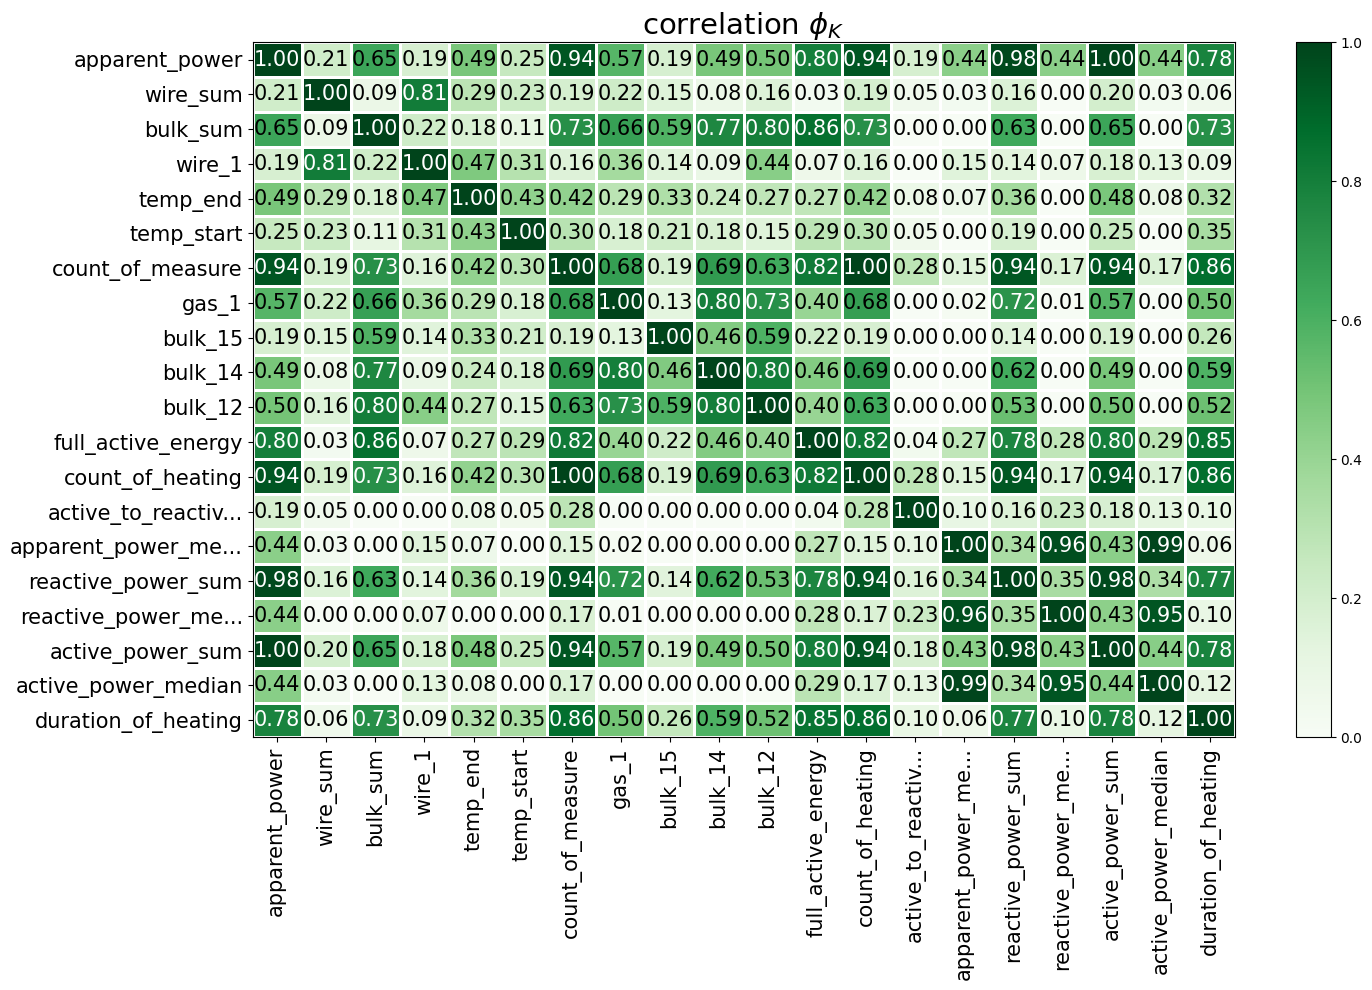

In [121]:
# используем phik для выявления взаимосвязей
phik_overview = phik_matrix(merged_data.drop(columns=['key']), interval_cols=num_columns)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

In [122]:
phik_overview

,duration_of_heating,active_power_median,active_power_sum,reactive_power_median,reactive_power_sum,apparent_power_median,active_to_reactive_ratio_median,count_of_heating,full_active_energy,bulk_12,bulk_14,bulk_15,gas_1,count_of_measure,temp_start,temp_end,wire_1,bulk_sum,wire_sum,apparent_power
duration_of_heating,1.000000,0.118662,0.782447,0.097598,0.774900,0.062696,0.096334,0.864062,0.846989,0.517054,0.591983,0.261100,0.500915,0.864062,0.354178,0.317537,0.093314,0.733112,0.058134,0.783152
active_power_median,0.118662,1.000000,0.442857,0.947380,0.335215,0.994971,0.128021,0.167292,0.290910,0.000000,0.000000,0.000000,0.000000,0.167292,0.000000,0.083773,0.129864,0.000000,0.033669,0.441907
active_power_sum,0.782447,0.442857,1.000000,0.431876,0.977684,0.433740,0.184181,0.942644,0.799184,0.500781,0.487596,0.188051,0.572529,0.942644,0.252926,0.481043,0.182390,0.648284,0.201535,0.999814
reactive_power_median,0.097598,0.947380,0.431876,1.000000,0.349554,0.964963,0.232342,0.168469,0.276124,0.000000,0.000000,0.000000,0.010905,0.168469,0.000000,0.000000,0.072306,0.000000,0.000000,0.435201
reactive_power_sum,0.774900,0.335215,0.977684,0.349554,1.000000,0.340901,0.159547,0.938104,0.775754,0.526564,0.623594,0.142533,0.715152,0.938104,0.190403,0.364761,0.139149,0.630586,0.161080,0.984135
apparent_power_median,0.062696,0.994971,0.433740,0.964963,0.340901,1.000000,0.102659,0.145886,0.274859,0.000000,0.000000,0.000000,0.019187,0.145886,0.000000,0.070069,0.145597,0.000000,0.034391,0.436549
active_to_reactive_ratio_median,0.096334,0.128021,0.184181,0.232342,0.159547,0.102659,1.000000,0.284842,0.043928,0.000000,0.000000,0.000000,0.000000,0.284842,0.052330,0.080687,0.000000,0.000000,0.048839,0.187593
count_of_heating,0.864062,0.167292,0.942644,0.168469,0.938104,0.145886,0.284842,1.000000,0.817847,0.626094,0.688572,0.185811,0.675173,1.000000,0.297946,0.416623,0.155014,0.733269,0.194760,0.941887
full_active_energy,0.846989,0.290910,0.799184,0.276124,0.775754,0.274859,0.043928,0.817847,1.000000,0.399800,0.460528,0.217829,0.400521,0.817847,0.287104,0.271422,0.066342,0.857352,0.031842,0.798667
bulk_12,0.517054,0.000000,0.500781,0.000000,0.526564,0.000000,0.000000,0.626094,0.399800,1.000000,0.803408,0.593947,0.728173,0.626094,0.149887,0.273801,0.444693,0.801792,0.158965,0.499072


Номер партии не будет влиять на таргет, данный признак будет удален и корреляции для него не рассматривали.

Корреляции temp_end с другими признаками:
- умеренная (0.3-0.5)
 - wire_1
 - temp_start
 - bulk_15
 - count_of_heating
 - count_of_measure
 - active_power_sum
 - reactive_power_sum
 - apparent_power
 - duration_of_heating

- слабая (0.1-0.3)
 - bulk_12
 - bulk_14
 - gas_1
 - full_active_energy
 - bulk_sum
 - wire_sum

- практически отсутствует (< 0.1)
 - active_power_median
 - apparent_power_median
 - active_to_reactive_ratio_median

- нет взаимосвязи (0)
 - reactive_power_median

Признаки active_power_median, apparent_power_median, reactive_power_median использовать не будем (остаются active_power_sum, reactive_power_sum и apparent_power). Также не будем использовать active_to_reactive_ratio_median.

Мультиколлинеарность среди оставшихся(>0.9):
- наблюдается высокая корреляция apparent_power с count_of_measure, count_of_heating, reactive_power_sum, active_power_sum. Есть смысл убрать этот признак.
- count_of_heating и count_of_measure - оставим count_of_heating

- count_of_heating/count_of_measure и reactive_power_sum,  reactive_power_sum и active_power_sum - т.к. наша цель - конечная температура, лучше удалить reactive_power_sum, т.к. активная мощность непосредственно влияет на температуру




Удалим выбранные признаки.

In [123]:
col_to_del = ['key', 'active_power_median', 'apparent_power_median',
              'reactive_power_median', 'active_to_reactive_ratio_median',
              'apparent_power', 'count_of_measure', 'reactive_power_sum']
merged_data = merged_data.drop(columns=col_to_del)
merged_data.shape

(2324, 13)

In [124]:
merged_data.head()

,duration_of_heating,active_power_sum,count_of_heating,full_active_energy,bulk_12,bulk_14,bulk_15,gas_1,temp_start,temp_end,wire_1,bulk_sum,wire_sum
0,1098,3.036730,5,770.282114,206,150,154,29.749986,1571.0,1613.0,60.059998,553,60.059998
1,811,2.139408,4,481.760005,206,149,154,12.555561,1581.0,1602.0,96.052315,582,96.052315
2,655,4.063641,5,722.837668,205,152,153,28.554793,1596.0,1599.0,91.160157,544,91.160157
3,741,2.706489,4,683.455597,207,153,154,18.841219,1601.0,1625.0,89.063515,595,89.063515
4,869,2.252950,4,512.169934,203,151,152,5.413692,1576.0,1602.0,89.238236,584,98.352796


In [125]:
merged_data.duplicated().sum()

np.int64(0)

После изменений дубликатов нет.

### Подготовка данных для обучения

In [126]:
# выделяем признаки и целевую переменную
X = merged_data.drop(['temp_end'], axis=1)
y = merged_data['temp_end']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=RANDOM_STATE)

X_train.shape, X_test.shape

((1743, 12), (581, 12))

In [127]:
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

Все признаки являются численными, может понадобится масштабирование. Т.к. мы планируем рассмотреть нейросеть среди моделей, используем StandartScaler.

__Промежуточный вывод__:

- провели EDA
 - все загруженные таблицы содержат данные,
 - данные предоставлены за период с 03.05.2019 по 06.09.2019,
 - мы переименовали проблемные столбцы, используя латиницу, привели названия к змеиному стилю, преобразовали типы данных для случаев, когда они не были верно определены, обработали пропуски, создали дополнительные признаки,
 - определили номера партий, в записях о которых обнаружены аномалии (отрицательное значение реактивной мощности, температура ниже 1500), а также те, для которых температура измерялась только один раз,
 - определили номера партий, информация о которых отсутсвует минимум в одной из таблиц,
- объединили таблицы (data_bulk_time и data_wire_time не использовали) - в итоговый датасет вошли данные о 2324 партиях,
  - предварительно удалили записи о партиях с аномалиями,
  - оставили только признаки, которые планируем рассматривать в дальнейшем, а также созданные признаки,
  - исследовали данные объединенной таблицы
- провели корреляционный анализ данных, оставили только значимые признаки, избавились от мультиколлинеарности,
- выделили признаки и целевую переменную.

## Обучение моделей

In [128]:
def train_model(model, param_grid, X_train, y_train, num_cols, scale=False):
    """
    Обучение модели с GridSearchCV и возврат лучшего estimator и MAE

    Параметры
    ----------
    model : estimator
        Обучаемая модель
    param_grid : dict
        Словарь с параметрами для GridSearchCV
    X_train : pandas.DataFrame
        Признаки обучающей выборки
    y_train : pandas.Series
        Целевая переменная обучающей выборки
    num_cols : list
        Список числовых признаков
    scale : bool, optional
        Флаг, указывающий на необходимость масштабирования признаков,
        по умолчанию False

    Возвращает
    -------
    best_estimator : estimator
        Лучший estimator
    best_score : float
        MAE на кросс-валидации
    """

    if scale:
        preprocessor = ColumnTransformer(
            [('num', StandardScaler(), num_cols)],
            remainder='passthrough'
            )
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
            ])
    else:
        pipe = Pipeline([("model", model)])

    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print(f"MAE на кросс-валидации: {-grid_search.best_score_:.4f}")
    print(f"Лучшие параметры: {grid_search.best_params_}\n")

    return grid_search.best_estimator_, -grid_search.best_score_

Решаем задачу регрессии, обучение с учителем.

#### DecisionTreeRegressor

In [129]:
param_dt = {
    'model__max_depth': [3, 5, 7, 9, 11],
    'model__min_samples_split': [5, 10, 15],
    'model__min_samples_leaf': [1, 3, 5, 7, 10]
}

best_estimator_dt, best_score_dt = train_model(
    DecisionTreeRegressor(random_state=RANDOM_STATE), param_dt,
    X_train, y_train, num_cols)

MAE на кросс-валидации: 7.3831
Лучшие параметры: {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}



#### RandomForestRegressor

In [130]:
param_rf = {
    'model__max_depth': [5, 7, 9],
    'model__min_samples_split': [5, 10, 15],
    'model__n_estimators': [100, 200, 300]
}

best_estimator_rf, best_score_rf = train_model(
    RandomForestRegressor(random_state=RANDOM_STATE), param_rf,
    X_train, y_train, num_cols)

MAE на кросс-валидации: 6.5900
Лучшие параметры: {'model__max_depth': 9, 'model__min_samples_split': 5, 'model__n_estimators': 200}



### CatBoostRegressor

In [131]:
param_cb = {
    'model__iterations': [200, 400, 600, 800],
    'model__depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.05, 0.1]
}

best_estimator_cb, best_score_cb = train_model(
    CatBoostRegressor(cat_features=[], random_state=RANDOM_STATE, verbose=0),
    param_cb,
    X_train, y_train, num_cols)

MAE на кросс-валидации: 6.4049
Лучшие параметры: {'model__depth': 5, 'model__iterations': 400, 'model__learning_rate': 0.05}



### LGBMRegressor

In [132]:
param_lgbm = {
    'model__num_leaves': [15, 31, 62, 127],
    'model__n_estimators': [50, 100, 200, 500],
    'model__max_depth': [6, 8],
    'model__learning_rate': [0.01, 0.05, 0.1]
}

best_estimator_lgbm, best_score_lgbm = train_model(
    LGBMRegressor(random_state=RANDOM_STATE), param_lgbm,
    X_train, y_train, num_cols)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2390
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 12
[LightGBM] [Info] Start training from score 1593.437751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

### Полносвязная нейронная сеть

In [133]:
def train_net(net, X_train, y_train, X_test, y_test,
                learning_rate=0.001, num_epochs=100000, batch_size=64, printing=True, patience=5):
    """
    Обучает нейронную сеть net на обучающих данных X_train и y_train,
    используя оптимизатор Adam с learning_rate, реализовано раннее прерывание обучения.
    Перед завершением работы восстанавливается состояние модели,
    достигшей наилучшей производительности.

    Параметры:
    ----------
    net : torch.nn.Module
        Нейронная сеть, которую нужно обучить
    X_train : torch.Tensor
        Признаки обучающей выборки
    y_train : torch.Tensor
        Целевая переменная обучающей выборки
    X_test : torch.Tensor
        Признаки тестовой выборки
    y_test : torch.Tensor
        Целевая переменная тестовой выборки
    learning_rate : float, optional
        Скорость обучения оптимизатора, по умолчанию 0.001
    num_epochs : int, optional
        Количество эпох обучения, по умолчанию 100000
    batch_size : int, optional
        Размер батча, по умолчанию 64
    printing : bool, optional
        Флаг для вывода информации о процессе обучения, по умолчанию True
    patience : int, optional
        Количество эпох без улучшения для ранней остановки, по умолчанию 5

    Возвращает:
    ----------
    train_loss_values : list
        Список значений функций потерь на обучающих данных
    test_loss_values : list
        Список значений функций потерь на тестовых данных
    epoch_count : list
        Список номеров эпох во время обучения
    best_test_loss: float
        Наилучшее значение метрики на тестовых данных
    """

    # переменные для ранней остановки
    best_test_loss = float('inf')
    epochs_without_improvement = 0

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss = nn.L1Loss()
    num_batches = ceil(len(X_train) / batch_size)

    # результаты обучения
    train_loss_values = []
    test_loss_values = []
    epoch_count = []
    best_model_state = None

    for epoch in range(num_epochs):
        net.train()
        order = np.random.permutation(len(X_train))

        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            # Получение индексов текущего батча
            batch_indexes = order[start_index:start_index + batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_batch).flatten()
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            net.eval()
            with torch.no_grad():
                test_preds = net.forward(X_test).flatten()
                test_mae = loss(test_preds, y_test)
                train_mae = loss_value

            if printing:
                print(f"Epoch: {epoch:3d} | MAE Train Loss: {train_mae:.5f} | "
                      f"MAE Test Loss: {test_mae:.5f}")
            epoch_count.append(epoch)
            test_loss_values.append(test_mae.detach().numpy())
            train_loss_values.append(train_mae.detach().numpy())

            # Ранняя остановка
            if test_mae < best_test_loss:
                best_test_loss = test_mae
                epochs_without_improvement = 0
                best_model_state = net.state_dict()
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                if printing:
                    print(f"Early stopping at epoch {epoch}. "
                          f"Best test loss: {best_test_loss:.5f}")
                break

    net.load_state_dict(best_model_state)
    return train_loss_values, test_loss_values, epoch_count, best_test_loss

In [134]:
def plot_loss(train_loss_values, test_loss_values, epoch_count):
    """
    Строит график потерь на обучающем и тестовом наборе данных по эпохам.

    Параметры:
    ----------
    train_loss_values : list
        Список значений функций потерь на обучающих данных
    test_loss_values : list
        Список значений функций потерь на тестовых данных
    epoch_count : list
        Список номеров эпох во время обучения
    """

    plt.figure(figsize=(9, 6))

    plt.title("Train / test loss")
    plt.xlabel("$Epoch$")
    plt.ylabel("$Loss$")

    plt.plot(epoch_count, train_loss_values)
    plt.plot(epoch_count, test_loss_values)

    plt.legend(["Train", "Test"])
    plt.show()

Подготовим данные для нейронной сети. Нам понадобится валидационная выборка.

In [135]:
X_train_net, X_valid_net, y_train_net, y_valid_net = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_net)
X_valid_scaled = scaler.transform(X_valid_net)

X_train_scaled.shape, X_valid_scaled.shape

((1394, 12), (349, 12))

In [136]:
X_train_ft = torch.FloatTensor(np.array(X_train_scaled))
y_train_ft = torch.FloatTensor(np.array(y_train_net))
X_valid_ft = torch.FloatTensor(np.array(X_valid_scaled))
y_valid_ft = torch.FloatTensor(np.array(y_valid_net))

n_in_neurons = X_train.shape[1]
n_out_neurons = 1

Epoch:   0 | MAE Train Loss: 1595.74561 | MAE Test Loss: 1593.82251
Epoch:  10 | MAE Train Loss: 1594.51807 | MAE Test Loss: 1593.11011
Epoch:  20 | MAE Train Loss: 1592.34473 | MAE Test Loss: 1592.36340
Epoch:  30 | MAE Train Loss: 1591.37402 | MAE Test Loss: 1591.60364
Epoch:  40 | MAE Train Loss: 1588.32214 | MAE Test Loss: 1590.68738
Epoch:  50 | MAE Train Loss: 1588.01160 | MAE Test Loss: 1589.68103
Epoch:  60 | MAE Train Loss: 1587.92749 | MAE Test Loss: 1588.53186
Epoch:  70 | MAE Train Loss: 1587.13745 | MAE Test Loss: 1587.17688
Epoch:  80 | MAE Train Loss: 1587.18506 | MAE Test Loss: 1585.70544
Epoch:  90 | MAE Train Loss: 1583.51721 | MAE Test Loss: 1584.16919
Epoch: 100 | MAE Train Loss: 1584.25122 | MAE Test Loss: 1582.37500
Epoch: 110 | MAE Train Loss: 1579.55078 | MAE Test Loss: 1580.41406
Epoch: 120 | MAE Train Loss: 1579.46021 | MAE Test Loss: 1578.68359
Epoch: 130 | MAE Train Loss: 1575.42029 | MAE Test Loss: 1576.63489
Epoch: 140 | MAE Train Loss: 1573.74939 | MAE Te

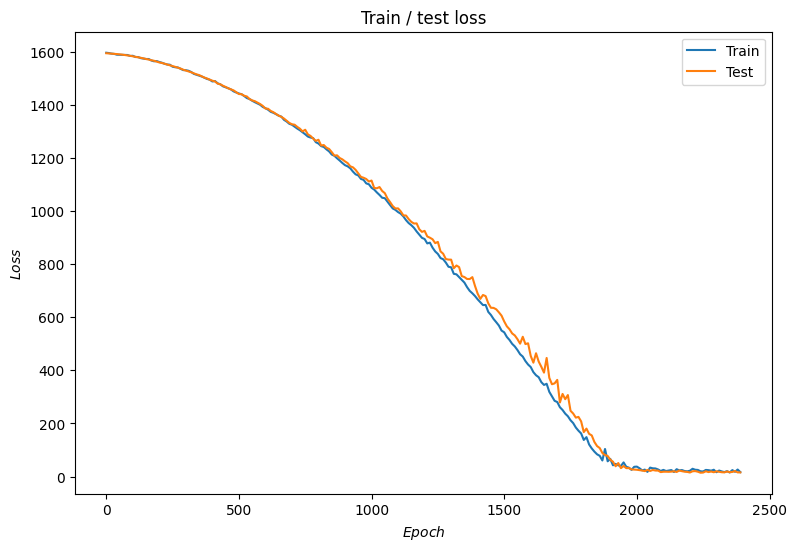

In [137]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, 256),
    nn.BatchNorm1d(256),
    nn.LeakyReLU(),
    nn.Dropout(0.1),

    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.LeakyReLU(),
    nn.Dropout(0.1),

    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.LeakyReLU(),

    nn.Linear(64, n_out_neurons)
)

train_loss_values, valid_loss_values, epoch_count, net_best_valid_rmse = train_net(
    net, X_train_ft, y_train_ft, X_valid_ft, y_valid_ft,
    learning_rate=0.0001, batch_size=64, patience=15)
plot_loss(train_loss_values, valid_loss_values, epoch_count)

In [138]:
net_best_valid_rmse = net_best_valid_rmse.detach().numpy().item()

### Сравнение моделей

In [139]:
data = {
    'Model': ['DecisionTreeRegressor', 'RandomForestRegressor',
              'CatBoostRegressor', 'LightGBMRegressor',
              'NeuralNetwork'],
    'MAE': [best_score_dt, best_score_rf, best_score_cb, best_score_lgbm,
            net_best_valid_rmse]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)
df.sort_values(by='MAE')

,MAE
Model,
CatBoostRegressor,6.404907
LightGBMRegressor,6.566536
RandomForestRegressor,6.590003
DecisionTreeRegressor,7.383138
NeuralNetwork,14.536659


__Промежуточный вывод__:
- мы обучили несколько моделей (решающее дерево, случайный лес ,бустинги, нейронную сеть)
- лучший результат показала модель CatBoostRegressor ('depth': 5, 'iterations': 400, 'learning_rate': 0.05), метрика MAE на кросс-валидации составляет 6.4.

## Тестирование лучшей модели

In [140]:
predictions = best_estimator_cb.predict(X_test)

# рассчитайте MAE и R2 для линейной регрессии
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

# вывод полученных значений
print(f"R2 = {r2:.3f}")
print(f"MAE = {mae:.0f}")

R2 = 0.299
MAE = 6


### Сравнение с DummyRegressor

In [141]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)
dummy_pred = dummy_model.predict(X_test)
dummy_mae = mean_absolute_error(y_test, dummy_pred)
dummy_mae

7.969157179492494

В среднем модель ошибается в предсказниях на 6 радусов. Требуемое значение целевой метрики на тестовых данных достигнуто.  Модель работает лучше, чем dummy-модель. Вместе с тем, если посмотреть на R2, можно сделать вывод, что модель требует улучшений.

### Анализ важности признаков

In [142]:
explainer = shap.TreeExplainer(best_estimator_cb.named_steps['model'])
shap_values = explainer(X)

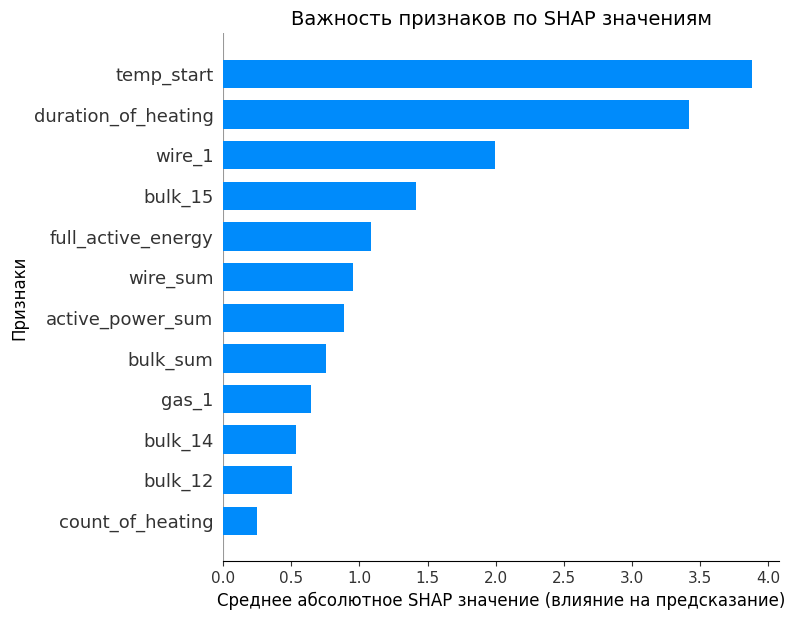

In [143]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title("Важность признаков по SHAP значениям", fontsize=TITLE_SIZE)
plt.xlabel("Среднее абсолютное SHAP значение (влияние на предсказание)",
          fontsize=LABEL_SIZE)
plt.ylabel("Признаки", fontsize=LABEL_SIZE)

plt.tight_layout()
plt.show()

Самыми важными признаками являются начальная температура
и длительность нагрева, также значимое влияние оказывают объем  самого используемого проволочного материала и одного из самых используемых сыпучих материалов.

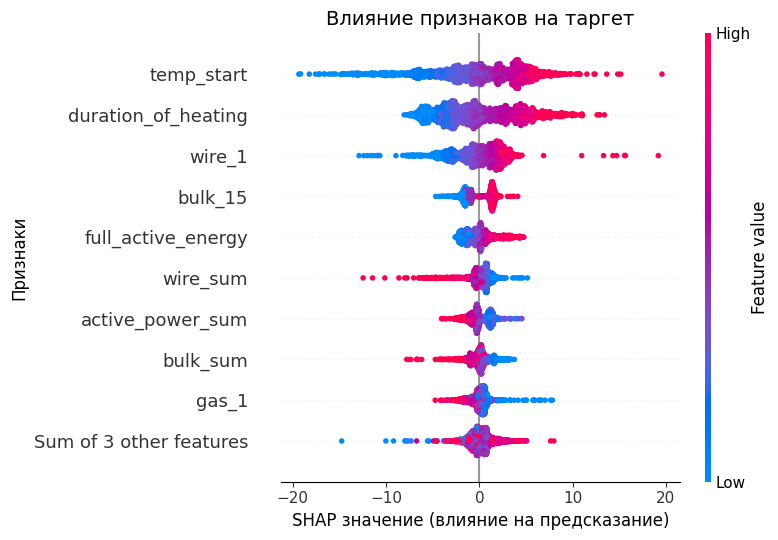

In [144]:
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(shap_values, show=False)
plt.title("Влияние признаков на таргет", fontsize=TITLE_SIZE)
plt.xlabel("SHAP значение (влияние на предсказание)", fontsize=LABEL_SIZE)
plt.ylabel("Признаки", fontsize=LABEL_SIZE)

plt.tight_layout()
plt.show()

Чем больше значение признака, тем выше значение таргета, для следующих признаков: начальная температура, длительность нагрева, объем проволочного матриала (wire_1), объем сыпучего материала (bulk_15), активная энергия.

Чем меньше значение признака, тем меньше значение таргета:  суммарный объем проволочного материала, сыпучего материала, газа, суммарная активная мощность.


#### Зависимость конечной температуры от начальной температуры


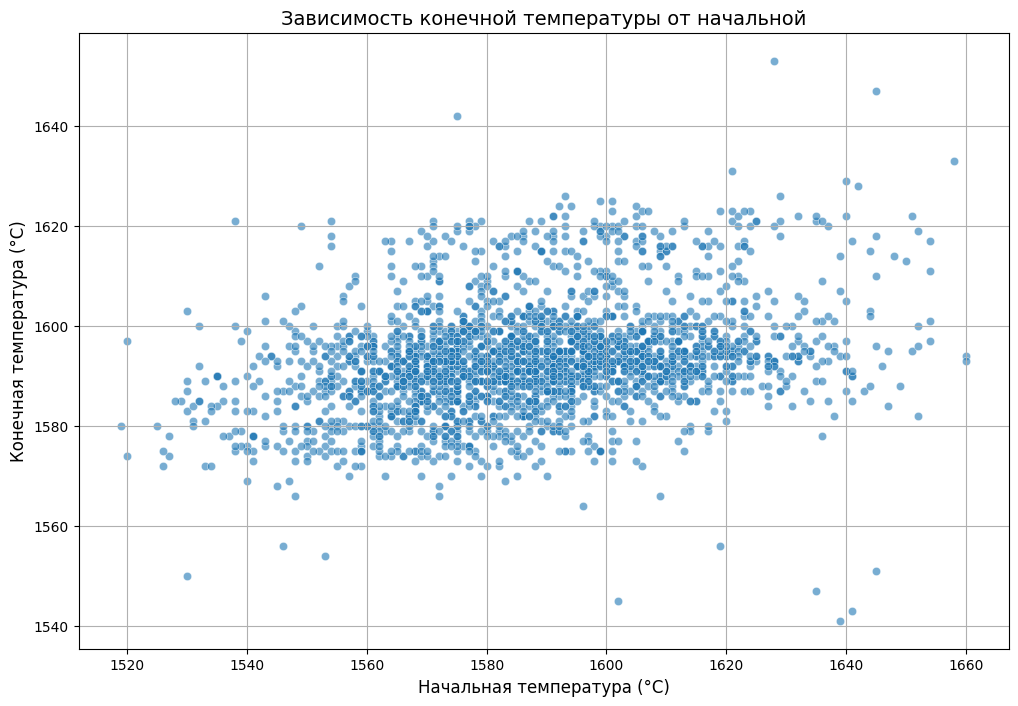

In [145]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='temp_start', y='temp_end', data=merged_data, alpha=0.6)
plt.title('Зависимость конечной температуры от начальной', fontsize=TITLE_SIZE )
plt.xlabel('Начальная температура (°C)', fontsize=LABEL_SIZE)
plt.ylabel('Конечная температура (°C)', fontsize=LABEL_SIZE)
plt.grid(True)
plt.show()

## Общий вывод

Мы загрузили данные, предоставленные заказчиком, провели исследовательский и корреляционный анализ. При формировании итогового датасета учитывали только партии, прошедшие все стадии обработки, для которых не было записей с какими-либо аномальными данными. При выборе признаков учитывали результаты корреляционного анализа.

Мы рассмотрели несколько моделей для предсказания конечной температуры сплава, лучшей для решения задачи оказалась CatBoostRegressor, показавшая на тестовых данных MAE=6, R2=0.299. Подходящее значение целевой метрики достигнуто.

Анализ важности признаков показал, что самыми значимыми являются начальная температура и длительность нагрева, также влияет на конечную температуру объем самого используемого проволочного материала и одного из самых используемых сыпучих материалов (bulk_15).

Дополнительно мы отобразили зависимость между начальной и конечной температурой.

Т.к. значение метрики R2 все еще далеко от 1, для улучшения модели можно попробовать:
- использовать другой набор признаков (использовать только суммы подаваемых материалов, не используя самые популярные, использовать либо суммарную активную мощность, либо энергию)
- обогатить данные дополнительными признаками (возможно, добавление подробностей о химическом составе стали и материалов увеличит точность предсказаний).